# **IMPORTS**

In [1]:
# Importing all the neccessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt


# **ABOUT THE DATA**

In [2]:
# Loading dataset
data = pd.read_csv(r"Sample - Superstore.csv", encoding='latin1')
print("Data loaded successfully.")
display(data.head())

Data loaded successfully.


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
# Exploring the dataset and its properties

print("Size of the DataFrame (rows, columns):", data.shape)
print("\nColumn Names:", data.columns)

#Checking for missing null values
print("\nMissing values:")
print(data.isnull().sum())

Size of the DataFrame (rows, columns): (9994, 21)

Column Names: Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

Missing values:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


# **DATA CLEANING**

In [4]:
# Data Cleaning

# Replace '/' with '-' in 'Order Date' and 'Ship Date' columns for string values
for col in ['Order Date', 'Ship Date']:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace('/', '-', regex=False)
    else:
        print(f"Column '{col}' is not of string type, skipping replacement.")

# Convert order date and ship date to datetime objects
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')
data['Ship Date'] = pd.to_datetime(data['Ship Date'], errors='coerce')

# Display the data types after conversion
print("Data types after converting date columns:")
print(data[['Order Date', 'Ship Date']].dtypes)

# Display the first few rows to see the effect of the conversion
display(data.head())

Data types after converting date columns:
Order Date    datetime64[ns]
Ship Date     datetime64[ns]
dtype: object


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# **EXPLORATORY DATA ANALYSIS**

## Shipping Time

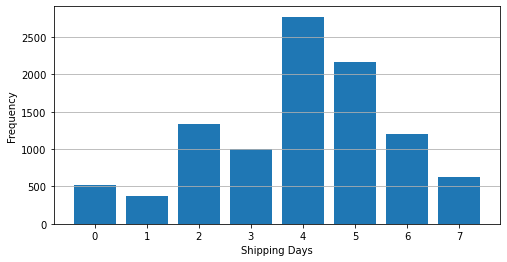

In [5]:
# Exploratory Data Analysis

df = data.copy()

# Plot to show how many orders took how many shipping days
df['Shipping Time'] = df['Ship Date'] - df['Order Date']
df['Shipping Days'] = df['Shipping Time'].dt.days
plt.figure(figsize=(8, 4))
shipping_counts = df['Shipping Days'].value_counts().sort_index()

plt.bar(shipping_counts.index, shipping_counts.values)
plt.xlabel('Shipping Days')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

## Ship Mode

Unique values for Ship mode: 	 
 ['Second Class' 'Standard Class' 'First Class' 'Same Day']


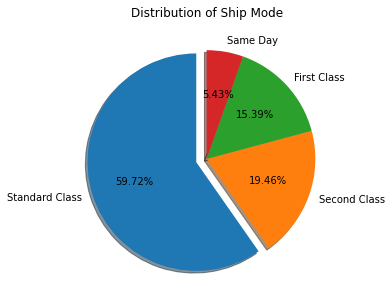

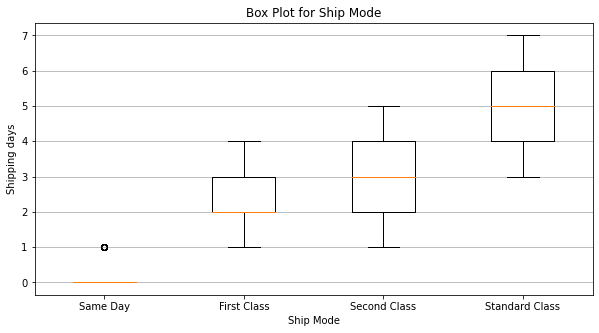

In [6]:
# Analysis for Ship Mode column

print("Unique values for Ship mode: \t \n", df['Ship Mode'].unique())

#Pie Plot for Ship Mode
segment_counts = df['Ship Mode'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.2f%%',explode = [0.1, 0, 0,0], startangle=90, shadow=True)
plt.title('Distribution of Ship Mode')
plt.show()

# Box Plot for Ship Mode
plt.figure(figsize=(10, 5))
modes = ['Same Day', 'First Class', 'Second Class','Standard Class']
plt.boxplot([df[df['Ship Mode'] == mode]['Shipping Days'] for mode in modes], labels=modes)
plt.xlabel('Ship Mode')
plt.ylabel('Shipping days')
plt.title("Box Plot for Ship Mode")
plt.grid(axis='y')
plt.show()

## Segment

Unique values for column Segment : 	 
 ['Consumer' 'Corporate' 'Home Office']


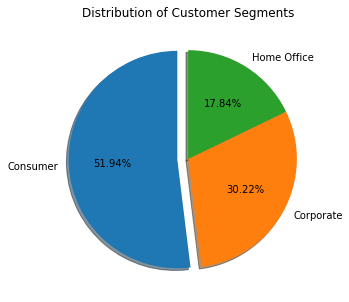

In [7]:
# Analysis of Segment column

print("Unique values for column Segment : \t \n", df['Segment'].unique())

# Plot for the same
segment_counts = df['Segment'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.2f%%',explode = [0.1, 0, 0], startangle=90, shadow=True)
plt.title('Distribution of Customer Segments')
plt.show()

## Customer Sales

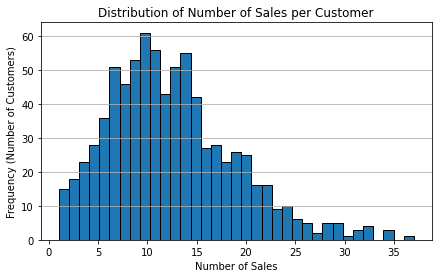

In [8]:
# Distribution of Number of Sales per Customer

segment_counts = df['Customer Name'].value_counts()

plt.figure(figsize=(7, 4))
plt.hist(segment_counts, bins=35, edgecolor='black')
plt.title('Distribution of Number of Sales per Customer')
plt.xlabel('Number of Sales')
plt.ylabel('Frequency (Number of Customers)')
plt.grid(axis='y')
plt.show()

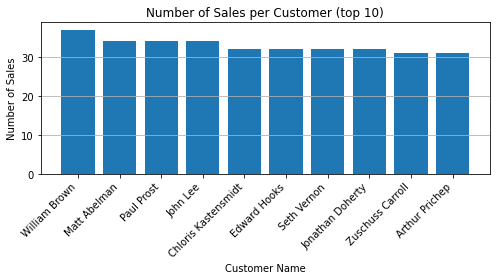

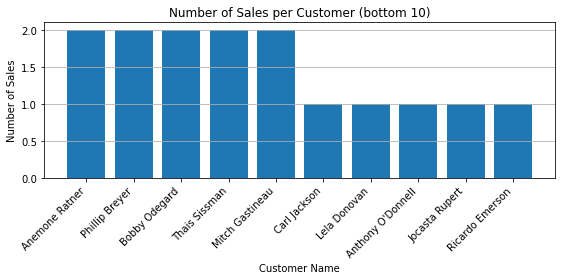

In [9]:
# Number of Sales analysis

# Top 10
sale_count = df['Customer Name'].value_counts()
sale_count_top10 = sale_count.head(10)

plt.figure(figsize=(7, 4))
plt.bar(sale_count_top10.index, sale_count_top10.values)
plt.title('Number of Sales per Customer (top 10)')
plt.xlabel('Customer Name')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Bottom 10
sale_count_bot10 = sale_count.tail(10)

plt.figure(figsize=(8, 4))
plt.bar(sale_count_bot10.index, sale_count_bot10.values)
plt.title('Number of Sales per Customer (bottom 10)')
plt.xlabel('Customer Name')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## State

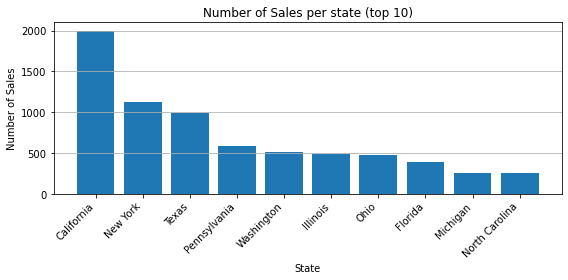


Number of sales per state:


California              2001
New York                1128
Texas                    985
Pennsylvania             587
Washington               506
Illinois                 492
Ohio                     469
Florida                  383
Michigan                 255
North Carolina           249
Arizona                  224
Virginia                 224
Georgia                  184
Tennessee                183
Colorado                 182
Indiana                  149
Kentucky                 139
Massachusetts            135
New Jersey               130
Oregon                   124
Wisconsin                110
Maryland                 105
Delaware                  96
Minnesota                 89
Connecticut               82
Oklahoma                  66
Missouri                  66
Alabama                   61
Arkansas                  60
Rhode Island              56
Mississippi               53
Utah                      53
South Carolina            42
Louisiana                 42
Nevada        

In [10]:
# Analysis on State column

sale_count = df['State'].value_counts()
sale_count_top10 = sale_count.head(10)

plt.figure(figsize=(8, 4))
plt.bar(sale_count_top10.index, sale_count_top10.values)
plt.title('Number of Sales per state (top 10)')
plt.xlabel('State')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("\nNumber of sales per state:")
display(sale_count)

## Category

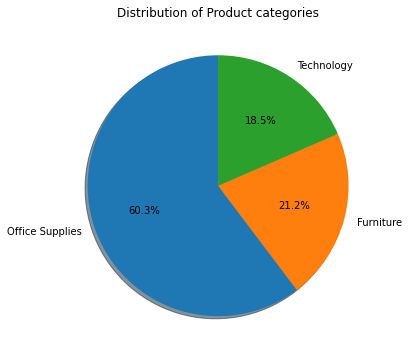

In [11]:
# Analysis of Catergory column

category_counts = df['Category'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Distribution of Product categories')
plt.show()

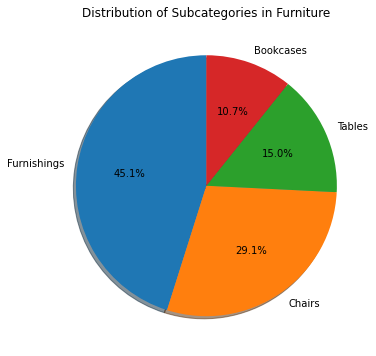

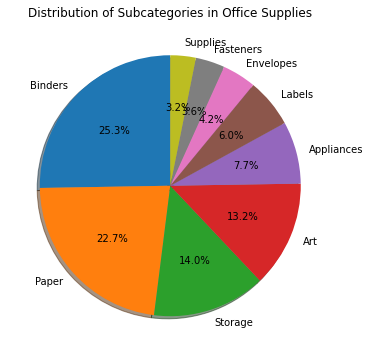

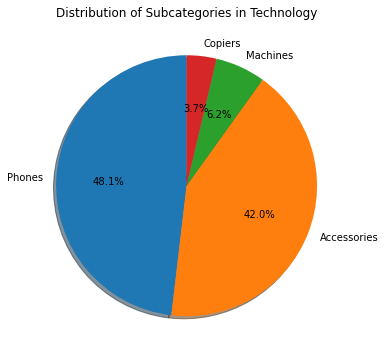

In [12]:
# Plot to showcase various Sub-categories for each cateogries

categories = df['Category'].unique()

for category in categories:
    category_df = df[df['Category'] == category]
    subcategory_counts = category_df['Sub-Category'].value_counts()

    plt.figure(figsize=(6, 6))
    plt.pie(subcategory_counts, labels=subcategory_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title(f'Distribution of Subcategories in {category}')
    plt.show()

## Monthly Sales

Number of sales per month:


,Order Month,Number of Sales
0,2014-01,79
1,2014-02,46
2,2014-03,157
3,2014-04,135
4,2014-05,122
5,2014-06,135
6,2014-07,143
7,2014-08,153
8,2014-09,268
9,2014-10,159


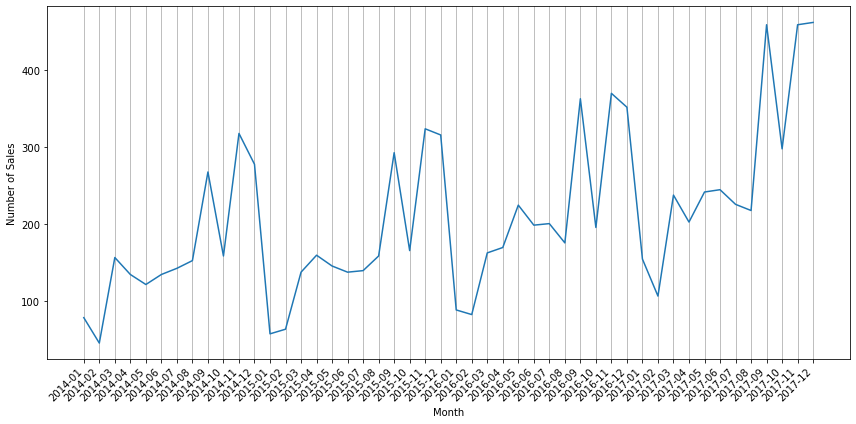

In [13]:
# To visualise number of sales per month

df['Order Month'] = df['Order Date'].dt.to_period('M')
monthly_sales_count = df.groupby('Order Month').size().reset_index(name='Number of Sales')
print("Number of sales per month:")
display(monthly_sales_count)

# Plot for the same
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_count['Order Month'].astype(str), monthly_sales_count['Number of Sales'])
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

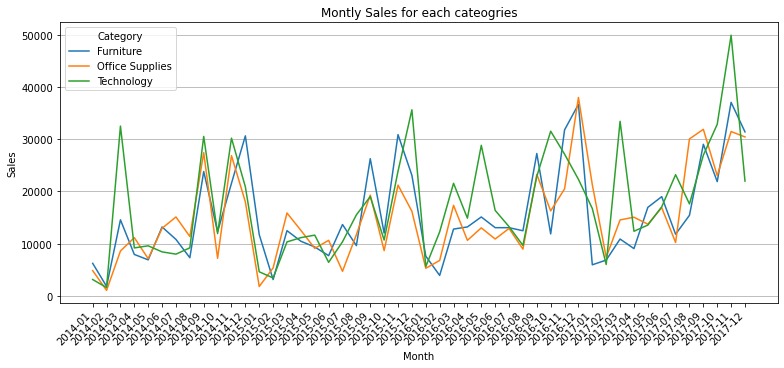

In [14]:
# Montly data analysis

monthly_category_sales = df.groupby([df['Order Date'].dt.to_period('M'), 'Category'])['Sales'].sum().reset_index()
categories = monthly_category_sales['Category'].unique()

plt.figure(figsize=(11, 5))

for category in categories:
    category_data = monthly_category_sales[monthly_category_sales['Category'] == category]
    plt.plot(category_data['Order Date'].astype(str), category_data['Sales'], label=category)

plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category')
plt.tight_layout()
plt.title("Montly Sales for each cateogries")
plt.show()

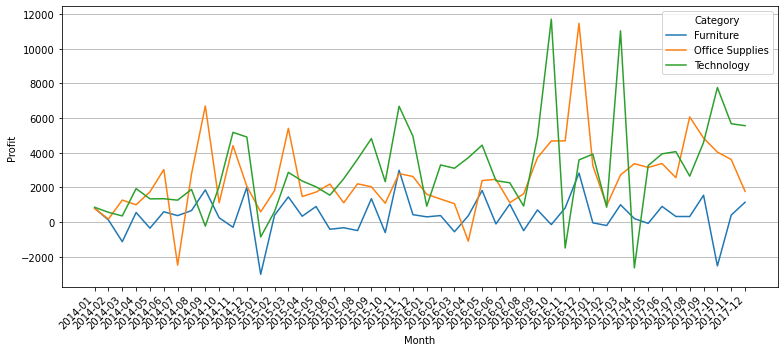

In [15]:
# Montly Profit for each categories

monthly_category_profit = df.groupby([df['Order Date'].dt.to_period('M'), 'Category'])['Profit'].sum().reset_index()

plt.figure(figsize=(11,5))
for category in categories:
    category_data = monthly_category_profit[monthly_category_profit['Category'] == category]
    plt.plot(category_data['Order Date'].astype(str), category_data['Profit'], label=category)

plt.xlabel('Month')
plt.ylabel('Profit')
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

   Order Month        Sales  Number of Sales
0      2014-01   14236.8950               79
1      2014-02    4519.8920               46
2      2014-03   55691.0090              157
3      2014-04   28295.3450              135
4      2014-05   23648.2870              122
5      2014-06   34595.1276              135
6      2014-07   33946.3930              143
7      2014-08   27909.4685              153
8      2014-09   81777.3508              268
9      2014-10   31453.3930              159
10     2014-11   78628.7167              318
11     2014-12   69545.6205              278
12     2015-01   18174.0756               58
13     2015-02   11951.4110               64
14     2015-03   38726.2520              138
15     2015-04   34195.2085              160
16     2015-05   30131.6865              146
17     2015-06   24797.2920              138
18     2015-07   28765.3250              140
19     2015-08   36898.3322              159
20     2015-09   64595.9180              293
21     201

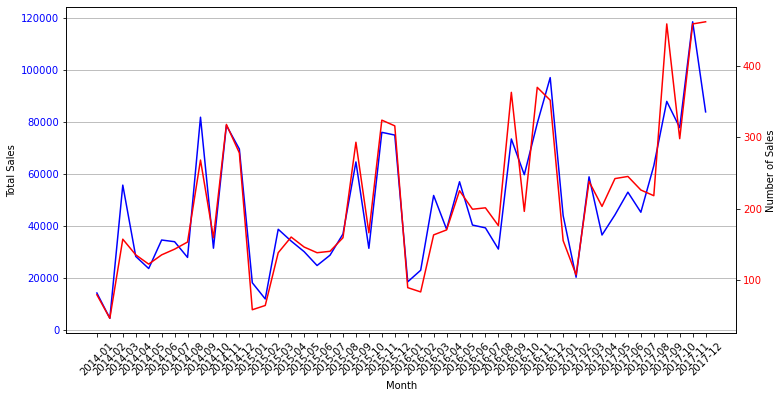

In [16]:
# Monthly trends
monthly_sales = df.groupby('Order Month')['Sales'].sum().reset_index()
monthly_sales_count = df.groupby('Order Month').size().reset_index(name='Number of Sales')
monthly_trends = pd.merge(monthly_sales, monthly_sales_count, on='Order Month')
print(monthly_trends)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(monthly_trends['Order Month'].astype(str), monthly_trends['Sales'], color='blue', label='Monthly Sales')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Sales')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(axis='y')

ax2 = ax1.twinx()
ax2.plot(monthly_trends['Order Month'].astype(str), monthly_trends['Number of Sales'], color='red', label='Number of Sales')
ax2.set_ylabel('Number of Sales')
ax2.tick_params(axis='y', labelcolor='red')

ax1.tick_params(axis='x', rotation=45)
plt.show()

## Product

In [17]:
# Analysis on various Products in our dataset
product_sales = df.groupby(['Product ID', 'Product Name', 'Category', 'Sub-Category'])['Quantity'].sum().reset_index()
product_sales = product_sales.rename(columns={'Quantity': 'Number Sold'})

productssortedsales = product_sales.sort_values(by='Number Sold', ascending=False)

print("\nProducts most bought:")
display(productssortedsales.head(10))

print("\nProducts least bought:")
display(productssortedsales.tail(10))


Products most bought:


,Product ID,Product Name,Category,Sub-Category,Number Sold
704,OFF-BI-10001524,GBC Premium Transparent Covers with Diagonal L...,Office Supplies,Binders,67
95,FUR-CH-10002647,"Situations Contoured Folding Chairs, 4/Set",Furniture,Chairs,64
333,FUR-TA-10001095,Chromcraft Round Conference Tables,Furniture,Tables,61
848,OFF-BI-10004728,Wilson Jones Turn Tabs Binder Tool for Ring Bi...,Office Supplies,Binders,59
112,FUR-CH-10003774,"Global Wood Trimmed Manager's Task Chair, Khaki",Furniture,Chairs,59
1573,TEC-AC-10003038,Kingston Digital DataTraveler 16GB USB 2.0,Technology,Accessories,57
1376,OFF-ST-10001809,Fellowes Officeware Wire Shelving,Office Supplies,Storage,55
99,FUR-CH-10002880,"Global High-Back Leather Tilter, Burgundy",Furniture,Chairs,54
123,FUR-CH-10004287,SAFCO Arco Folding Chair,Furniture,Chairs,53
1239,OFF-PA-10003441,Xerox 226,Office Supplies,Paper,53



Products least bought:


,Product ID,Product Name,Category,Sub-Category,Number Sold
1842,TEC-PH-10003535,RCA ViSYS 25423RE1 Corded phone,Technology,Phones,2
1260,OFF-PA-10003919,Xerox 1989,Office Supplies,Paper,2
1663,TEC-MA-10001856,Okidata C610n Printer,Technology,Machines,2
240,FUR-FU-10002874,Ultra Commercial Grade Dual Valve Door Closer,Furniture,Furnishings,2
906,OFF-EN-10004206,Multimedia Mailers,Office Supplies,Envelopes,2
88,FUR-CH-10002317,Global Enterprise Series Seating Low-Back Swiv...,Furniture,Chairs,1
1029,OFF-PA-10000048,Xerox 20,Office Supplies,Paper,1
1688,TEC-MA-10003493,Penpower WorldCard Pro Card Scanner,Technology,Machines,1
568,OFF-AR-10002704,Boston 1900 Electric Pencil Sharpener,Office Supplies,Art,1
17,FUR-BO-10002206,"Bush Saratoga Collection 5-Shelf Bookcase, Han...",Furniture,Bookcases,1


In [18]:
# Product sales analysis

product_sales = (df.groupby(['Product ID', 'Product Name'])['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False).reset_index())
display(product_sales.head())

,index,Product ID,Product Name,Sales
0,1640,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,61599.824
1,787,OFF-BI-10003527,Fellowes PB500 Electric Punch Plastic Comb Bin...,27453.384
2,1669,TEC-MA-10002412,Cisco TelePresence System EX90 Videoconferenci...,22638.480
3,82,FUR-CH-10002024,HON 5400 Series Task Chairs for Big and Tall,21870.576
4,701,OFF-BI-10001359,GBC DocuBind TL300 Electric Binding System,19823.479


## Region

Total profit by region:
    Region       Profit
3     West  108418.4489
1     East   91522.7800
2    South   46749.4303
0  Central   39706.3625


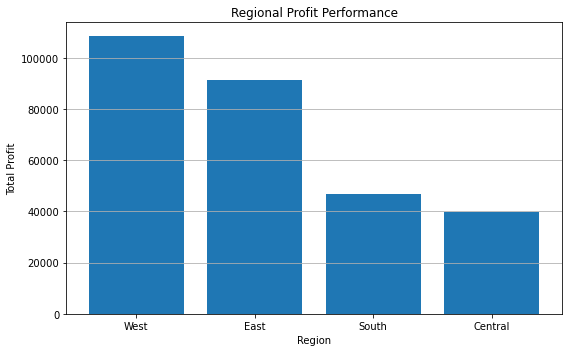

In [19]:
# Regional data analysis

regional_profit = df.groupby('Region')['Profit'].sum().reset_index()
regional_profit = regional_profit.sort_values(by='Profit', ascending=False)

print("Total profit by region:")
print(regional_profit)

plt.figure(figsize=(8, 5))
plt.bar(regional_profit['Region'], regional_profit['Profit'])
plt.xlabel('Region')
plt.ylabel('Total Profit')
plt.title('Regional Profit Performance')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# **PARETO RULE**

## Pareto for Product Sales

423 products makes
0.8003834449025428 of sales

423 out of 1894
that is 22.333685322069694% of all products


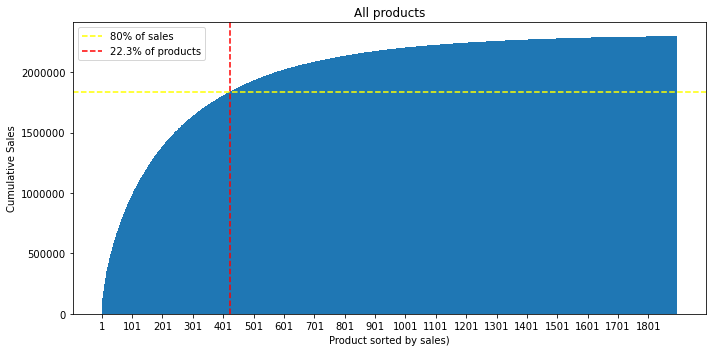

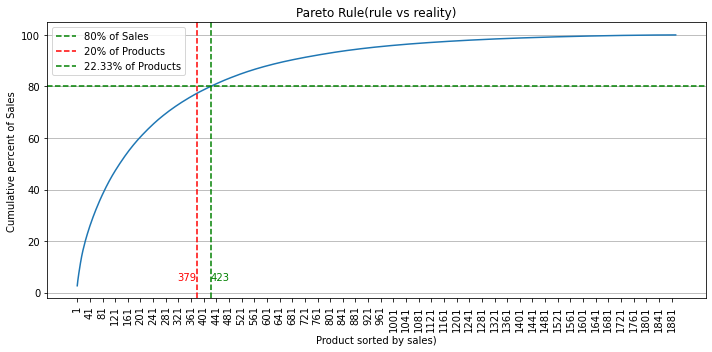

In [20]:
# Pareto Principle for Product Sales

product_sales['Cumulative Sales'] = product_sales['Sales'].cumsum()
product_sales['Cumulative percent'] = (product_sales['Cumulative Sales'] / (product_sales['Sales'].sum())) * 100
products_80 = (product_sales['Cumulative percent'] <= 80).sum() + 1

print(f"{products_80} products makes")
print(f"{product_sales.loc[products_80-1,'Cumulative Sales']/product_sales['Sales'].sum()} of sales")

print(f"\n{products_80} out of {len(product_sales)}")
print(f"that is {(products_80 / len(product_sales))*100}% of all products")

# Pareto Plot for Product Sales
plt.figure(figsize=(10, 5))
top80 = product_sales.head(products_80)
plt.bar(range(1, len(product_sales) + 1), product_sales['Cumulative Sales'], width=1)
plt.title('All products')
plt.xlabel('Product sorted by sales)')

plt.axhline(product_sales.loc[products_80-1,'Cumulative Sales'], color='yellow', linestyle='--', label='80% of sales')
plt.axvline(products_80, color='red', linestyle='--', label='22.3% of products')

plt.xticks(range(1, len(product_sales)+2, 100))
plt.ylabel('Cumulative Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()

plt.tight_layout()
plt.show()

# Actual Sales vs Pareto Principle plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(product_sales) + 1), product_sales['Cumulative percent'])
plt.title('Pareto Rule(rule vs reality)')
plt.xlabel('Product sorted by sales)')
plt.ylabel('Cumulative percent of Sales')

plt.axhline(80, color='green', linestyle='--', label='80% of Sales')
plt.axvline(0.2 * len(product_sales), color='red', linestyle='--', label='20% of Products')
plt.text(0.2 * len(product_sales), +5, f'{0.2 * len(product_sales):.0f}', color='red',ha = 'right')

plt.axvline(products_80, color='green', linestyle='--', label=f'{(products_80 / len(product_sales))*100:.2f}% of Products')
plt.text(products_80, +5, f'{products_80}', color='green')

plt.legend()
plt.grid(axis='y')
plt.xticks(range(1, len(product_sales) + 1, 40), rotation=90)
plt.tight_layout()
plt.show()



## Pareto for Customer Sales

     index Customer ID   Customer Name       Sales  Cumulative Sales  \
0      700    SM-20320     Sean Miller  25043.0500      2.504305e+04   
1      741    TC-20980    Tamara Chand  19052.2180      4.409527e+04   
2      621    RB-19360    Raymond Buch  15117.3390      5.921261e+04   
3      730    TA-21385    Tom Ashbrook  14595.6200      7.380823e+04   
4        6    AB-10105   Adrian Barton  14473.5710      8.828180e+04   
..     ...         ...             ...         ...               ...   
390    358    JF-15190    Jamie Frazer   2279.5860      1.827758e+06   
391    284    FH-14350     Fred Harton   2271.2840      1.830030e+06   
392    136    CC-12670  Craig Carreira   2269.7015      1.832299e+06   
393     76    BE-11410     Bobby Elias   2261.4380      1.834561e+06   
394    435    KM-16225    Kalyca Meade   2260.9580      1.836822e+06   

     Cumulative percent  
0              1.090155  
1              1.919522  
2              2.577598  
3              3.212964  
4    

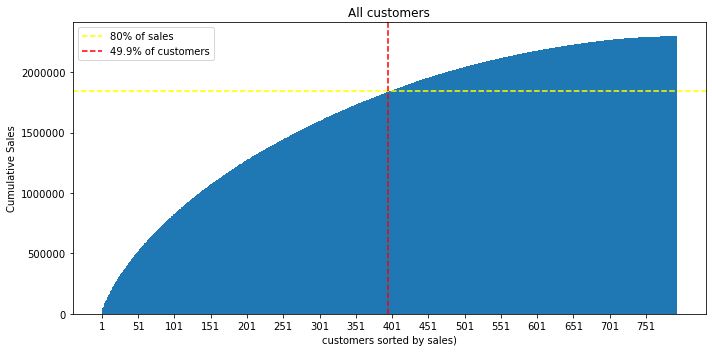

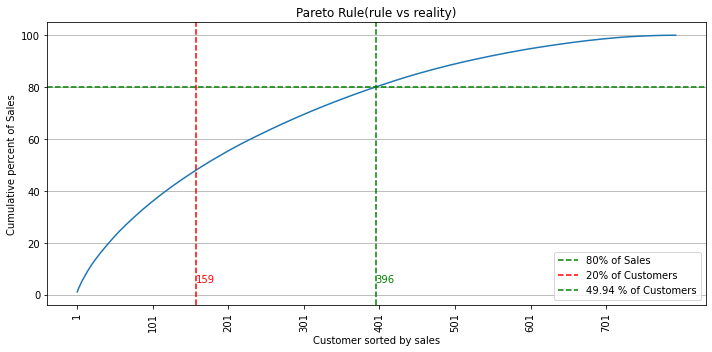

In [21]:
# Pareto principle for Customer Sales

customer_sales = (df.groupby(['Customer ID', 'Customer Name'])['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)).reset_index()
customer_sales['Cumulative Sales'] = customer_sales['Sales'].cumsum()
customer_sales['Cumulative percent'] = (customer_sales['Cumulative Sales'] / (customer_sales['Sales'].sum()))*100
customers_80 = (customer_sales['Cumulative percent'] <= 80).sum() + 1

print((customer_sales[customer_sales['Cumulative percent'] <= 80]))
print(customer_sales.loc[customers_80,'Cumulative Sales'])
print(customer_sales['Sales'].sum())

print(f"\n{customers_80} customers contribute to")
print(f"{(customer_sales.loc[customers_80,'Cumulative Sales']/customer_sales['Sales'].sum())*100} of sales")

print(f"\n{customers_80} out of {len(customer_sales)}")
print(f"that is {(customers_80 / len(customer_sales))*100}% of all customers")

# Plot
plt.figure(figsize=(10, 5))
top80 = customer_sales.head(customers_80)
plt.bar(range(1, len(customer_sales)+1 ), customer_sales['Cumulative Sales'],width=1)
plt.title('All customers')
plt.xlabel('customers sorted by sales)')

plt.axhline(customer_sales.loc[customers_80,'Cumulative Sales'], color='yellow', linestyle='--', label='80% of sales')
plt.axvline(customers_80, color='red', linestyle='--', label=f'{customers_80 / len(customer_sales) * 100:.1f}% of customers')

plt.xticks(range(1, len(customer_sales)+2, 50))
plt.ylabel('Cumulative Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.tight_layout()
plt.show()

# Actual Sales Vs Pareto Principle for Customer Sales
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(customer_sales) + 1), customer_sales['Cumulative percent'])
plt.title('Pareto Rule(rule vs reality)')
plt.xlabel('Customer sorted by sales')
plt.ylabel('Cumulative percent of Sales')

plt.axhline(80, color='green', linestyle='--', label='80% of Sales')
plt.axvline(0.2 * len(customer_sales), color='red', linestyle='--', label='20% of Customers')
plt.text(0.2 * len(customer_sales), +5, f'{0.2 * len(customer_sales):.0f}', color='red')

plt.axvline(customers_80, color='green', linestyle='--', label=f"{(customers_80 / len(customer_sales))*100:.2f} % of Customers")
plt.text(customers_80, +5, f'{customers_80}', color='green')

plt.legend()
plt.grid(axis='y')
plt.xticks(range(1, len(customer_sales) + 1, 100), rotation=90)
plt.tight_layout()
plt.show()

# **PREDICTING WITH PROFIT**

## **DATA PREPROCESSING**

### Train and Test set

In [22]:
# Splitting data into train and test set

y = np.log1p(data['Sales'])   # Target variable: Sales
X = data.copy()   # Feature dataset

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

print(f"X_train_raw shape: {X_train_raw.shape}")
print(f"X_test_raw shape: {X_test_raw.shape}")

X_train_raw shape: (6995, 21)
X_test_raw shape: (2999, 21)


### Feature Engineering

In [23]:
def feature_engineer(X_train, X_test):

    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()

    # Creating new features from our original features

    # Product-level features
    product_avg_quantity = X_train_fe.groupby('Product ID')['Quantity'].mean()
    product_avg_discount = X_train_fe.groupby('Product ID')['Discount'].mean()
    product_popularity = X_train_fe.groupby('Product ID')['Quantity'].sum()
    product_avg_profit = X_train_fe.groupby('Product ID')['Profit'].mean()

    # Customer-level features
    customer_avg_quantity = X_train_fe.groupby('Customer ID')['Quantity'].mean()
    customer_total_items = X_train_fe.groupby('Customer ID')['Quantity'].sum()
    customer_avg_discount = X_train_fe.groupby('Customer ID')['Discount'].mean()
    customer_avg_profit = X_train_fe.groupby('Customer ID')['Profit'].mean()

    # Location-level features
    city_avg_quantity = X_train_fe.groupby('City')['Quantity'].mean()
    state_avg_discount = X_train_fe.groupby('State')['Discount'].mean()
    city_avg_profit = X_train_fe.groupby('City')['Profit'].mean()
    state_avg_profit = X_train_fe.groupby('State')['Profit'].mean()


    # SubCategory-level features
    subcategory_avg_quantity = X_train_fe.groupby('Sub-Category')['Quantity'].mean()
    subcategory_avg_profit = X_train_fe.groupby('Sub-Category')['Profit'].mean()

    # Category-level features
    category_avg_profit = X_train_fe.groupby('Category')['Profit'].mean()


    # Handling missing values
    # Creating global values to replace missing values
    global_avg_quantity = X_train_fe['Quantity'].mean()
    global_avg_discount = X_train_fe['Discount'].mean()
    global_avg_profit = X_train_fe['Profit'].mean()

    # Creating df and mappings to handle the missing values
    dataframes = [X_train_fe, X_test_fe]
    mappings = {
        'Product_Avg_Quantity': (product_avg_quantity, global_avg_quantity),
        'Product_Avg_Discount': (product_avg_discount, global_avg_discount),
        'Product_Popularity': (product_popularity, 0),
        'Product_Avg_Profit': (product_avg_profit, global_avg_profit),
        'Customer_Avg_Quantity': (customer_avg_quantity, global_avg_quantity),
        'Customer_Total_Items': (customer_total_items, 0),
        'Customer_Avg_Discount': (customer_avg_discount, global_avg_discount),
        'Customer_Avg_Profit': (customer_avg_profit, global_avg_profit),
        'City_Avg_Quantity': (city_avg_quantity, global_avg_quantity),
        'State_Avg_Discount': (state_avg_discount, global_avg_discount),
        'City_Avg_Profit': (city_avg_profit, global_avg_profit),
        'State_Avg_Profit': (state_avg_profit, global_avg_profit),
        'SubCategory_Avg_Quantity': (subcategory_avg_quantity, global_avg_quantity),
        'SubCategory_Avg_Profit': (subcategory_avg_profit, global_avg_profit),
        'Category_Avg_Profit': (category_avg_profit, global_avg_profit)
    }

    key_map = {
        'Product_Avg_Quantity': 'Product ID', 'Product_Avg_Discount': 'Product ID', 'Product_Popularity': 'Product ID', 'Product_Avg_Profit': 'Product ID', # Added profit key
        'Customer_Avg_Quantity': 'Customer ID', 'Customer_Total_Items': 'Customer ID', 'Customer_Avg_Discount': 'Customer ID', 'Customer_Avg_Profit': 'Customer ID', # Added profit key
        'City_Avg_Quantity': 'City', 'State_Avg_Discount': 'State', 'City_Avg_Profit': 'City', 'State_Avg_Profit': 'State', # Added profit key
        'SubCategory_Avg_Quantity': 'Sub-Category', 'SubCategory_Avg_Profit': 'Sub-Category',
        'Category_Avg_Profit': 'Category'
    }

    for df in dataframes:
        for new_col, (mapper, fill_val) in mappings.items():
            map_key = key_map[new_col]
            df[new_col] = df[map_key].map(mapper).fillna(fill_val)

    # Creating more features
    for df in dataframes:
        # Date features
        df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
        df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')
        df['Order Year'] = df['Order Date'].dt.year.astype(str)
        df['Order DayOfWeek'] = df['Order Date'].dt.dayofweek
        df['Order Month'] = df['Order Date'].dt.month
        df['Shipping Time'] = (df['Ship Date'] - df['Order Date']).dt.days
        df['Is Weekend'] = df['Order DayOfWeek'].isin([5, 6]).astype(int)

        # Cyclic features for dates to minimise the numerical value of dates, months and days
        df['Month Sin'] = np.sin(2 * np.pi * df['Order Month'] / 12)
        df['Month Cos'] = np.cos(2 * np.pi * df['Order Month'] / 12)
        df['Day Sin'] = np.sin(2 * np.pi * df['Order DayOfWeek'] / 7)
        df['Day Cos'] = np.cos(2 * np.pi * df['Order DayOfWeek'] / 7)

        # Discount features
        df['Is Discounted'] = (df['Discount'] > 0).astype(int)
        df['Discount X Quantity'] = df['Discount'] * df['Quantity']

        # Profit features # Added profit features
        df['Profit Margin'] = df['Profit'] / (df['Sales'] + 1e-6)
        df['Profit X Quantity'] = df['Profit'] * df['Quantity']


    # Dropping unnecessary columns that include unique identifiers, original columns before feature extraction
    cols_to_drop = [
        'Row ID', 'Order ID', 'Customer Name', 'Country', 'Postal Code',
        'Product Name', 'Sales','Profit',
        'Order Date', 'Ship Date', 'Customer ID', 'Product ID',
        'City', 'State', 'Order Month', 'Order DayOfWeek'
    ]

    X_train_fe = X_train_fe.drop(columns=cols_to_drop, errors='ignore')
    X_test_fe = X_test_fe.drop(columns=cols_to_drop, errors='ignore')

    return X_train_fe, X_test_fe

X_train, X_test = feature_engineer(X_train_raw, X_test_raw)

print(f"X_train shape after FE: {X_train.shape} \n")
display(X_train.head())

print(f"X_test shape after FE: {X_test.shape} \n")
display(X_test.head())

X_train shape after FE: (6995, 33) 



,Ship Mode,Segment,Region,Category,Sub-Category,Quantity,Discount,Product_Avg_Quantity,Product_Avg_Discount,Product_Popularity,...,Shipping Time,Is Weekend,Month Sin,Month Cos,Day Sin,Day Cos,Is Discounted,Discount X Quantity,Profit Margin,Profit X Quantity
5080,Standard Class,Consumer,West,Office Supplies,Storage,1,0.0,3.000000,0.066667,27,...,4,1,-0.500000,8.660254e-01,-0.974928,-0.222521,0,0.0,0.27,2.8296
4018,Standard Class,Consumer,South,Technology,Accessories,9,0.0,5.833333,0.066667,35,...,5,1,-0.866025,-5.000000e-01,-0.781831,0.623490,0,0.0,0.19,430.7661
8878,Standard Class,Consumer,East,Office Supplies,Storage,3,0.0,4.666667,0.033333,28,...,6,1,-1.000000,-1.836970e-16,-0.781831,0.623490,0,0.0,0.28,28.6020
5778,Standard Class,Consumer,West,Office Supplies,Art,3,0.0,2.800000,0.040000,14,...,7,0,-0.500000,8.660254e-01,0.781831,0.623490,0,0.0,0.26,23.7744
6959,Second Class,Home Office,West,Office Supplies,Paper,3,0.0,3.916667,0.066667,47,...,2,1,-1.000000,-1.836970e-16,-0.781831,0.623490,0,0.0,0.50,220.2300


X_test shape after FE: (2999, 33) 



,Ship Mode,Segment,Region,Category,Sub-Category,Quantity,Discount,Product_Avg_Quantity,Product_Avg_Discount,Product_Popularity,...,Shipping Time,Is Weekend,Month Sin,Month Cos,Day Sin,Day Cos,Is Discounted,Discount X Quantity,Profit Margin,Profit X Quantity
7108,Standard Class,Consumer,East,Office Supplies,Art,2,0.0,5.000000,0.100000,10.0,...,7,0,8.660254e-01,-5.000000e-01,0.781831,0.623490,0,0.0,0.4500,2.9520
4982,Standard Class,Corporate,West,Office Supplies,Labels,2,0.0,3.250000,0.050000,13.0,...,6,1,-5.000000e-01,8.660254e-01,-0.781831,0.623490,0,0.0,0.4600,4.8024
9955,Second Class,Corporate,West,Furniture,Tables,2,0.2,2.000000,0.350000,4.0,...,2,0,-2.449294e-16,1.000000e+00,0.000000,1.000000,1,0.4,0.0375,20.5176
7513,Standard Class,Consumer,East,Office Supplies,Art,5,0.2,2.857143,0.114286,20.0,...,4,0,-5.000000e-01,-8.660254e-01,-0.433884,-0.900969,1,1.0,0.1625,10.6600
4463,First Class,Home Office,West,Office Supplies,Paper,3,0.2,4.250000,0.050000,17.0,...,3,0,-1.000000e+00,-1.836970e-16,0.433884,-0.900969,1,0.6,0.3625,15.6078


### Preprocessing

In [24]:
def create_preprocessor(X_df):

    # Identify feature types
    categorical_features = list(X_df.select_dtypes(include=['object']).columns)
    non_categorical_features = X_df.select_dtypes(exclude=['object']).columns
    date_features = [col for col in non_categorical_features if col in ['Day Sin', 'Day Cos', 'Month Sin', 'Month Cos']]
    binary_features = [col for col in non_categorical_features if col in ['Is Discounted', 'Is Weekend']]
    numeric_features = [
        col for col in non_categorical_features
        if col not in date_features and col not in binary_features]

    print(f"\nIdentified {len(numeric_features)} numeric features: {numeric_features}")
    print(f"Identified {len(categorical_features)} categorical features: {categorical_features}")

    # Preprocessing pipelines

    # Capping outliers using IQR and Power Transformation for handling the skewness of data
    def cap_outliers(X_df_in, q_low=0.01, q_high=0.99):
        X_capped = X_df_in.copy()
        for col in X_capped.columns:
            if X_capped[col].std() > 0:
                low = X_capped[col].quantile(q_low)
                high = X_capped[col].quantile(q_high)
                X_capped[col] = np.clip(X_capped[col], low, high)
        return X_capped

    outlier_capper = FunctionTransformer(cap_outliers, validate=False)

    numeric_pipeline = Pipeline(steps=[
        ('cap_outliers', outlier_capper),
        ('power_transform', PowerTransformer(method='yeo-johnson'))
    ])

    # ColumnTransformer to allow preprocessing to columns
    transformers = []
    if numeric_features:
        transformers.append(('num', numeric_pipeline, numeric_features))
    if date_features:
        transformers.append(('date', 'passthrough', date_features))
    if binary_features:
        transformers.append(('binary', 'passthrough', binary_features))
    if categorical_features:
        transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features))

    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )

    return preprocessor, numeric_features, date_features, binary_features, categorical_features

preprocessor, numeric_features, date_features, binary_features, categorical_features = create_preprocessor(X_train)

print("Preprocessor created successfully.")


Identified 21 numeric features: ['Quantity', 'Discount', 'Product_Avg_Quantity', 'Product_Avg_Discount', 'Product_Popularity', 'Product_Avg_Profit', 'Customer_Avg_Quantity', 'Customer_Total_Items', 'Customer_Avg_Discount', 'Customer_Avg_Profit', 'City_Avg_Quantity', 'State_Avg_Discount', 'City_Avg_Profit', 'State_Avg_Profit', 'SubCategory_Avg_Quantity', 'SubCategory_Avg_Profit', 'Category_Avg_Profit', 'Shipping Time', 'Discount X Quantity', 'Profit Margin', 'Profit X Quantity']
Identified 6 categorical features: ['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category', 'Order Year']
Preprocessor created successfully.


### Feature Selection

In [25]:
# Create a temporary pipeline to get feature importances
temp_rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=50, n_jobs=-1))
])

print("Fitting temporary RandomForest to find feature importances...")
temp_rf_pipe.fit(X_train, y_train)
print("Done.")

# Get feature names from the ColumnTransformer
numeric_pipe = preprocessor.named_transformers_['num']
numeric_pipe.named_steps['cap_outliers'].feature_names_out = 'one-to-one'

cat_features_ohe = list(preprocessor.named_transformers_['cat'].get_feature_names(categorical_features))
all_features = numeric_features + date_features + binary_features + cat_features_ohe

# Feature importances from the trained model
importances = temp_rf_pipe.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Selecting only the top 30 features and training on them
top_features_ohe = list(feature_importance_df.head(30)['Feature'])

print("\n--- Top 10 Most Important Features ---")
display(feature_importance_df.head(10))

# Finding which of the original features are in the top list
top_numeric_date_binary_features = [
    col for col in (numeric_features + date_features + binary_features)
    if col in top_features_ohe]

top_cat_features = [
    col for col in categorical_features
    if any(f.startswith(f"{col}_") for f in top_features_ohe)]

final_feature_list = top_numeric_date_binary_features + top_cat_features
print(f"\nUsing these {len(final_feature_list)} features for final models:\n{final_feature_list}")

# New train and test set with new final features
X_train_selected = X_train[final_feature_list]
X_test_selected = X_test[final_feature_list]

print(f"\nShape of X_train_selected: {X_train_selected.shape}")
print(f"Shape of X_test_selected: {X_test_selected.shape}")

# Creating new preprocessor with new final features
preprocessor_selected, _, _, _, _ = create_preprocessor(X_train_selected)
print("\nFinal 'preprocessor_selected' created using top features.")

X_train_selected = X_train
X_test_selected = X_test
preprocessor_selected = preprocessor

Fitting temporary RandomForest to find feature importances...
Done.

--- Top 10 Most Important Features ---


,Feature,Importance
20,Profit X Quantity,0.621775
5,Product_Avg_Profit,0.090812
19,Profit Margin,0.089460
39,Category_Office Supplies,0.056317
15,SubCategory_Avg_Profit,0.042125
0,Quantity,0.018643
55,Sub-Category_Storage,0.018381
1,Discount,0.015504
50,Sub-Category_Furnishings,0.006363
18,Discount X Quantity,0.004963



Using these 26 features for final models:
['Quantity', 'Discount', 'Product_Avg_Quantity', 'Product_Avg_Discount', 'Product_Popularity', 'Product_Avg_Profit', 'Customer_Avg_Quantity', 'Customer_Total_Items', 'Customer_Avg_Discount', 'Customer_Avg_Profit', 'City_Avg_Quantity', 'State_Avg_Discount', 'City_Avg_Profit', 'State_Avg_Profit', 'SubCategory_Avg_Quantity', 'SubCategory_Avg_Profit', 'Category_Avg_Profit', 'Shipping Time', 'Discount X Quantity', 'Profit Margin', 'Profit X Quantity', 'Month Sin', 'Month Cos', 'Day Sin', 'Category', 'Sub-Category']

Shape of X_train_selected: (6995, 26)
Shape of X_test_selected: (2999, 26)

Identified 21 numeric features: ['Quantity', 'Discount', 'Product_Avg_Quantity', 'Product_Avg_Discount', 'Product_Popularity', 'Product_Avg_Profit', 'Customer_Avg_Quantity', 'Customer_Total_Items', 'Customer_Avg_Discount', 'Customer_Avg_Profit', 'City_Avg_Quantity', 'State_Avg_Discount', 'City_Avg_Profit', 'State_Avg_Profit', 'SubCategory_Avg_Quantity', 'SubCate

### Model Building

In [26]:
# Building models of Linear Regression, Random Forest and XGBoost
lr_reg = LinearRegression()
rf_reg = RandomForestRegressor(random_state=50, n_jobs=-1)
xgb_reg = XGBRegressor(random_state=50, n_jobs=-1, early_stopping_rounds=10)

# Creating pipelines for each model
lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_selected),
    ('model', lr_reg)
])
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_selected),
    ('model', xgb_reg)
])

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_selected),
    ('model', rf_reg)
])

# Defining parameter grids
param_grid_lr = {}
param_grid_xgb = {
    'model__max_depth': randint(3, 7),
    'model__min_child_weight': [1, 5, 10, 20],
    'model__gamma': uniform(0, 0.5),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0, 1),
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__subsample': uniform(0.7, 0.3),
    'model__colsample_bytree': uniform(0.7, 0.3)
}

param_grid_rf = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(10, 30),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['sqrt', 'log2', 0.5, 0.7]
}
print("Models pipeline built successfully.")

Models pipeline built successfully.


### Training and Evaluation

In [27]:
# Creating validation set to reduce overfitting of XGBoost model
X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
    X_train_selected, y_train, test_size=0.2, random_state=50)

print(f"New tuning train set shape: {X_train_tune.shape}")
print(f"New validation set shape: {X_val_tune.shape}")

print("Fitting preprocessor on new tuning data...")
preprocessor_fitted = preprocessor_selected.fit(X_train_tune)

X_val_eval = preprocessor_fitted.transform(X_val_tune)
print("Validation eval set created.")

fit_params_xgb = {
    'model__eval_set': [(X_val_eval, y_val_tune)]
}


# Setting up RandomizedSearchCV

lr_search = RandomizedSearchCV(
    lr_pipe,
    param_distributions=param_grid_lr,
    n_iter=1,
    cv=5,
    scoring='r2',
    random_state=50,
    n_jobs=-1
)

xgb_search = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_grid_xgb,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=50,
    n_jobs=-1
)

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=50,
    n_jobs=-1
)


print("Tuning Linear Regression...")
lr_search.fit(X_train_tune, y_train_tune)

print("Tuning XGBoost...")
xgb_search.fit(X_train_tune, y_train_tune, **fit_params_xgb)

print("Tuning RandomForest...")
rf_search.fit(X_train_tune, y_train_tune)
print("Tuning complete.")

print(f"\nBest Linear Regression CV R2 score: {lr_search.best_score_:.4f}")
print(f"Best Linear Regression params: {lr_search.best_params_}")
print(f"\nBest XGBoost CV R2 score: {xgb_search.best_score_:.4f}")
print(f"Best XGBoost params: {xgb_search.best_params_}")
print(f"\nBest RandomForest CV R2 score: {rf_search.best_score_:.4f}")
print(f"Best RandomForest params: {rf_search.best_params_}")


New tuning train set shape: (5596, 33)
New validation set shape: (1399, 33)
Fitting preprocessor on new tuning data...
Validation eval set created.
Tuning Linear Regression...
Tuning XGBoost...
[0]	validation_0-rmse:1.50676
[1]	validation_0-rmse:1.38119
[2]	validation_0-rmse:1.26865
[3]	validation_0-rmse:1.16417
[4]	validation_0-rmse:1.06928
[5]	validation_0-rmse:0.98837
[6]	validation_0-rmse:0.92046
[7]	validation_0-rmse:0.85822
[8]	validation_0-rmse:0.80073
[9]	validation_0-rmse:0.74462
[10]	validation_0-rmse:0.69550
[11]	validation_0-rmse:0.64909
[12]	validation_0-rmse:0.60945
[13]	validation_0-rmse:0.57724
[14]	validation_0-rmse:0.54452
[15]	validation_0-rmse:0.51789
[16]	validation_0-rmse:0.49072
[17]	validation_0-rmse:0.47007
[18]	validation_0-rmse:0.45416
[19]	validation_0-rmse:0.43743
[20]	validation_0-rmse:0.42147
[21]	validation_0-rmse:0.40407
[22]	validation_0-rmse:0.39026
[23]	validation_0-rmse:0.38115
[24]	validation_0-rmse:0.36825
[25]	validation_0-rmse:0.35628
[26]	valid

### Evaluation


--- Final Model Results ---


,Train R2,Train RMSE,Test R2,Test RMSE
Linear Regression (Tuned),0.1338,599.55,0.3195,471.26
XGBoost (Tuned),0.9132,189.80,0.6224,351.03
RandomForest (Tuned),0.7275,336.28,0.5211,395.34



--- Final Model Plots ---


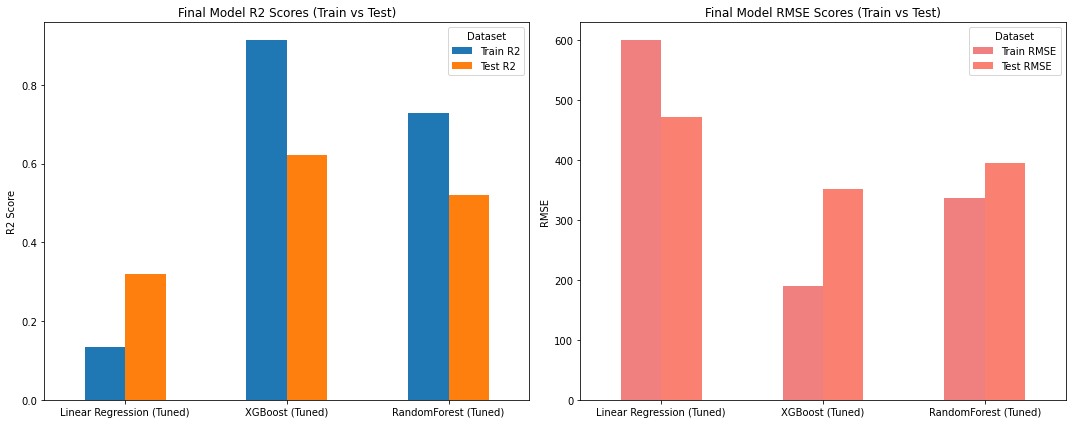

In [28]:
best_lr_model = lr_search.best_estimator_
best_xgb_model = xgb_search.best_estimator_
best_rf_model = rf_search.best_estimator_

# To store all the final results
final_results = {}

models_to_evaluate = {
    "Linear Regression (Tuned)": best_lr_model,
    "XGBoost (Tuned)": best_xgb_model,
    "RandomForest (Tuned)": best_rf_model
}

for name, model in models_to_evaluate.items():

    # Evaluate on TRAINING set
    y_train_pred_log = model.predict(X_train_selected)
    y_train_true = np.expm1(y_train) # Convert true y back from log
    y_train_pred = np.expm1(y_train_pred_log) # Convert predictions back from log

    train_r2 = r2_score(y_train_true, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))

    # Evaluate on TEST set
    y_test_pred_log = model.predict(X_test_selected)
    y_test_true = np.expm1(y_test) # Convert true y back from log
    y_test_pred = np.expm1(y_test_pred_log) # Convert predictions back from log

    test_r2 = r2_score(y_test_true, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

    final_results[name] = {
        'Train R2': round(train_r2, 4),
        'Train RMSE': round(train_rmse, 2),
        'Test R2': round(test_r2, 4),
        'Test RMSE': round(test_rmse, 2)
    }

final_results_df = pd.DataFrame.from_dict(final_results, orient='index')
print("\n--- Final Model Results ---")
display(final_results_df)

# Plots for the models
print("\n--- Final Model Plots ---")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot for R2 scores (Train vs Test)
final_results_df[['Train R2', 'Test R2']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Final Model R2 Scores (Train vs Test)')
axes[0].set_ylabel('R2 Score')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Dataset')

# Bar plot for RMSE scores (Train vs Test)
final_results_df[['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=axes[1], color=['lightcoral', 'salmon'])
axes[1].set_title('Final Model RMSE Scores (Train vs Test)')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Dataset')

plt.tight_layout()
plt.show()

Here, we see most of the Profit related features have very high feature importance. And so all our models have performed well, this evaluation of our model is not entirely corect, because in this case, because Profit and Sales are directly related features, there is significant Data Leakage.
So to prevent this from happening, we will run our models without profit and profit related featues.

# **PREDICTING WITHOUT PROFIT**

Imports complete.
Data loaded successfully.
X_train_raw shape: (6995, 21), X_test_raw shape: (2999, 21)
X_train shape after FE (without Profit): (6995, 25)
X_test shape after FE (without Profit): (2999, 25)
Preprocessor created successfully.
Fitting temporary RandomForest to find feature importances...
Done.

--- Top 10 Most Important Features (without Profit) ---


,Feature,Importance
31,Category_Office Supplies,0.216411
0,Quantity,0.128625
42,Sub-Category_Furnishings,0.075649
47,Sub-Category_Storage,0.059758
4,Product_Popularity,0.045430
2,Product_Avg_Quantity,0.043286
3,Product_Avg_Discount,0.038578
7,Customer_Avg_Discount,0.035459
6,Customer_Total_Items,0.033411
5,Customer_Avg_Quantity,0.031508



Using these 21 features for final models:
['Quantity', 'Discount', 'Product_Avg_Quantity', 'Product_Avg_Discount', 'Product_Popularity', 'Customer_Avg_Quantity', 'Customer_Total_Items', 'Customer_Avg_Discount', 'City_Avg_Quantity', 'State_Avg_Discount', 'SubCategory_Avg_Quantity', 'Shipping Time', 'Discount X Quantity', 'Month Sin', 'Month Cos', 'Day Sin', 'Day Cos', 'Segment', 'Category', 'Sub-Category', 'Order Year']

Shape of X_train_selected: (6995, 21)
Shape of X_test_selected: (2999, 21)

Final 'preprocessor_selected' created using top features.

Tuning Linear Regression...

Tuning XGBoost...
[0]	validation_0-rmse:1.57834
[1]	validation_0-rmse:1.50761
[2]	validation_0-rmse:1.46501
[3]	validation_0-rmse:1.40468
[4]	validation_0-rmse:1.35255
[5]	validation_0-rmse:1.31052
[6]	validation_0-rmse:1.27345
[7]	validation_0-rmse:1.24236
[8]	validation_0-rmse:1.21392
[9]	validation_0-rmse:1.19015
[10]	validation_0-rmse:1.17049
[11]	validation_0-rmse:1.15417
[12]	validation_0-rmse:1.13842


,Train R2,Train RMSE,Test R2,Test RMSE
XGBoost (Tuned),0.4644,471.44,0.3075,475.41
Linear Regression (Tuned),0.2285,565.83,0.2680,488.76
RandomForest (Tuned),0.3585,515.95,0.2572,492.37



--- Final Model Plots (without Profit) ---


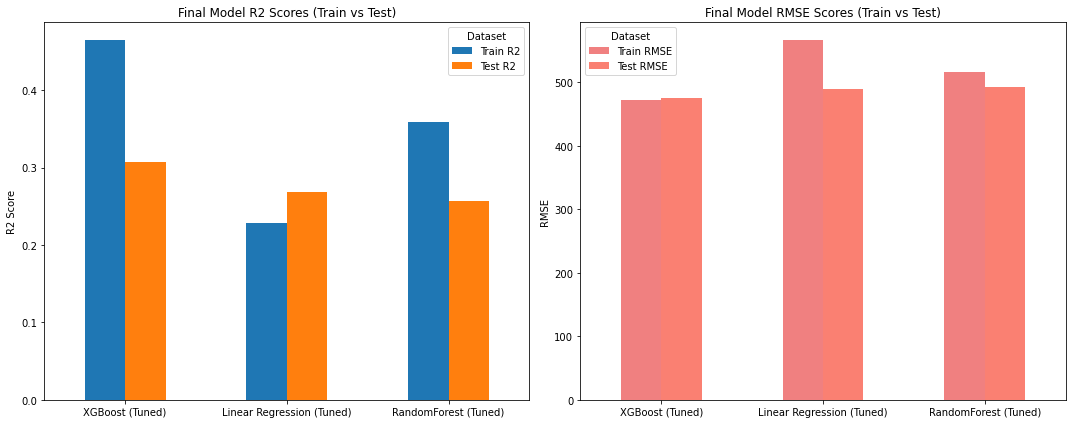

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
print("Imports complete.")

# Load the data
data = pd.read_csv(r"Sample - Superstore.csv", encoding='latin1')
print("Data loaded successfully.")

# Split the data into training and test sets FIRST
y = np.log1p(data['Sales'])  # log-transform target
X = data.copy()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50
)
print(f"X_train_raw shape: {X_train_raw.shape}, X_test_raw shape: {X_test_raw.shape}")

# Refactored Feature Engineering (WITHOUT PROFIT)
def feature_engineer_without_profit(X_train, X_test):

    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()

    # Calculate Aggregates from TRAINING data ONLY (safe features)
    product_avg_quantity = X_train_fe.groupby('Product ID')['Quantity'].mean()
    product_avg_discount = X_train_fe.groupby('Product ID')['Discount'].mean()
    product_popularity = X_train_fe.groupby('Product ID')['Quantity'].sum()

    customer_avg_quantity = X_train_fe.groupby('Customer ID')['Quantity'].mean()
    customer_total_items = X_train_fe.groupby('Customer ID')['Quantity'].sum()
    customer_avg_discount = X_train_fe.groupby('Customer ID')['Discount'].mean()

    city_avg_quantity = X_train_fe.groupby('City')['Quantity'].mean()
    state_avg_discount = X_train_fe.groupby('State')['Discount'].mean()

    subcategory_avg_quantity = X_train_fe.groupby('Sub-Category')['Quantity'].mean()

    # Global means for filling missing values
    global_avg_quantity = X_train_fe['Quantity'].mean()
    global_avg_discount = X_train_fe['Discount'].mean()

    # Map Aggregates to both Train and Test sets
    dataframes = [X_train_fe, X_test_fe]
    mappings = {
        'Product_Avg_Quantity': (product_avg_quantity, global_avg_quantity),
        'Product_Avg_Discount': (product_avg_discount, global_avg_discount),
        'Product_Popularity': (product_popularity, 0),
        'Customer_Avg_Quantity': (customer_avg_quantity, global_avg_quantity),
        'Customer_Total_Items': (customer_total_items, 0),
        'Customer_Avg_Discount': (customer_avg_discount, global_avg_discount),
        'City_Avg_Quantity': (city_avg_quantity, global_avg_quantity),
        'State_Avg_Discount': (state_avg_discount, global_avg_discount),
        'SubCategory_Avg_Quantity': (subcategory_avg_quantity, global_avg_quantity)
    }
    key_map = {
        'Product_Avg_Quantity': 'Product ID', 'Product_Avg_Discount': 'Product ID', 'Product_Popularity': 'Product ID',
        'Customer_Avg_Quantity': 'Customer ID', 'Customer_Total_Items': 'Customer ID', 'Customer_Avg_Discount': 'Customer ID',
        'City_Avg_Quantity': 'City', 'State_Avg_Discount': 'State', 'SubCategory_Avg_Quantity': 'Sub-Category'
    }

    for df in dataframes:
        for new_col, (mapper, fill_val) in mappings.items():
            map_key = key_map[new_col]
            df[new_col] = df[map_key].map(mapper).fillna(fill_val)

        # Date and Discount features (original teammate features)
        df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
        df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')
        df['Order Year'] = df['Order Date'].dt.year.astype(str)
        df['Order DayOfWeek'] = df['Order Date'].dt.dayofweek
        df['Order Month'] = df['Order Date'].dt.month
        df['Shipping Time'] = (df['Ship Date'] - df['Order Date']).dt.days
        df['Is Weekend'] = df['Order DayOfWeek'].isin([5, 6]).astype(int)
        df['Month Sin'] = np.sin(2 * np.pi * df['Order Month'] / 12)
        df['Month Cos'] = np.cos(2 * np.pi * df['Order Month'] / 12)
        df['Day Sin'] = np.sin(2 * np.pi * df['Order DayOfWeek'] / 7)
        df['Day Cos'] = np.cos(2 * np.pi * df['Order DayOfWeek'] / 7)
        df['Is Discounted'] = (df['Discount'] > 0).astype(int)
        df['Discount X Quantity'] = df['Discount'] * df['Quantity']

    # Drop Unnecessary Columns (identifiers, original columns, and now Profit/Sales)
    cols_to_drop = [
        'Row ID', 'Order ID', 'Customer Name', 'Country', 'Postal Code',
        'Product Name', 'Profit', 'Sales', # Explicitly drop Profit and Sales
        'Order Date', 'Ship Date', 'Customer ID', 'Product ID',
        'City', 'State', 'Order Month', 'Order DayOfWeek'
    ]
    X_train_fe = X_train_fe.drop(columns=cols_to_drop, errors='ignore')
    X_test_fe = X_test_fe.drop(columns=cols_to_drop, errors='ignore')

    return X_train_fe, X_test_fe

# Run the feature engineering function
X_train, X_test = feature_engineer_without_profit(X_train_raw, X_test_raw)

print(f"X_train shape after FE (without Profit): {X_train.shape}")
print(f"X_test shape after FE (without Profit): {X_test.shape}")


# Refactored Preprocessor Creation
def create_preprocessor(X_df):
    categorical_features = list(X_df.select_dtypes(include=['object']).columns)
    non_categorical_features = X_df.select_dtypes(exclude=['object']).columns
    date_features = [col for col in non_categorical_features if col in ['Day Sin', 'Day Cos', 'Month Sin', 'Month Cos']]
    binary_features = [col for col in non_categorical_features if col in ['Is Discounted', 'Is Weekend']]
    numeric_features = [col for col in non_categorical_features if col not in date_features and col not in binary_features]

    def cap_outliers(X_df_in, q_low=0.01, q_high=0.99):
        X_capped = X_df_in.copy()
        for col in X_capped.columns:
            if X_capped[col].std() > 0:
                low = X_capped[col].quantile(q_low)
                high = X_capped[col].quantile(q_high)
                X_capped[col] = np.clip(X_capped[col], low, high)
        return X_capped

    numeric_pipeline = Pipeline(steps=[
        ('cap_outliers', FunctionTransformer(cap_outliers, validate=False)),
        ('power_transform', PowerTransformer(method='yeo-johnson'))
    ])

    transformers = []
    if numeric_features: transformers.append(('num', numeric_pipeline, numeric_features))
    if date_features: transformers.append(('date', 'passthrough', date_features))
    if binary_features: transformers.append(('binary', 'passthrough', binary_features))
    if categorical_features: transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features))

    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
    return preprocessor, numeric_features, date_features, binary_features, categorical_features

# Create the preprocessor object AND capture the feature lists
preprocessor, numeric_features, date_features, binary_features, categorical_features = create_preprocessor(X_train)
print("Preprocessor created successfully.")


# Refactored Feature Selection
# Create a temporary pipeline to get feature importances
temp_rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=50, n_jobs=-1))
])

print("Fitting temporary RandomForest to find feature importances...")
temp_rf_pipe.fit(X_train, y_train)
print("Done.")

# Get feature names from the ColumnTransformer and their importances
try:
    cat_features_ohe = list(preprocessor.named_transformers_['cat'].get_feature_names(categorical_features))
    all_features = numeric_features + date_features + binary_features + cat_features_ohe
    importances = temp_rf_pipe.named_steps['regressor'].feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Select the Top 30 features (OHE features)
    top_features_ohe = list(feature_importance_df.head(30)['Feature'])

    print("\n--- Top 10 Most Important Features (without Profit) ---")
    display(feature_importance_df.head(10))

    # Get the original column names that correspond to these top features
    top_numeric_date_binary_features = [col for col in (numeric_features + date_features + binary_features) if col in top_features_ohe]
    top_cat_features = [col for col in categorical_features if any(f.startswith(f"{col}_") for f in top_features_ohe)]
    final_feature_list = top_numeric_date_binary_features + top_cat_features

    print(f"\nUsing these {len(final_feature_list)} features for final models:\n{final_feature_list}")

    # Filter X_train and X_test to only include these columns
    X_train_selected = X_train[final_feature_list]
    X_test_selected = X_test[final_feature_list]

    print(f"\nShape of X_train_selected: {X_train_selected.shape}")
    print(f"Shape of X_test_selected: {X_test_selected.shape}")

    # Create the *final* preprocessor using only the selected features
    preprocessor_selected, _, _, _, _ = create_preprocessor(X_train_selected)
    print("\nFinal 'preprocessor_selected' created using top features.")

except Exception as e:
    print(f"An error occurred during feature selection: {e}")
    print("Defaulting to use all features. Skipping feature selection.")
    X_train_selected = X_train
    X_test_selected = X_test
    preprocessor_selected = preprocessor


# Refactored Model Definition and Tuning
# Define the base regressors
lr_reg = LinearRegression()
rf_reg = RandomForestRegressor(random_state=50, n_jobs=-1)
xgb_reg = XGBRegressor(random_state=50, n_jobs=-1, early_stopping_rounds=10)

# Create pipelines
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor_selected), ('model', lr_reg)])
xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor_selected), ('model', xgb_reg)])
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor_selected), ('model', rf_reg)])

# Define parameter grids
param_grid_lr = {}
param_grid_xgb = {
    'model__max_depth': randint(3, 7),
    'model__min_child_weight': [1, 5, 10, 20],
    'model__gamma': uniform(0, 0.5),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0, 1),
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__subsample': uniform(0.7, 0.3),
    'model__colsample_bytree': uniform(0.7, 0.3)
}
param_grid_rf = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(10, 30),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['sqrt', 'log2', 0.5, 0.7]
}

# Set up RandomizedSearchCV for all three models
lr_search = RandomizedSearchCV(lr_pipe, param_distributions=param_grid_lr, n_iter=1, cv=5, scoring='r2', random_state=50, n_jobs=-1)
xgb_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_grid_xgb, n_iter=50, cv=5, scoring='r2', random_state=50, n_jobs=-1)
rf_search = RandomizedSearchCV(rf_pipe, param_distributions=param_grid_rf, n_iter=50, cv=5, scoring='r2', random_state=50, n_jobs=-1)

# Split X_train_selected for the eval_set for XGBoost
X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=50)
preprocessor_fitted = preprocessor_selected.fit(X_train_tune)
X_val_eval = preprocessor_fitted.transform(X_val_tune)
fit_params_xgb = {'model__eval_set': [(X_val_eval, y_val_tune)]}


# 5. Run the tuning for all three models
print("\nTuning Linear Regression...")
lr_search.fit(X_train_tune, y_train_tune)

print("\nTuning XGBoost...")
xgb_search.fit(X_train_tune, y_train_tune, **fit_params_xgb)

print("\nTuning RandomForest...")
rf_search.fit(X_train_tune, y_train_tune)

print("Tuning complete.")

print(f"\nBest Linear Regression CV R2 score: {lr_search.best_score_:.4f}")
print(f"Best Linear Regression params: {lr_search.best_params_}")
print(f"\nBest XGBoost CV R2 score: {xgb_search.best_score_:.4f}")
print(f"Best XGBoost params: {xgb_search.best_params_}")
print(f"\nBest RandomForest CV R2 score: {rf_search.best_score_:.4f}")
print(f"Best RandomForest params: {rf_search.best_params_}")


# Refactored Final Evaluation
# Get the best estimators from the search
best_lr_model = lr_search.best_estimator_
best_xgb_model = xgb_search.best_estimator_
best_rf_model = rf_search.best_estimator_

# Create a dictionary to store final results
final_results = {}

# Evaluate the best models
models_to_evaluate = {
    "Linear Regression (Tuned)": best_lr_model,
    "XGBoost (Tuned)": best_xgb_model,
    "RandomForest (Tuned)": best_rf_model
}

for name, model in models_to_evaluate.items():
    y_train_pred_log = model.predict(X_train_selected)
    y_test_pred_log = model.predict(X_test_selected)

    y_train_true = np.expm1(y_train)
    y_train_pred = np.expm1(y_train_pred_log)
    y_test_true = np.expm1(y_test)
    y_test_pred = np.expm1(y_test_pred_log)

    final_results[name] = {
        'Train R2': round(r2_score(y_train_true, y_train_pred), 4),
        'Train RMSE': round(np.sqrt(mean_squared_error(y_train_true, y_train_pred)), 2),
        'Test R2': round(r2_score(y_test_true, y_test_pred), 4),
        'Test RMSE': round(np.sqrt(mean_squared_error(y_test_true, y_test_pred)), 2)
    }

final_results_df = pd.DataFrame.from_dict(final_results, orient='index').sort_values(by='Test R2', ascending=False)
print("\n--- Final Model Results (without Profit) ---")
display(final_results_df)


# Refactored Plots
print("\n--- Final Model Plots (without Profit) ---")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

final_results_df[['Train R2', 'Test R2']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Final Model R2 Scores (Train vs Test)')
axes[0].set_ylabel('R2 Score')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Dataset')

final_results_df[['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=axes[1], color=['lightcoral', 'salmon'])
axes[1].set_title('Final Model RMSE Scores (Train vs Test)')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Dataset')

plt.tight_layout()
plt.show()

Since Random Forest and XGBoost has outperformed Linear Regression, we will consider the latter two as our base models and perform feature interpretation and data visualisation accordingly.

# **FEATURE INTERPRETATION**

## SHAP Analysis

In [38]:
# Prepare Data and Models for SHAP
import shap
import warnings
import pandas as pd
# Assuming X_train_selected is available and is a pandas DataFrame

print("SHAP imported successfully.")

# Extract the fitted preprocessor from one of the best models
try:
    preprocessor = best_xgb_model.named_steps['preprocessor']
    print("Preprocessor extracted.")
except NameError:
    print("Error: 'best_xgb_model' not found. Please run the tuning cells first.")
    raise # Re-raise to stop execution if model is missing

rf_model_only = best_rf_model.named_steps['model']
xgb_model_only = best_xgb_model.named_steps['model']
print("Models extracted from pipelines.")

numeric_pipe = preprocessor.named_transformers_['num']
# Applying the previous fix for the FunctionTransformer
numeric_pipe.named_steps['cap_outliers'].get_feature_names = 'one-to-one'
print("Applied fix to FunctionTransformer 'cap_outliers'.")

# --- START OF FIX: Manually get and combine feature names ---

# 1. Define your ORIGINAL numeric column names. 
# Replace the placeholder below with the actual list of column names used in your 'num' pipeline.
# Example assumption: all numeric columns in X_train_selected were used.
numeric_cols = list(X_train_selected.select_dtypes(include=['number']).columns)

# 2. Get feature names from the 'cat' (OneHotEncoder) transformer
try:
    # Try the newer method first (get_feature_names_out)
    cat_features_out = preprocessor.named_transformers_['cat'].get_feature_names_out()
except AttributeError:
    # Fallback to the older method (get_feature_names)
    cat_features_out = preprocessor.named_transformers_['cat'].get_feature_names()

# 3. Combine the numeric (original names) and categorical (OHE names) feature lists
feature_names = list(numeric_cols) + list(cat_features_out)

print(f"Found {len(feature_names)} features after processing.")
# --- END OF FIX ---


# Create the processed DataFrames for SHAP
print("Processing data for SHAP...")
X_train_processed = preprocessor.transform(X_train_selected)
X_test_processed = preprocessor.transform(X_test_selected)

# Convert to dense DataFrames
if hasattr(X_train_processed, "toarray"):
    X_train_processed_df = pd.DataFrame(X_train_processed.toarray(), columns=feature_names)
    X_test_processed_df = pd.DataFrame(X_test_processed.toarray(), columns=feature_names)
else:
    X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Create background data and test sample
background_data = shap.sample(X_train_processed_df, 100, random_state=50)

X_test_sample = shap.sample(X_test_processed_df, 200, random_state=50)

print("Data preparation for SHAP is complete.")

SHAP imported successfully.
Preprocessor extracted.
Models extracted from pipelines.
Applied fix to FunctionTransformer 'cap_outliers'.
Found 44 features after processing.
Processing data for SHAP...
Data preparation for SHAP is complete.


### For RandomForest

--- SHAP Analysis for: RandomForest (Tuned) ---
Running KernelExplainer


  0%|          | 0/200 [00:00<?, ?it/s]

SHAP values calculated.

Beeswarm Plot (Importance & Impact of Features):
Saved rf_beeswarm_plot.png


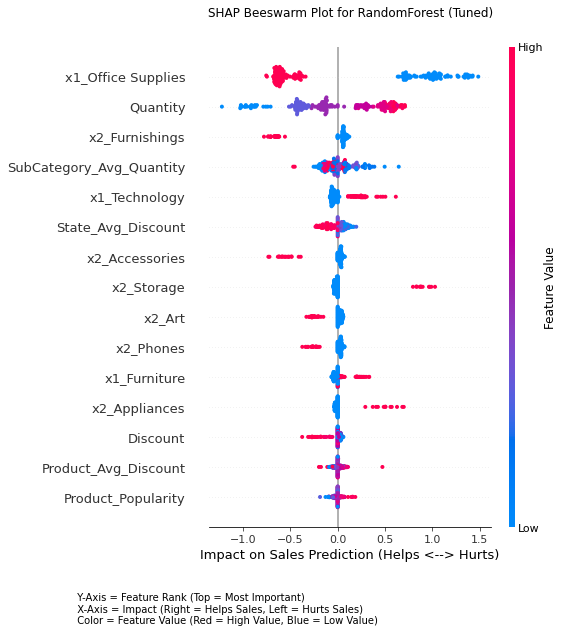


Dependence Plot for 'Discount':
Saved rf_dependence_plot.png


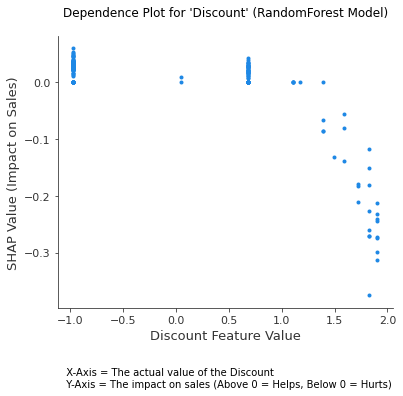

Wall time: 13min 39s


In [39]:
%%time
# SHAP Analysis for RandomForest (KernelExplainer

print(f"--- SHAP Analysis for: RandomForest (Tuned) ---")

# Create the KernelExplainer
print("Running KernelExplainer")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rf_explainer = shap.KernelExplainer(rf_model_only.predict, background_data)

# Calculate SHAP values for our test sample
rf_shap_values = rf_explainer.shap_values(X_test_sample)
print("SHAP values calculated.")

# Create a map of ugly feature names to pretty names for plotting
feature_name_map = {
    'num__Discount': 'Discount',
    'num__Shipping Time': 'Shipping Time',
    'num__Discount X Quantity': 'Discount x Quantity',
    'num__Customer Total Items': 'Customer Total Items',
    'num__Customer Avg Discount': 'Customer Avg Discount',
    'num__Product Popularity': 'Product Popularity',
    'num__Product Unique Customers': 'Product Unique Customers',
    'date__Day Sin': 'Day Sin', 'date__Day Cos': 'Day Cos',
    'date__Month Sin': 'Month Sin', 'date__Month Cos': 'Month Cos',
    'binary__Is Discounted': 'Is Discounted',
    'binary__Is Weekend': 'Is Weekend',
    'cat__Ship Mode_First Class': 'Ship Mode: First Class',
    'cat__Ship Mode_Same Day': 'Ship Mode: Same Day',
    'cat__Ship Mode_Second Class': 'Ship Mode: Second Class',
    'cat__Ship Mode_Standard Class': 'Ship Mode: Standard Class',
    'cat__Segment_Consumer': 'Segment: Consumer',
    'cat__Segment_Corporate': 'Segment: Corporate',
    'cat__Segment_Home Office': 'Segment: Home Office',
    'cat__Region_Central': 'Region: Central',
    'cat__Region_East': 'Region: East',
    'cat__Region_South': 'Region: South',
    'cat__Region_West': 'Region: West',
    'cat__Category_Furniture': 'Category: Furniture',
    'cat__Category_Office Supplies': 'Category: Office Supplies',
    'cat__Category_Technology': 'Category: Technology',
    'cat__Sub-Category_Accessories': 'Sub-Category: Accessories',
    'cat__Sub-Category_Appliances': 'Sub-Category: Appliances',
    'cat__Sub-Category_Art': 'Sub-Category: Art',
    'cat__Sub-Category_Binders': 'Sub-Category: Binders',
    'cat__Sub-Category_Bookcases': 'Sub-Category: Bookcases',
    'cat__Sub-Category_Chairs': 'Sub-Category: Chairs',
    'cat__Sub-Category_Copiers': 'Sub-Category: Copiers',
    'cat__Sub-Category_Envelopes': 'Sub-Category: Envelopes',
    'cat__Sub-Category_Fasteners': 'Sub-Category: Fasteners',
    'cat__Sub-Category_Furnishings': 'Sub-Category: Furnishings',
    'cat__Sub-Category_Labels': 'Sub-Category: Labels',
    'cat__Sub-Category_Machines': 'Sub-Category: Machines',
    'cat__Sub-Category_Paper': 'Sub-Category: Paper',
    'cat__Sub-Category_Phones': 'Sub-Category: Phones',
    'cat__Sub-Category_Storage': 'Sub-Category: Storage',
    'cat__Sub-Category_Supplies': 'Sub-Category: Supplies',
    'cat__Sub-Category_Tables': 'Sub-Category: Tables',
    'cat__Order Year_2014': 'Year: 2014',
    'cat__Order Year_2015': 'Year: 2015',
    'cat__Order Year_2016': 'Year: 2016',
    'cat__Order Year_2017': 'Year: 2017'
}

# Create a copy of the test sample with renamed columns for plotting
X_test_sample_renamed_rf = X_test_sample.copy()
X_test_sample_renamed_rf.columns = X_test_sample_renamed_rf.columns.map(lambda x: feature_name_map.get(x, x))

# Plot the Beeswarm Plot
print("\nBeeswarm Plot (Importance & Impact of Features):")
shap.summary_plot(rf_shap_values, X_test_sample_renamed_rf, plot_type="dot", max_display=15, show=False)

fig = plt.gcf()
ax = plt.gca()
plt.title(f"SHAP Beeswarm Plot for RandomForest (Tuned)", y=1.05)
ax.set_xlabel("Impact on Sales Prediction (Helps <--> Hurts)")
cb = fig.axes[-1]
cb.set_ylabel("Feature Value")
cb.set_yticks([ax.get_ylim()[0], ax.get_ylim()[1]])
cb.set_yticklabels(["Low", "High"])
plot_text = (
    "  Y-Axis = Feature Rank (Top = Most Important)\n"
    "  X-Axis = Impact (Right = Helps Sales, Left = Hurts Sales)\n"
    "  Color = Feature Value (Red = High Value, Blue = Low Value)"
)
fig.text(0.13, -0.1, plot_text, horizontalalignment='left', verticalalignment='bottom', wrap=True)

plt.savefig("rf_beeswarm_plot.png", bbox_inches='tight')
print("Saved rf_beeswarm_plot.png")
plt.show()

# 6. Plot the Dependence Plot for 'Discount'
print(f"\nDependence Plot for 'Discount':")
shap.dependence_plot(
    'Discount',
    rf_shap_values,
    X_test_sample_renamed_rf,
    interaction_index=None,
    show=False
)

fig_dep = plt.gcf()
ax_dep = plt.gca()
plt.title(f"Dependence Plot for 'Discount' (RandomForest Model)", y=1.05)
ax_dep.set_xlabel("Discount Feature Value")
ax_dep.set_ylabel("SHAP Value (Impact on Sales)")
dep_explanation = (
    "  X-Axis = The actual value of the Discount\n"
    "  Y-Axis = The impact on sales (Above 0 = Helps, Below 0 = Hurts)"
)
fig_dep.text(0.13, -0.1, dep_explanation, horizontalalignment='left', verticalalignment='bottom', wrap=True)

plt.savefig("rf_dependence_plot.png", bbox_inches='tight')
print("Saved rf_dependence_plot.png")
plt.show()

### For XGBoost

--- SHAP Analysis for: XGBoost (Tuned) ---
...Running KernelExplainer (this may take a few minutes)...


  0%|          | 0/200 [00:00<?, ?it/s]

SHAP values calculated.

Beeswarm Plot (Importance & Impact of Features):
Saved xgb_beeswarm_plot.png


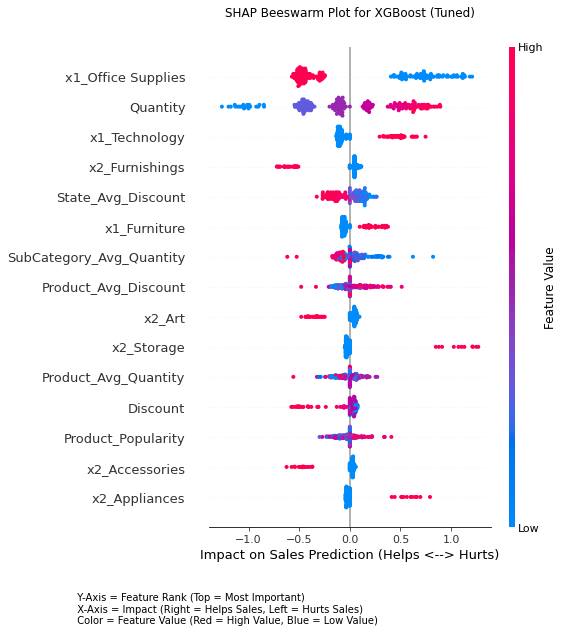


Dependence Plot for 'Discount':
Saved xgb_dependence_plot.png


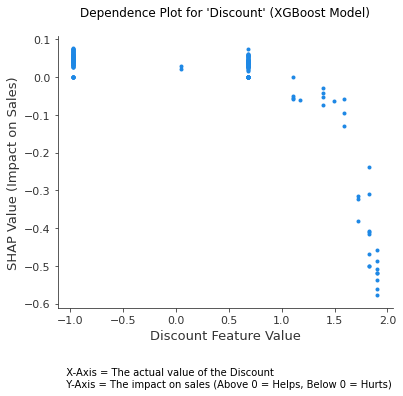

Wall time: 7min 38s


In [40]:
%%time
# SHAP Analysis for XGBoost (KernelExplainer)
print(f"--- SHAP Analysis for: XGBoost (Tuned) ---")

# Create the KernelExplainer
print("...Running KernelExplainer (this may take a few minutes)...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb_explainer = shap.KernelExplainer(xgb_model_only.predict, background_data)

# Calculate SHAP values for our test sample
xgb_shap_values = xgb_explainer.shap_values(X_test_sample)
print("SHAP values calculated.")

# Create a map of ugly feature names to pretty names for plotting
feature_name_map = {
    'num__Discount': 'Discount',
    'num__Shipping Time': 'Shipping Time',
    'num__Discount X Quantity': 'Discount x Quantity',
    'num__Customer Total Items': 'Customer Total Items',
    'num__Customer Avg Discount': 'Customer Avg Discount',
    'num__Product Popularity': 'Product Popularity',
    'num__Product Unique Customers': 'Product Unique Customers',
    'date__Day Sin': 'Day Sin', 'date__Day Cos': 'Day Cos',
    'date__Month Sin': 'Month Sin', 'date__Month Cos': 'Month Cos',
    'binary__Is Discounted': 'Is Discounted',
    'binary__Is Weekend': 'Is Weekend',
    'cat__Ship Mode_First Class': 'Ship Mode: First Class',
    'cat__Ship Mode_Same Day': 'Ship Mode: Same Day',
    'cat__Ship Mode_Second Class': 'Ship Mode: Second Class',
    'cat__Ship Mode_Standard Class': 'Ship Mode: Standard Class',
    'cat__Segment_Consumer': 'Segment: Consumer',
    'cat__Segment_Corporate': 'Segment: Corporate',
    'cat__Segment_Home Office': 'Segment: Home Office',
    'cat__Region_Central': 'Region: Central',
    'cat__Region_East': 'Region: East',
    'cat__Region_South': 'Region: South',
    'cat__Region_West': 'Region: West',
    'cat__Category_Furniture': 'Category: Furniture',
    'cat__Category_Office Supplies': 'Category: Office Supplies',
    'cat__Category_Technology': 'Category: Technology',
    'cat__Sub-Category_Accessories': 'Sub-Category: Accessories',
    'cat__Sub-Category_Appliances': 'Sub-Category: Appliances',
    'cat__Sub-Category_Art': 'Sub-Category: Art',
    'cat__Sub-Category_Binders': 'Sub-Category: Binders',
    'cat__Sub-Category_Bookcases': 'Sub-Category: Bookcases',
    'cat__Sub-Category_Chairs': 'Sub-Category: Chairs',
    'cat__Sub-Category_Copiers': 'Sub-Category: Copiers',
    'cat__Sub-Category_Envelopes': 'Sub-Category: Envelopes',
    'cat__Sub-Category_Fasteners': 'Sub-Category: Fasteners',
    'cat__Sub-Category_Furnishings': 'Sub-Category: Furnishings',
    'cat__Sub-Category_Labels': 'Sub-Category: Labels',
    'cat__Sub-Category_Machines': 'Sub-Category: Machines',
    'cat__Sub-Category_Paper': 'Sub-Category: Paper',
    'cat__Sub-Category_Phones': 'Sub-Category: Phones',
    'cat__Sub-Category_Storage': 'Sub-Category: Storage',
    'cat__Sub-Category_Supplies': 'Sub-Category: Supplies',
    'cat__Sub-Category_Tables': 'Sub-Category: Tables',
    'cat__Order Year_2014': 'Year: 2014',
    'cat__Order Year_2015': 'Year: 2015',
    'cat__Order Year_2016': 'Year: 2016',
    'cat__Order Year_2017': 'Year: 2017'
}

# Create a copy of the test sample with renamed columns for plotting
X_test_sample_renamed_xgb = X_test_sample.copy()
X_test_sample_renamed_xgb.columns = X_test_sample_renamed_xgb.columns.map(lambda x: feature_name_map.get(x, x))

# Plot the Beeswarm Plot
print("\nBeeswarm Plot (Importance & Impact of Features):")
shap.summary_plot(xgb_shap_values, X_test_sample_renamed_xgb, plot_type="dot", max_display=15, show=False)

fig = plt.gcf()
ax = plt.gca()
plt.title(f"SHAP Beeswarm Plot for XGBoost (Tuned)", y=1.05)
ax.set_xlabel("Impact on Sales Prediction (Helps <--> Hurts)")
cb = fig.axes[-1]
cb.set_ylabel("Feature Value")
cb.set_yticks([ax.get_ylim()[0], ax.get_ylim()[1]])
cb.set_yticklabels(["Low", "High"])
plot_text = (
    "  Y-Axis = Feature Rank (Top = Most Important)\n"
    "  X-Axis = Impact (Right = Helps Sales, Left = Hurts Sales)\n"
    "  Color = Feature Value (Red = High Value, Blue = Low Value)"
)
fig.text(0.13, -0.1, plot_text, horizontalalignment='left', verticalalignment='bottom', wrap=True)

plt.savefig("xgb_beeswarm_plot.png", bbox_inches='tight')
print("Saved xgb_beeswarm_plot.png")
plt.show()

# Plot the Dependence Plot for 'Discount'
print(f"\nDependence Plot for 'Discount':")
shap.dependence_plot(
    'Discount',
    xgb_shap_values,
    X_test_sample_renamed_xgb,
    interaction_index=None,
    show=False
)

fig_dep = plt.gcf()
ax_dep = plt.gca()
plt.title(f"Dependence Plot for 'Discount' (XGBoost Model)", y=1.05)
ax_dep.set_xlabel("Discount Feature Value")
ax_dep.set_ylabel("SHAP Value (Impact on Sales)")
dep_explanation = (
    "  X-Axis = The actual value of the Discount\n"
    "  Y-Axis = The impact on sales (Above 0 = Helps, Below 0 = Hurts)"
)
fig_dep.text(0.13, -0.1, dep_explanation, horizontalalignment='left', verticalalignment='bottom', wrap=True)

plt.savefig("xgb_dependence_plot.png", bbox_inches='tight')
print("Saved xgb_dependence_plot.png")
plt.show()

## Permutation Importance method

### XGBoost




In [41]:
from sklearn.inspection import permutation_importance

print("Calculating Permutation Importance...")

best_model = best_xgb_model
X_test_perm = X_test_selected
y_test_perm = y_test

# Permutation importance
perm_importance = permutation_importance(
  best_model,
  X_test_perm,
  y_test_perm,
  n_repeats=10,
  random_state=50,
  n_jobs=-1
)

# Store results in a DataFrame
feature_names = X_test_perm.columns
perm_importance_df = pd.DataFrame({
  'Feature': feature_names,
  'Importance_mean': perm_importance.importances_mean,
  'Importance_std': perm_importance.importances_std
})

perm_importance_df = perm_importance_df.sort_values(by='Importance_mean', ascending=False)

print("Permutation Importance Calculation Complete.")

print("\n--- Permutation Importance Results (Mean Importance) ---")
display(perm_importance_df)


Calculating Permutation Importance...
Permutation Importance Calculation Complete.

--- Permutation Importance Results (Mean Importance) ---


,Feature,Importance_mean,Importance_std
18,Category,0.633123,0.008606
19,Sub-Category,0.246407,0.004555
0,Quantity,0.229426,0.005306
3,Product_Avg_Discount,0.058072,0.002732
4,Product_Popularity,0.053774,0.002838
2,Product_Avg_Quantity,0.045769,0.003029
10,SubCategory_Avg_Quantity,0.041675,0.002366
1,Discount,0.023323,0.001797
9,State_Avg_Discount,0.018977,0.003164
8,City_Avg_Quantity,0.001743,0.000476


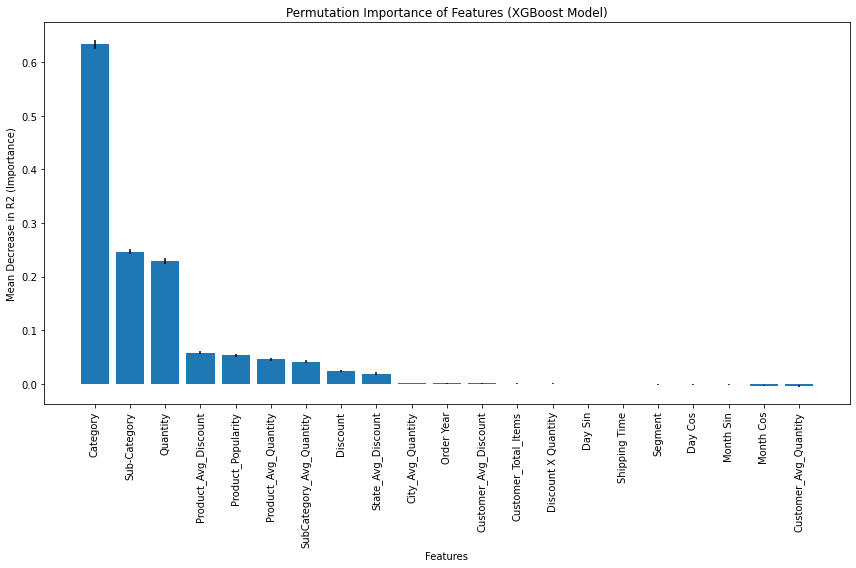

In [42]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.bar(perm_importance_df['Feature'], perm_importance_df['Importance_mean'], yerr=perm_importance_df['Importance_std'])
plt.xticks(rotation=90)
plt.title('Permutation Importance of Features (XGBoost Model)')
plt.xlabel('Features')
plt.ylabel('Mean Decrease in R2 (Importance)')
plt.tight_layout()
plt.show()

### RandomForest

In [43]:
from sklearn.inspection import permutation_importance

print("Calculating Permutation Importance for Random Forest...")

best_model = best_rf_model
X_test_perm = X_test_selected
y_test_perm = y_test

perm_importance = permutation_importance(
    best_model,
    X_test_perm,
    y_test_perm,
    n_repeats=10,
    random_state=50,
    n_jobs=-1
)

# Store results in a DataFrame
feature_names = X_test_perm.columns
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_mean': perm_importance.importances_mean,
    'Importance_std': perm_importance.importances_std
})

perm_importance_df = perm_importance_df.sort_values(by='Importance_mean', ascending=False)

print("Permutation Importance Calculation Complete for Random Forest.")

print("\n--- Permutation Importance Results (Mean Importance) for Random Forest ---")
display(perm_importance_df)


Calculating Permutation Importance for Random Forest...
Permutation Importance Calculation Complete for Random Forest.

--- Permutation Importance Results (Mean Importance) for Random Forest ---


,Feature,Importance_mean,Importance_std
18,Category,0.807286,0.009340
19,Sub-Category,0.220650,0.005047
0,Quantity,0.197041,0.005132
10,SubCategory_Avg_Quantity,0.057021,0.002742
4,Product_Popularity,0.017839,0.001555
2,Product_Avg_Quantity,0.016264,0.001439
9,State_Avg_Discount,0.015857,0.002649
3,Product_Avg_Discount,0.014438,0.001813
1,Discount,0.012481,0.001114
12,Discount X Quantity,0.000885,0.000865


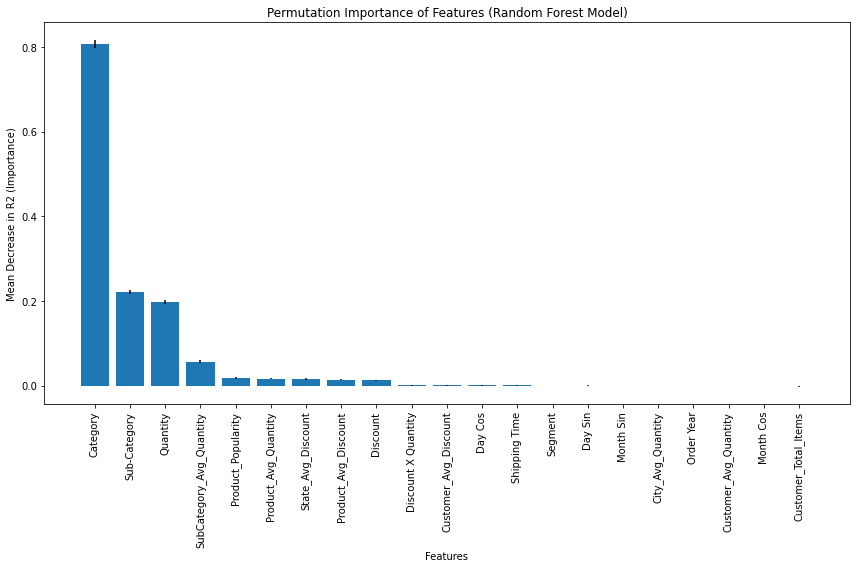

In [44]:
 # Plot the results
plt.figure(figsize=(12, 8))
plt.bar(perm_importance_df['Feature'], perm_importance_df['Importance_mean'], yerr=perm_importance_df['Importance_std'])
plt.xticks(rotation=90)
plt.title('Permutation Importance of Features (Random Forest Model)')
plt.xlabel('Features')
plt.ylabel('Mean Decrease in R2 (Importance)')
plt.tight_layout()
plt.show()

#**DASHBOARD SUMMARY**

## With Profit

### Random Forest


--- Visualizations for Random Forest Model (With Profit) ---

Displaying rf_residuals_vs_popularity plot (With Profit).


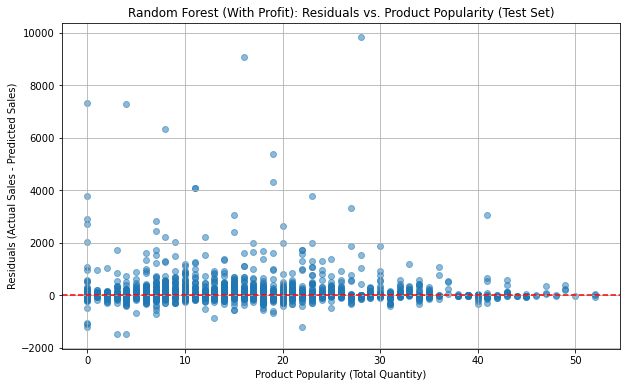


--- Inference: Residuals vs. Product Popularity ---
This plot shows if there is a pattern in the errors (residuals) of the model's predictions based on the popularity of a product.
Ideally, the points should be randomly scattered around the zero line.

Displaying rf_predicted_actual_by_category plot (With Profit).


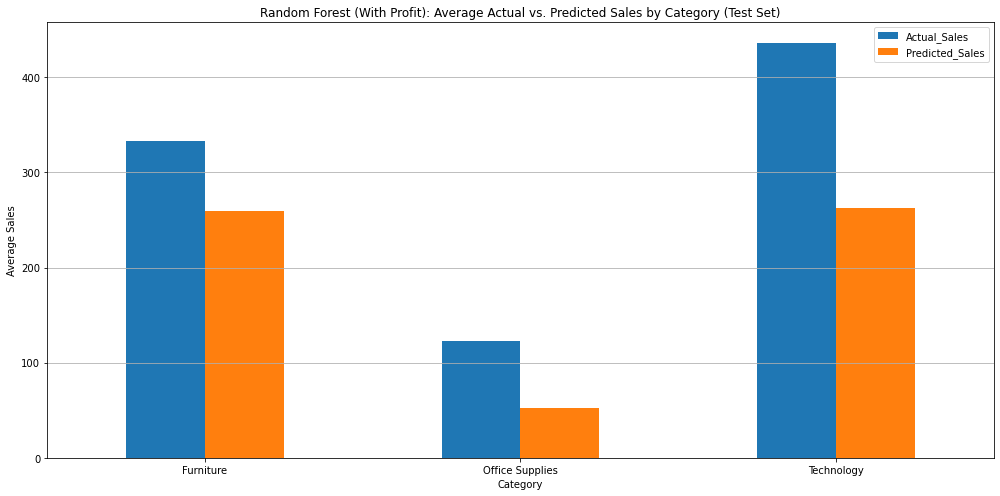


--- Inference: Predicted vs. Actual by Category ---
This bar plot compares the average actual sales to the average predicted sales for each product category.
Ideally, the 'Predicted_Sales' bar should be close to the 'Actual_Sales' bar.

Displaying rf_predicted_sales_distribution plot (With Profit).


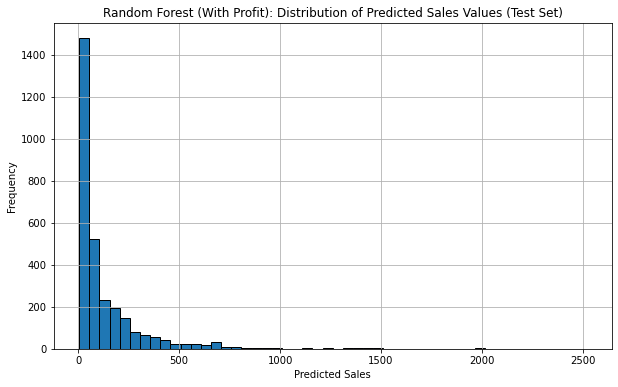


--- Inference: Distribution of Predicted Sales Values ---
This histogram shows the frequency distribution of the model's predicted sales values.

Displaying rf_residuals_vs_predicted plot (With Profit).


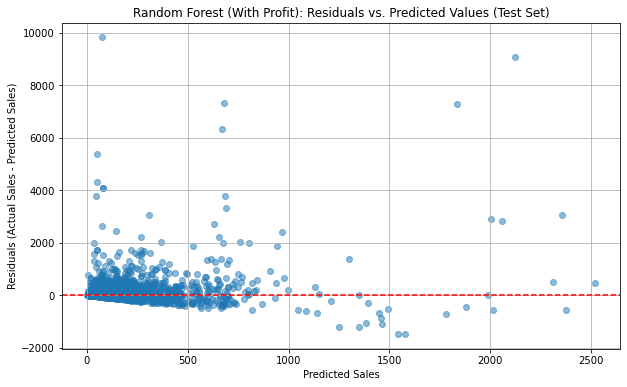


--- Inference: Residuals vs. Predicted Values ---
Randomly scattered points around the zero line are desired. Patterns here (like a funnel shape) suggest heteroscedasticity.

Displaying rf_residuals_distribution plot (With Profit).


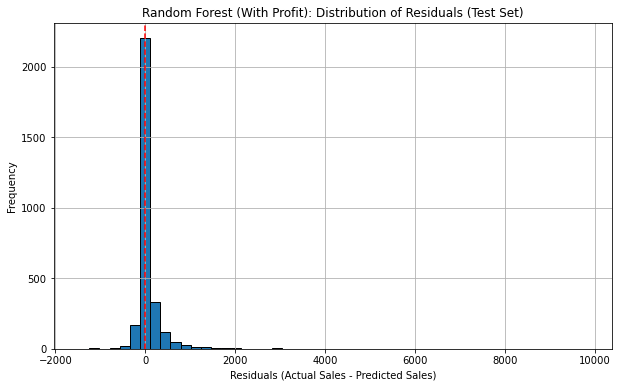


--- Inference: Distribution of Residuals ---
For a good model, the residuals should ideally be normally distributed around zero.

Displaying rf_predicted_actual_scatter plot (With Profit).


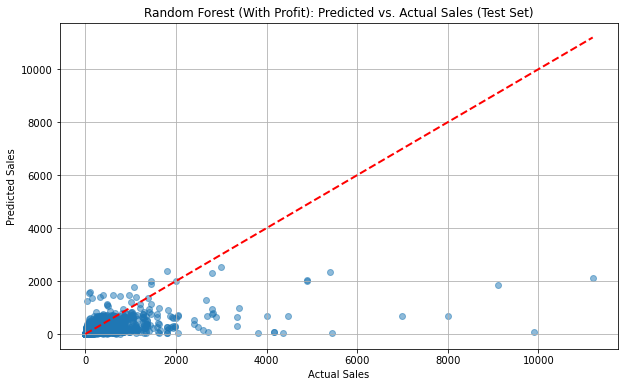


--- Inference: Predicted vs. Actual Sales Scatter Plot ---
Points should ideally lie close to the red dashed line.

'final_results_df' from 'With Profit' analysis not found or does not contain 'Random Forest (Tuned)'. Skipping Model Evaluation Metrics Visualization.

Displaying rf_feature_importance plot (With Profit).


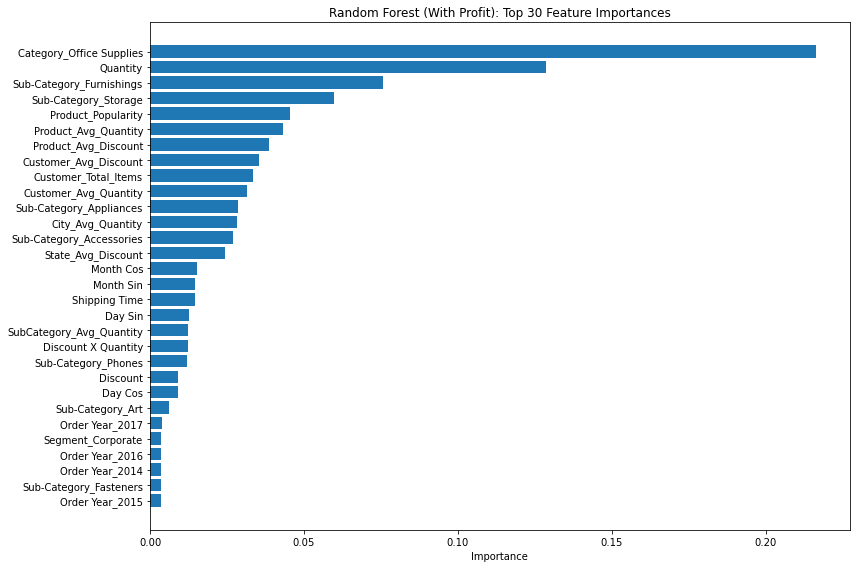


--- Detailed Inference from Feature Importance ---
The top 30 features show the estimated contribution of each feature to the model's predictions.

The most important feature is 'Category_Office Supplies', contributing significantly to the model's ability to predict sales.

Other highly important features include:
- 'Quantity' (Importance: 0.1286)
- 'Sub-Category_Furnishings' (Importance: 0.0756)
- 'Sub-Category_Storage' (Importance: 0.0598)
- 'Product_Popularity' (Importance: 0.0454)
- 'Product_Avg_Quantity' (Importance: 0.0433)

These features likely have a strong correlation with sales and are crucial for the model's performance.

Random Forest Visualization complete (With Profit).


In [45]:
# Consolidating visualizations for Random Forest Model (With Profit)

print("\n--- Visualizations for Random Forest Model (With Profit) ---")

try:
    rf_model = best_rf_model

    y_test_pred_log_rf = rf_model.predict(X_test_selected)
    y_test_true_rf = np.expm1(y_test)
    y_test_pred_rf = np.expm1(y_test_pred_log_rf)

    residuals_rf = y_test_true_rf - y_test_pred_rf

    plot_data_rf = X_test_selected.copy()
    plot_data_rf['Actual_Sales'] = y_test_true_rf
    plot_data_rf['Predicted_Sales'] = y_test_pred_rf
    plot_data_rf['Residuals'] = residuals_rf


    if 'Product_Popularity' in plot_data_rf.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(plot_data_rf['Product_Popularity'], plot_data_rf['Residuals'], alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Random Forest (With Profit): Residuals vs. Product Popularity (Test Set)')
        plt.xlabel('Product Popularity (Total Quantity)')
        plt.ylabel('Residuals (Actual Sales - Predicted Sales)')
        plt.grid(True)
        print("\nDisplaying rf_residuals_vs_popularity plot (With Profit).")
        plt.show()
        print("\n--- Inference: Residuals vs. Product Popularity ---")
        print("This plot shows if there is a pattern in the errors (residuals) of the model's predictions based on the popularity of a product.")
        print("Ideally, the points should be randomly scattered around the zero line.")

    if 'Category' in plot_data_rf.columns:
        plt.figure(figsize=(14, 7))
        category_agg_rf = plot_data_rf.groupby('Category')[['Actual_Sales', 'Predicted_Sales']].mean().reset_index()
        category_agg_rf.plot(x='Category', y=['Actual_Sales', 'Predicted_Sales'], kind='bar', ax=plt.gca())
        plt.title('Random Forest (With Profit): Average Actual vs. Predicted Sales by Category (Test Set)')
        plt.xlabel('Category')
        plt.ylabel('Average Sales')
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.tight_layout()
        print("\nDisplaying rf_predicted_actual_by_category plot (With Profit).")
        plt.show()
        print("\n--- Inference: Predicted vs. Actual by Category ---")
        print("This bar plot compares the average actual sales to the average predicted sales for each product category.")
        print("Ideally, the 'Predicted_Sales' bar should be close to the 'Actual_Sales' bar.")

    plt.figure(figsize=(10, 6))
    plt.hist(y_test_pred_rf, bins=50, edgecolor='black')
    plt.title('Random Forest (With Profit): Distribution of Predicted Sales Values (Test Set)')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Frequency')
    plt.grid(True)
    print("\nDisplaying rf_predicted_sales_distribution plot (With Profit).")
    plt.show()
    print("\n--- Inference: Distribution of Predicted Sales Values ---")
    print("This histogram shows the frequency distribution of the model's predicted sales values.")

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_pred_rf, residuals_rf, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Random Forest (With Profit): Residuals vs. Predicted Values (Test Set)')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residuals (Actual Sales - Predicted Sales)')
    plt.grid(True)
    print("\nDisplaying rf_residuals_vs_predicted plot (With Profit).")
    plt.show()
    print("\n--- Inference: Residuals vs. Predicted Values ---")
    print("Randomly scattered points around the zero line are desired. Patterns here (like a funnel shape) suggest heteroscedasticity.")

    plt.figure(figsize=(10, 6))
    plt.hist(residuals_rf, bins=50, edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Random Forest (With Profit): Distribution of Residuals (Test Set)')
    plt.xlabel('Residuals (Actual Sales - Predicted Sales)')
    plt.ylabel('Frequency')
    plt.grid(True)
    print("\nDisplaying rf_residuals_distribution plot (With Profit).")
    plt.show()
    print("\n--- Inference: Distribution of Residuals ---")
    print("For a good model, the residuals should ideally be normally distributed around zero.")

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_true_rf, y_test_pred_rf, alpha=0.5)
    plt.plot([y_test_true_rf.min(), y_test_true_rf.max()], [y_test_true_rf.min(), y_test_true_rf.max()], 'r--', lw=2)
    plt.title('Random Forest (With Profit): Predicted vs. Actual Sales (Test Set)')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.grid(True)
    print("\nDisplaying rf_predicted_actual_scatter plot (With Profit).")
    plt.show()
    print("\n--- Inference: Predicted vs. Actual Sales Scatter Plot ---")
    print("Points should ideally lie close to the red dashed line.")

    if 'final_results_df' in locals() and "Random Forest (Tuned)" in final_results_df.index:
        print("\n--- Model Evaluation Metrics (With Profit) ---")
        fig, ax1 = plt.subplots(figsize=(12, 6))

        final_results_df.loc[["Random Forest (Tuned)"]][['Train R2', 'Test R2']].plot(kind='bar', ax=ax1, position=0, width=0.4, color='skyblue')
        ax2 = final_results_df.loc[["Random Forest (Tuned)"]][['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=ax1, secondary_y=True, position=1, width=0.4, color='lightcoral')

        ax1.set_title('Random Forest (With Profit): Model Evaluation Metrics (R2 and RMSE)')
        ax1.set_xlabel('Model')
        ax1.set_ylabel('R2 Score')
        ax2.set_ylabel('RMSE')

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        plt.xticks(rotation=0)
        ax1.grid(axis='y')
        plt.tight_layout()
        print("Displaying rf_model_evaluation_metrics plot (With Profit).")
        plt.show()
        print("\n--- Inference: Model Evaluation Metrics ---")
        print("Comparing train and test scores helps identify overfitting.")
    else:
        print("\n'final_results_df' from 'With Profit' analysis not found or does not contain 'Random Forest (Tuned)'. Skipping Model Evaluation Metrics Visualization.")

    if 'feature_importance_df' in locals():
        plt.figure(figsize=(12, 8))
        top_n = 30
        feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False).head(top_n)

        plt.barh(feature_importance_df_sorted['Feature'], feature_importance_df_sorted['Importance'])
        plt.xlabel('Importance')
        plt.title(f'Random Forest (With Profit): Top {top_n} Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        print("\nDisplaying rf_feature_importance plot (With Profit).")
        plt.show()

        print("\n--- Detailed Inference from Feature Importance ---")
        print(f"The top {top_n} features show the estimated contribution of each feature to the model's predictions.")

        top_feature_names = feature_importance_df_sorted['Feature'].tolist()
        if top_feature_names:
            print(f"\nThe most important feature is '{top_feature_names[0]}', contributing significantly to the model's ability to predict sales.")
            if len(top_feature_names) > 1:
                print("\nOther highly important features include:")
                for i in range(1, min(top_n, 6)):
                    feature = top_feature_names[i]
                    importance = feature_importance_df_sorted.iloc[i]['Importance']
                    print(f"- '{feature}' (Importance: {importance:.4f})")

            print("\nThese features likely have a strong correlation with sales and are crucial for the model's performance.")
        else:
            print("Could not retrieve top feature names for detailed inference.")

    else:
        print("\n'feature_importance_df' from 'With Profit' analysis not found. Skipping Feature Importance plot.")

    print("\nRandom Forest Visualization complete (With Profit).")

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'With Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Random Forest visualization (With Profit): {e}")

### XGBoost


--- Visualizations for XGBoost Model (With Profit) ---

Displaying xgb_residuals_vs_popularity plot (With Profit).


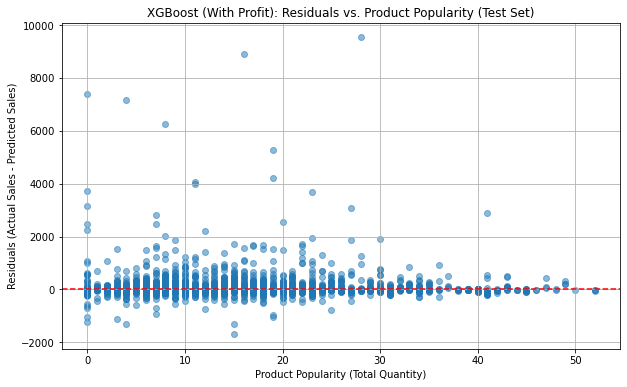


--- Inference: Residuals vs. Product Popularity ---
This plot shows if there is a pattern in the errors (residuals) of the model's predictions based on the popularity of a product.
Ideally, the points should be randomly scattered around the zero line.

Displaying xgb_predicted_actual_by_category plot (With Profit).


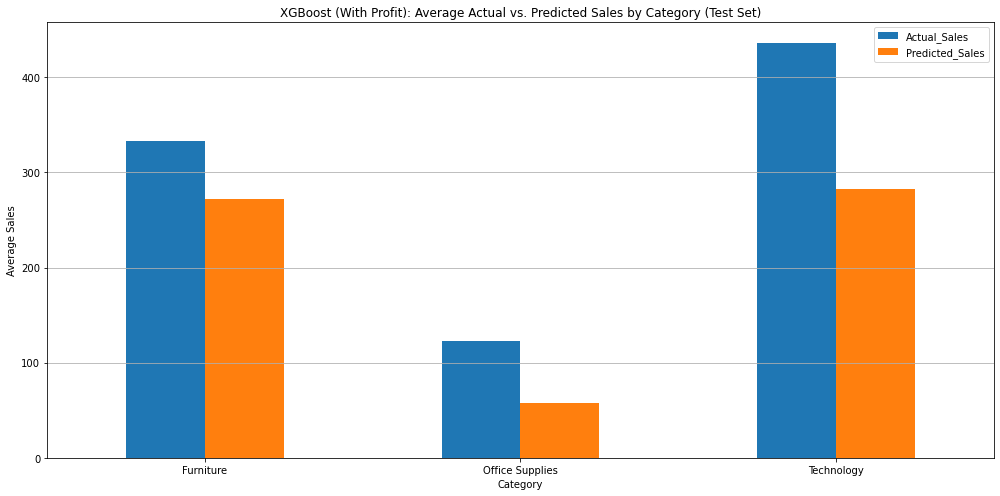


--- Inference: Predicted vs. Actual by Category ---
This bar plot compares the average actual sales to the average predicted sales for each product category.
Ideally, the 'Predicted_Sales' bar should be close to the 'Actual_Sales' bar.

Displaying xgb_predicted_sales_distribution plot (With Profit).


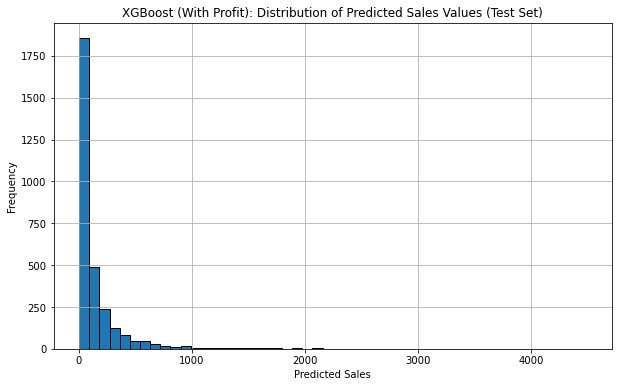


--- Inference: Distribution of Predicted Sales Values ---
This histogram shows the frequency distribution of the model's predicted sales values.

Displaying xgb_residuals_vs_predicted plot (With Profit).


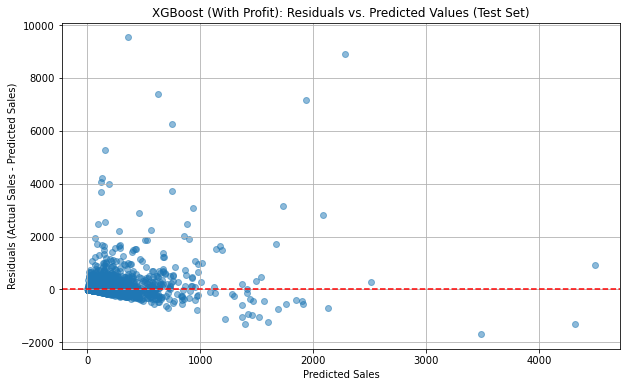


--- Inference: Residuals vs. Predicted Values ---
Randomly scattered points around the zero line are desired. Patterns here (like a funnel shape) suggest heteroscedasticity.

Displaying xgb_residuals_distribution plot (With Profit).


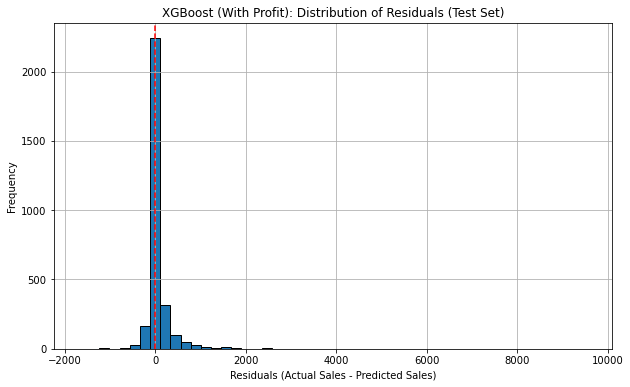


--- Inference: Distribution of Residuals ---
For a good model, the residuals should ideally be normally distributed around zero.

Displaying xgb_predicted_actual_scatter plot (With Profit).


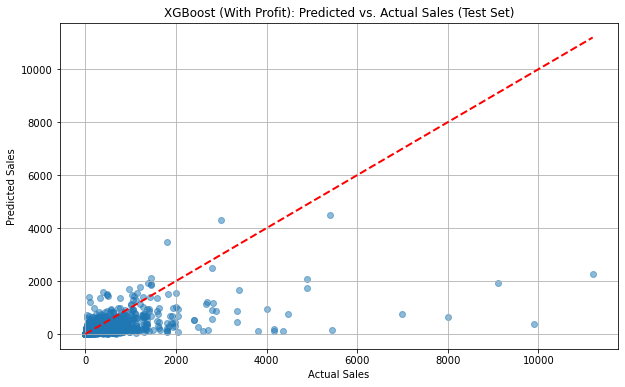


--- Inference: Predicted vs. Actual Sales Scatter Plot ---
Points should ideally lie close to the red dashed line.

--- Model Evaluation Metrics (With Profit) ---
Displaying xgb_model_evaluation_metrics plot (With Profit).


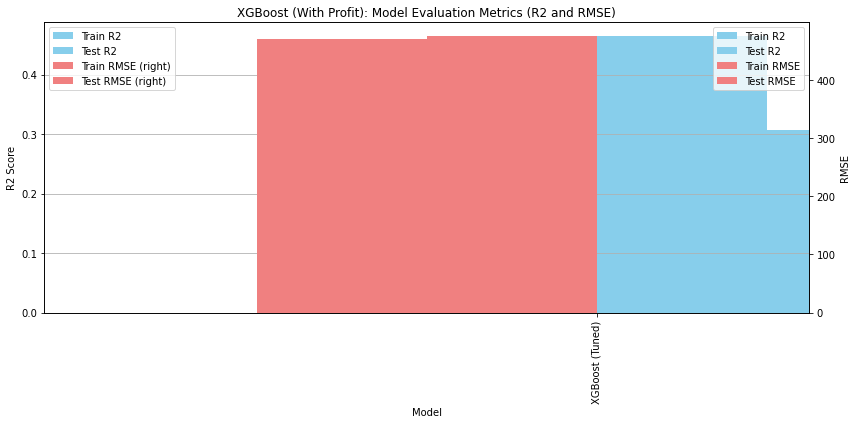


--- Inference: Model Evaluation Metrics ---
Comparing train and test scores helps identify overfitting.

Displaying xgb_feature_importance plot (With Profit).


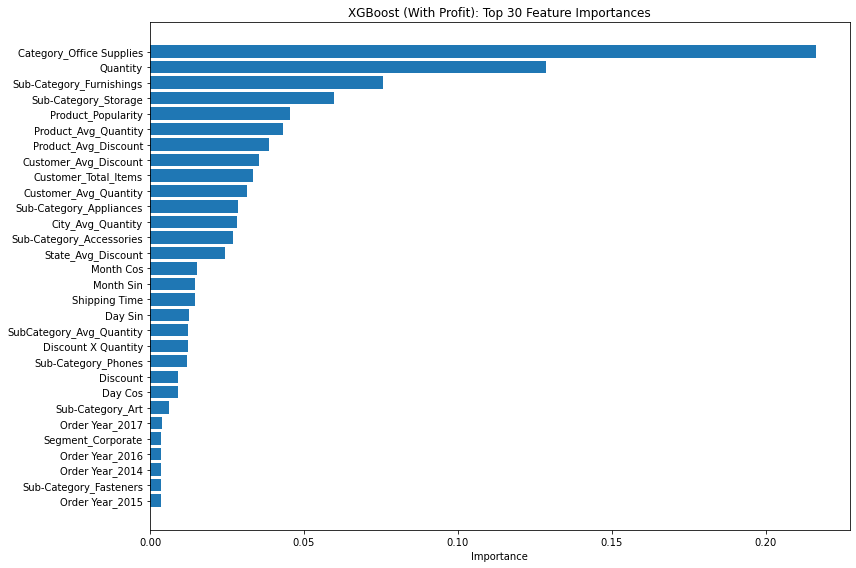


--- Detailed Inference from Feature Importance ---
The top 30 features show the estimated contribution of each feature to the model's predictions.

The most important feature is 'Category_Office Supplies', contributing significantly to the model's ability to predict sales.

Other highly important features include:
- 'Quantity' (Importance: 0.1286)
- 'Sub-Category_Furnishings' (Importance: 0.0756)
- 'Sub-Category_Storage' (Importance: 0.0598)
- 'Product_Popularity' (Importance: 0.0454)
- 'Product_Avg_Quantity' (Importance: 0.0433)

These features likely have a strong correlation with sales and are crucial for the model's performance.

XGBoost Visualization complete (With Profit).


In [46]:
# Consolidating visualizations for XGBoost Model (With Profit)

print("\n--- Visualizations for XGBoost Model (With Profit) ---")

# Assuming best_xgb_model (with profit) and X_test_selected (with profit) are available
# from the initial analysis section.
# If you re-ran the "without profit" section, these variables might be overwritten.
# Ensure you run the "with profit" training section before running this cell
# if you want the visualizations for the model *with* profit features.

try:
    xgb_model = best_xgb_model # Use the best XGBoost model from the 'with profit' tuning

    # Get predictions and inverse transform for test set
    y_test_pred_log_xgb = xgb_model.predict(X_test_selected)
    y_test_true_xgb = np.expm1(y_test) # Use y_test from the initial split
    y_test_pred_xgb = np.expm1(y_test_pred_log_xgb)

    # Calculate residuals
    residuals_xgb = y_test_true_xgb - y_test_pred_xgb

    # Create a temporary dataframe for plotting, including the original selected features
    # Ensure X_test_selected here corresponds to the 'with profit' feature engineering
    plot_data_xgb = X_test_selected.copy()
    plot_data_xgb['Actual_Sales'] = y_test_true_xgb
    plot_data_xgb['Predicted_Sales'] = y_test_pred_xgb
    plot_data_xgb['Residuals'] = residuals_xgb

    # --- Consolidated Plotting Logic ---

    # Residuals vs. Popularity Plot
    if 'Product_Popularity' in plot_data_xgb.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(plot_data_xgb['Product_Popularity'], plot_data_xgb['Residuals'], alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('XGBoost (With Profit): Residuals vs. Product Popularity (Test Set)')
        plt.xlabel('Product Popularity (Total Quantity)')
        plt.ylabel('Residuals (Actual Sales - Predicted Sales)')
        plt.grid(True)
        print("\nDisplaying xgb_residuals_vs_popularity plot (With Profit).")
        plt.show()
        print("\n--- Inference: Residuals vs. Product Popularity ---")
        print("This plot shows if there is a pattern in the errors (residuals) of the model's predictions based on the popularity of a product.")
        print("Ideally, the points should be randomly scattered around the zero line.")

    # Predicted vs. Actual by Category Plot
    if 'Category' in plot_data_xgb.columns:
        plt.figure(figsize=(14, 7))
        category_agg_xgb = plot_data_xgb.groupby('Category')[['Actual_Sales', 'Predicted_Sales']].mean().reset_index()
        category_agg_xgb.plot(x='Category', y=['Actual_Sales', 'Predicted_Sales'], kind='bar', ax=plt.gca())
        plt.title('XGBoost (With Profit): Average Actual vs. Predicted Sales by Category (Test Set)')
        plt.xlabel('Category')
        plt.ylabel('Average Sales')
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.tight_layout()
        print("\nDisplaying xgb_predicted_actual_by_category plot (With Profit).")
        plt.show()
        print("\n--- Inference: Predicted vs. Actual by Category ---")
        print("This bar plot compares the average actual sales to the average predicted sales for each product category.")
        print("Ideally, the 'Predicted_Sales' bar should be close to the 'Actual_Sales' bar.")


    # Distribution of Predicted Sales Values Plot
    plt.figure(figsize=(10, 6))
    plt.hist(y_test_pred_xgb, bins=50, edgecolor='black')
    plt.title('XGBoost (With Profit): Distribution of Predicted Sales Values (Test Set)')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Frequency')
    plt.grid(True)
    print("\nDisplaying xgb_predicted_sales_distribution plot (With Profit).")
    plt.show()
    print("\n--- Inference: Distribution of Predicted Sales Values ---")
    print("This histogram shows the frequency distribution of the model's predicted sales values.")


    # Residuals vs Predicted Values Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_pred_xgb, residuals_xgb, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('XGBoost (With Profit): Residuals vs. Predicted Values (Test Set)')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residuals (Actual Sales - Predicted Sales)')
    plt.grid(True)
    print("\nDisplaying xgb_residuals_vs_predicted plot (With Profit).")
    plt.show()
    print("\n--- Inference: Residuals vs. Predicted Values ---")
    print("Randomly scattered points around the zero line are desired. Patterns here (like a funnel shape) suggest heteroscedasticity.")


    # Distribution of Residuals Plot
    plt.figure(figsize=(10, 6))
    plt.hist(residuals_xgb, bins=50, edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('XGBoost (With Profit): Distribution of Residuals (Test Set)')
    plt.xlabel('Residuals (Actual Sales - Predicted Sales)')
    plt.ylabel('Frequency')
    plt.grid(True)
    print("\nDisplaying xgb_residuals_distribution plot (With Profit).")
    plt.show()
    print("\n--- Inference: Distribution of Residuals ---")
    print("For a good model, the residuals should ideally be normally distributed around zero.")


    # Predicted vs. Actual Sales Plot (Scatter Plot)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_true_xgb, y_test_pred_xgb, alpha=0.5)
    plt.plot([y_test_true_xgb.min(), y_test_true_xgb.max()], [y_test_true_xgb.min(), y_test_true_xgb.max()], 'r--', lw=2) # Perfect prediction line
    plt.title('XGBoost (With Profit): Predicted vs. Actual Sales (Test Set)')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.grid(True)
    print("\nDisplaying xgb_predicted_actual_scatter plot (With Profit).")
    plt.show()
    print("\n--- Inference: Predicted vs. Actual Sales Scatter Plot ---")
    print("Points should ideally lie close to the red dashed line.")


    # Model Evaluation Metrics Visualization (Using the final_results_df from the 'With Profit' run)
    # Ensure final_results_df from the 'with profit' run is available
    if 'final_results_df' in locals() and "XGBoost (Tuned)" in final_results_df.index:
        print("\n--- Model Evaluation Metrics (With Profit) ---")
        fig, ax1 = plt.subplots(figsize=(12, 6))

        final_results_df.loc[["XGBoost (Tuned)"]][['Train R2', 'Test R2']].plot(kind='bar', ax=ax1, position=0, width=0.4, color='skyblue')
        ax2 = final_results_df.loc[["XGBoost (Tuned)"]][['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=ax1, secondary_y=True, position=1, width=0.4, color='lightcoral')

        ax1.set_title('XGBoost (With Profit): Model Evaluation Metrics (R2 and RMSE)')
        ax1.set_xlabel('Model')
        ax1.set_ylabel('R2 Score')
        ax2.set_ylabel('RMSE')

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        plt.xticks(rotation=0)
        ax1.grid(axis='y')
        plt.tight_layout()
        print("Displaying xgb_model_evaluation_metrics plot (With Profit).")
        plt.show()
        print("\n--- Inference: Model Evaluation Metrics ---")
        print("Comparing train and test scores helps identify overfitting.")
    else:
        print("\n'final_results_df' from 'With Profit' analysis not found or does not contain 'XGBoost (Tuned)'. Skipping Model Evaluation Metrics Visualization.")


    # Feature importance plot with labels and brief inference
    # Ensure feature_importance_df from the 'With Profit' run is available
    if 'feature_importance_df' in locals():
        plt.figure(figsize=(12, 8))
        top_n = 30
        # Assuming feature_importance_df contains importances from the 'with profit' run
        feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False).head(top_n)

        plt.barh(feature_importance_df_sorted['Feature'], feature_importance_df_sorted['Importance'])
        plt.xlabel('Importance')
        plt.title(f'XGBoost (With Profit): Top {top_n} Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        print("\nDisplaying xgb_feature_importance plot (With Profit).")
        plt.show()

        print("\n--- Detailed Inference from Feature Importance ---")
        print(f"The top {top_n} features show the estimated contribution of each feature to the model's predictions.")

        # Analyze the top features and provide inferences
        top_feature_names = feature_importance_df_sorted['Feature'].tolist()
        if top_feature_names:
            print(f"\nThe most important feature is '{top_feature_names[0]}', contributing significantly to the model's ability to predict sales.")
            if len(top_feature_names) > 1:
                print("\nOther highly important features include:")
                for i in range(1, min(top_n, 6)):
                    feature = top_feature_names[i]
                    importance = feature_importance_df_sorted.iloc[i]['Importance']
                    print(f"- '{feature}' (Importance: {importance:.4f})")

            print("\nThese features likely have a strong correlation with sales and are crucial for the model's performance.")
        else:
            print("Could not retrieve top feature names for detailed inference.")

    else:
        print("\n'feature_importance_df' from 'With Profit' analysis not found. Skipping Feature Importance plot.")

    print("\nXGBoost Visualization complete (With Profit).")

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'With Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during XGBoost visualization (With Profit): {e}")

## Without Profit

### Linear

In [47]:
import seaborn as sns
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\n--- Visualizations for Linear Regression Model (Without Profit) ---")

try:
    lr_model = best_lr_model

    y_train_pred_log = lr_model.predict(X_train_selected)
    y_train_true = np.expm1(y_train)
    y_train_pred = np.expm1(y_train_pred_log)

    y_test_pred_log = lr_model.predict(X_test_selected)
    y_test_true = np.expm1(y_test)
    y_test_pred = np.expm1(y_test_pred_log)

    # --- Visualize Feature Importance (for Linear Models, use coefficients) ---
    if 'preprocessor_selected' in locals():
        fitted_preprocessor = preprocessor_selected.fit(X_train_selected)
        feature_names_processed = fitted_preprocessor.get_feature_names_out()
        coefficients = lr_model.named_steps['model'].coef_

        if len(feature_names_processed) == len(coefficients):
             coefficients_df = pd.DataFrame({
                 'Feature': feature_names_processed,
                 'Coefficient': coefficients
             })
             coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

             print("\n--- Linear Regression Coefficients (Interpretation depends on preprocessing scale) ---")
             display(coefficients_df)

             plt.figure(figsize=(12, min(20, len(coefficients_df) * 0.3)))
             top_n_coef = 30
             if len(coefficients_df) > 2 * top_n_coef:
                 coefs_to_plot = pd.concat([coefficients_df.head(top_n_coef), coefficients_df.tail(top_n_coef)])
             else:
                 coefs_to_plot = coefficients_df

             plt.barh(coefs_to_plot['Feature'], coefs_to_plot['Coefficient'])
             plt.xlabel('Coefficient Value')
             plt.title('Linear Regression Coefficients (Without Profit)')
             plt.gca().invert_yaxis()
             plt.tight_layout()
             print("\nDisplaying lr_coefficients plot (Without Profit).")
             plt.show()

             print("\n--- Inference: Linear Regression Coefficients ---")
             print("The magnitude and sign of the coefficients indicate the estimated change in the predicted log-sales for a one-unit increase in the feature value, assuming all other features are held constant.")
             print("Positive coefficients suggest a positive relationship with sales, while negative coefficients suggest a negative relationship.")
             print("Interpretation is most direct when features are scaled (like with PowerTransformer here), but multicollinearity can still affect individual coefficient values.")

        else:
            print("\nWarning: Mismatch between number of features and coefficients. Cannot display coefficients.")
            print(f"Number of processed features: {len(feature_names_processed)}")
            print(f"Number of coefficients: {len(coefficients)}")
    else:
        print("\n'preprocessor_selected' not found. Cannot display Linear Regression coefficients.")


    # --- Visualize Predicted vs Actual Sales ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].scatter(y_train_true, y_train_pred, alpha=0.5)
    axes[0].plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'k--', lw=2)
    axes[0].set_xlabel('Actual Sales (Train)')
    axes[0].set_ylabel('Predicted Sales (Train)')
    axes[0].set_title('Linear Regression (Without Profit): Actual vs Predicted Sales (Training Set)')

    axes[1].scatter(y_test_true, y_test_pred, alpha=0.5)
    axes[1].plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'k--', lw=2)
    axes[1].set_xlabel('Actual Sales (Test)')
    axes[1].set_ylabel('Predicted Sales (Test)')
    axes[1].set_title('Linear Regression (Without Profit): Actual vs Predicted Sales (Test Set)')
    plt.tight_layout()
    print("\nDisplaying lr_predicted_actual_scatter plots (Without Profit).")
    plt.show()
    print("\n--- Inference: Predicted vs Actual Sales ---")
    print("Points should ideally lie close to the black diagonal line. Scatter indicates prediction errors.")


    # --- Visualize Residuals Distribution ---
    train_residuals = y_train_true - y_train_pred
    test_residuals = y_test_true - y_test_pred

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].hist(train_residuals, bins=50)
    axes[0].set_title('Linear Regression (Without Profit): Distribution of Training Set Residuals')
    axes[0].set_xlabel('Residuals')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].hist(test_residuals, bins=50)
    axes[1].set_title('Linear Regression (Without Profit): Distribution of Test Set Residuals')
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    print("\nDisplaying lr_residuals_distribution plots (Without Profit).")
    plt.show()
    print("\n--- Inference: Residuals Distribution ---")
    print("Ideally, residuals should be normally distributed around zero. Skewness or patterns suggest model limitations.")

    # --- Visualize Residuals vs Predicted Values ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].scatter(y_train_pred, train_residuals, alpha=0.5)
    axes[0].axhline(0, color='k', linestyle='--')
    axes[0].set_title('Linear Regression (Without Profit): Residuals vs Predicted (Training Set)')
    axes[0].set_xlabel('Predicted Sales (Train)')
    axes[0].set_ylabel('Residuals (Train)')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].scatter(y_test_pred, test_residuals, alpha=0.5)
    axes[1].axhline(0, color='k', linestyle='--')
    axes[1].set_title('Linear Regression (Without Profit): Residuals vs Predicted (Test Set)')
    axes[1].set_xlabel('Predicted Sales (Test)')
    axes[1].set_ylabel('Residuals (Test)')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    print("\nDisplaying lr_residuals_vs_predicted plots (Without Profit).")
    plt.show()
    print("\n--- Inference: Residuals vs Predicted Values ---")
    print("Random scatter around zero is desired. Patterns (like a cone shape) indicate heteroscedasticity.")


    # --- Visualize Predicted vs Actual by Category ---
    if 'Category' in X_test_selected.columns:
        X_test_selected_plot = X_test_selected.copy()
        X_test_selected_plot['Predicted Sales'] = y_test_pred
        X_test_selected_plot['Actual Sales'] = y_test_true

        sales_by_category = X_test_selected_plot.melt(
            id_vars=['Category'],
            value_vars=['Actual Sales', 'Predicted Sales'],
            var_name='variable',
            value_name='value'
        )

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=sales_by_category, x='Category', y='value', hue='variable')
        plt.title('Linear Regression (Without Profit): Actual vs Predicted Sales by Category (Test Set)')
        plt.xlabel('Category')
        plt.ylabel('Sales Value')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        print("\nDisplaying lr_predicted_actual_by_category plot (Without Profit).")
        plt.show()
        print("\n--- Inference: Predicted vs Actual by Category ---")
        print("Compares actual vs predicted sales distributions for each category. Helps identify categories where the model performs better or worse.")
    else:
        print("\n'Category' feature not found in selected features. Skipping Predicted vs Actual by Category plot.")


    # --- Visualize Learning Curves ---
    print("\n--- Learning Curve Plot for Linear Regression (Without Profit) ---")
    estimator = best_lr_model

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X_train_selected,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=50
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title('Linear Regression (Without Profit): Learning Curve')
    plt.xlabel("Training Examples")
    plt.ylabel("R2 Score")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.6)
    print("\nDisplaying lr_learning_curve plot (Without Profit).")
    plt.show()
    print("\n--- Inference: Learning Curve ---")
    print("Shows how model performance changes with increasing training data. Helps diagnose bias vs variance issues.")

    # --- Additional EDA Plots (Keeping relevant ones) ---
    print("\n--- Distribution of Key Features (Original Data) ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.histplot(data['Sales'], bins=50, ax=axes[0], kde=True)
    axes[0].set_title('Distribution of Original Sales')
    axes[0].set_xlabel('Sales Value')
    axes[0].set_ylabel('Frequency')

    sns.histplot(data['Quantity'], bins=20, ax=axes[1], kde=True)
    axes[1].set_title('Distribution of Quantity')
    axes[1].set_xlabel('Quantity')
    axes[1].set_ylabel('Frequency')

    sns.histplot(data['Discount'], bins=20, ax=axes[2], kde=True)
    axes[2].set_title('Distribution of Discount')
    axes[2].set_xlabel('Discount')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    print("\nDisplaying distribution plots of original features.")
    plt.show()
    print("\n--- Inference: Distribution of Key Features ---")
    print("Visualizing original feature distributions helps understand the data and justify preprocessing steps.")


    print("\n--- Relationships Between Key Features (Original Data) ---")
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.scatterplot(x='Quantity', y='Sales', data=data, alpha=0.5, ax=axes[0])
    axes[0].set_title('Sales vs Quantity')
    axes[0].set_xlabel('Quantity')
    axes[0].set_ylabel('Sales Value')

    sns.scatterplot(x='Discount', y='Sales', data=data, alpha=0.5, ax=axes[1])
    axes[1].set_title('Sales vs Discount')
    axes[1].set_xlabel('Discount')
    axes[1].set_ylabel('Sales Value')

    plt.tight_layout()
    print("\nDisplaying scatter plots of original features vs Sales.")
    plt.show()
    print("\n--- Inference: Relationships Between Key Features ---")
    print("Shows potential correlations and patterns between input features and the target variable.")


    print("\n--- Sales Trends Over Time (Monthly) ---")

    data['Order Date'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y', errors='coerce')
    monthly_sales = data.set_index('Order Date')['Sales'].resample('M').sum()

    plt.figure(figsize=(12, 6))
    monthly_sales.plot()
    plt.title('Monthly Total Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.grid(True)
    print("\nDisplaying monthly sales trend plot.")
    plt.show()
    print("\n--- Inference: Sales Trends Over Time ---")
    print("Identifies seasonality or trends in sales data.")


    print("\n--- Sales by Other Categorical Features (Original Data) ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.boxplot(x='Segment', y='Sales', data=data, ax=axes[0])
    axes[0].set_title('Sales by Segment')
    axes[0].set_xlabel('Segment')
    axes[0].set_ylabel('Sales Value')

    sns.boxplot(x='Ship Mode', y='Sales', data=data, ax=axes[1])
    axes[1].set_title('Sales by Ship Mode')
    axes[1].set_xlabel('Ship Mode')
    axes[1].set_ylabel('Sales Value')

    sns.boxplot(x='Region', y='Sales', data=data, ax=axes[2])
    axes[2].set_title('Sales by Region')
    axes[2].set_xlabel('Region')
    axes[2].set_ylabel('Sales Value')

    plt.tight_layout()
    plt.show()
    print("\n--- Inference: Sales by Other Categorical Features ---")
    print("Reveals how sales distributions vary across different categories.")

    print("\nLinear Regression Visualization complete (Without Profit).")

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'Without Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Linear Regression visualization (Without Profit): {e}")


--- Visualizations for Linear Regression Model (Without Profit) ---

An unexpected error occurred during Linear Regression visualization (Without Profit): 'ColumnTransformer' object has no attribute 'get_feature_names_out'


This bar chart displays the relative importance of the top features used by the RandomForestRegressor model to predict sales. Features with taller bars have a greater impact on the model's predictions. We observe that 'Category_Office Supplies' and 'Quantity' are the most dominant features, suggesting that the category of a product and the number of items purchased are the strongest drivers of sales values in this dataset. Features like 'Sub-Category_Furnishings' and 'Sub-Category_Storage' also show significant importance, indicating that within categories, certain sub-categories are more influential. The lower importance of some other features suggests they contribute less to the predictive power of this particular model. Inference: Focusing on understanding the dynamics of 'Office Supplies' category and strategies related to 'Quantity' and high-importance sub-categories could be key to improving sales predictions and potentially sales performance.


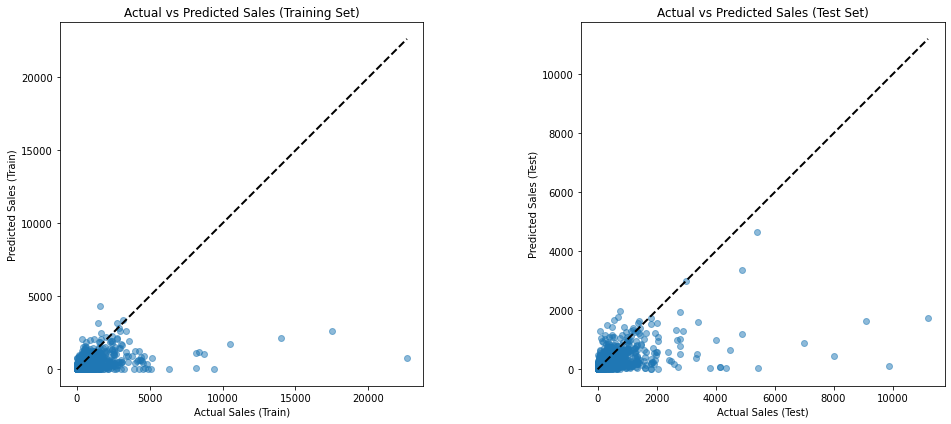

In [48]:
# --- Visualize Predicted vs Actual Sales ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set plot
axes[0].scatter(y_train_true, y_train_pred, alpha=0.5)
axes[0].plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'k--', lw=2)
axes[0].set_xlabel('Actual Sales (Train)')
axes[0].set_ylabel('Predicted Sales (Train)')
axes[0].set_title('Actual vs Predicted Sales (Training Set)')
axes[0].set_aspect('equal', adjustable='box')

# Test set plot
axes[1].scatter(y_test_true, y_test_pred, alpha=0.5)
axes[1].plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'k--', lw=2)
axes[1].set_xlabel('Actual Sales (Test)')
axes[1].set_ylabel('Predicted Sales (Test)')
axes[1].set_title('Actual vs Predicted Sales (Test Set)')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


These scatter plots compare the model's predicted sales values against the actual sales values for both the training and test datasets. A perfect model would have all points lying exactly on the black diagonal line, where predicted equals actual. We observe that while there is a general trend along the line, there is considerable scatter, particularly for higher sales values. This indicates that the model has difficulty accurately predicting larger sales amounts. The scatter appears somewhat similar between the training and test sets, which is good as it doesn't strongly suggest overfitting on the training data based on this plot alone. Inference: The model struggles to capture the variability in higher sales transactions. Further investigation into the characteristics of high-value sales and potentially using a model better suited for capturing extreme values might be beneficial.


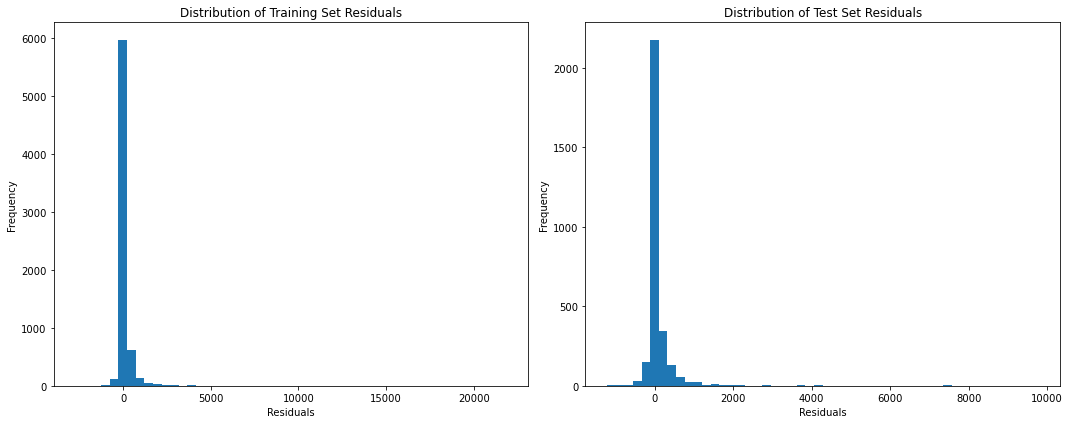

In [49]:
# --- Visualize Residuals Distribution ---
train_residuals = y_train_true - y_train_pred
test_residuals = y_test_true - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(train_residuals, bins=50)
axes[0].set_title('Distribution of Training Set Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

axes[1].hist(test_residuals, bins=50)
axes[1].set_title('Distribution of Test Set Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

These histograms show the distribution of the residuals, which are the differences between the actual and predicted sales values (Actual - Predicted). For a good regression model, we ideally expect the residuals to be normally distributed around zero. Looking at the plots, both the training and test residuals appear somewhat centered around zero, but they exhibit a skewed distribution, particularly with a long tail extending towards positive values. This positive skew suggests that the model tends to under-predict sales more often than it over-predicts, especially for larger errors. Inference: The non-normal and skewed distribution of residuals indicates that the model's assumptions might be violated, and there's room for improvement in capturing the underlying patterns, potentially by addressing outliers or considering different modeling techniques.


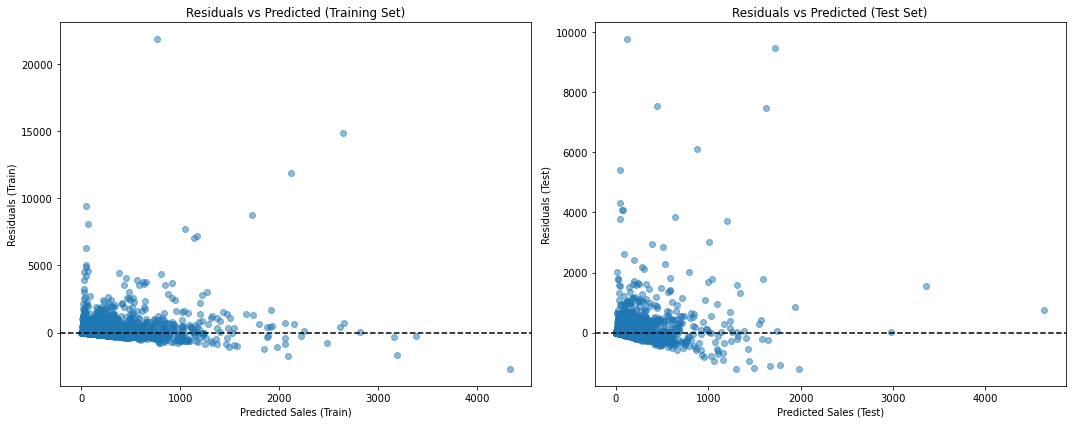

In [50]:
# --- Visualize Residuals vs Predicted Values ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set residuals vs predicted
axes[0].scatter(y_train_pred, train_residuals, alpha=0.5)
axes[0].axhline(0, color='k', linestyle='--')
axes[0].set_title('Residuals vs Predicted (Training Set)')
axes[0].set_xlabel('Predicted Sales (Train)')
axes[0].set_ylabel('Residuals (Train)')

# Test set residuals vs predicted
axes[1].scatter(y_test_pred, test_residuals, alpha=0.5)
axes[1].axhline(0, color='k', linestyle='--')
axes[1].set_title('Residuals vs Predicted (Test Set)')
axes[1].set_xlabel('Predicted Sales (Test)')
axes[1].set_ylabel('Residuals (Test)')

plt.tight_layout()
plt.show()

These scatter plots show the relationship between the predicted sales values and the corresponding residuals. For a well-performing model with homoscedastic errors (constant variance), we would expect to see a random cloud of points scattered evenly around the horizontal line at zero, with no discernible pattern. In these plots, we observe a pattern where the spread of residuals increases as the predicted sales values increase, forming a cone-like shape. This pattern indicates heteroscedasticity, meaning the model's errors are not consistent across all predicted values; it tends to make larger errors for higher predicted sales. Inference: The presence of heteroscedasticity suggests that the model's assumptions about constant error variance are not met. This can impact the reliability of statistical tests and confidence intervals. Addressing this might involve transforming the target variable further, using robust regression techniques, or modeling the variance separately.


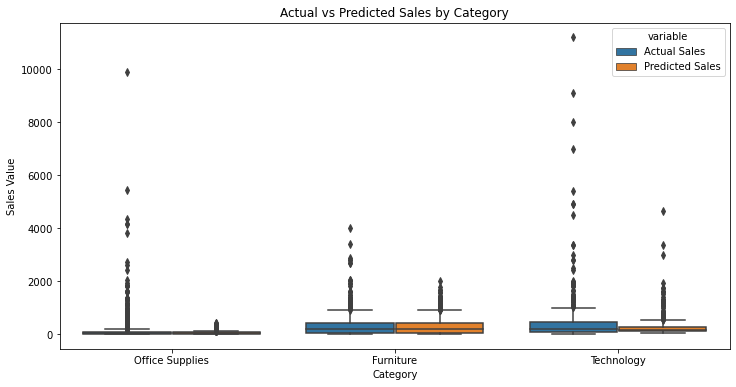

In [51]:
# --- Visualize Predicted vs Actual by Category ---
X_test_selected_plot = X_test_selected.copy()
X_test_selected_plot['Predicted Sales'] = y_test_pred
X_test_selected_plot['Actual Sales'] = y_test_true

sales_by_category = X_test_selected_plot.melt(
    id_vars=['Category'],
    value_vars=['Actual Sales', 'Predicted Sales'],
    var_name='variable',
    value_name='value'
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=sales_by_category, x='Category', y='value', hue='variable')
plt.title('Actual vs Predicted Sales by Category')
plt.xlabel('Category')
plt.ylabel('Sales Value')
plt.xticks(rotation=0)
plt.show()

This box plot visualizes the distribution of actual and predicted sales values for each major product category. By comparing the boxes and whiskers for 'Actual Sales' and 'Predicted Sales' within each category, we can assess how well the model is performing for different product types. We can observe that the distributions for 'Office Supplies' appear relatively similar between actual and predicted, suggesting better performance in this category. For 'Furniture' and 'Technology', there seem to be larger discrepancies, particularly in the spread and potential outliers, indicating that the model may be less accurate in predicting sales for these categories. Inference: The model's performance varies significantly across product categories. Further analysis focusing on 'Furniture' and 'Technology' categories might reveal specific patterns or features that the current model is not effectively capturing, leading to poorer predictions in these areas.


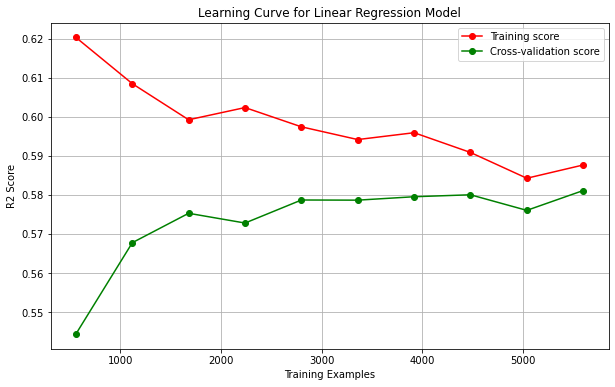

In [52]:
# --- Visualize Learning Curves ---
train_sizes, train_scores, test_scores = learning_curve(
    best_lr_model,
    X_train_selected,
    y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=50
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curve for Linear Regression Model')
plt.xlabel("Training Examples")
plt.ylabel("R2 Score")
plt.legend(loc="best")
plt.grid()
plt.show()

The learning curve illustrates how the model's performance, measured by R2 score, changes as the amount of training data increases. The red line represents the training score, and the green line represents the cross-validation score (performance on unseen data during training). We observe that the training score starts high and decreases slightly, while the cross-validation score starts lower and plateaus as more training examples are added. There is a noticeable gap between the training score and the cross-validation score even with the full training dataset. This pattern typically indicates overfitting; the model is performing much better on the data it was trained on than on new, unseen data. Inference: The model is likely too complex for the amount of data available or is capturing noise in the training data. To address this, we could consider simplifying the model, using regularization techniques, or potentially acquiring more diverse training data if possible.



--- Distribution of Key Features ---


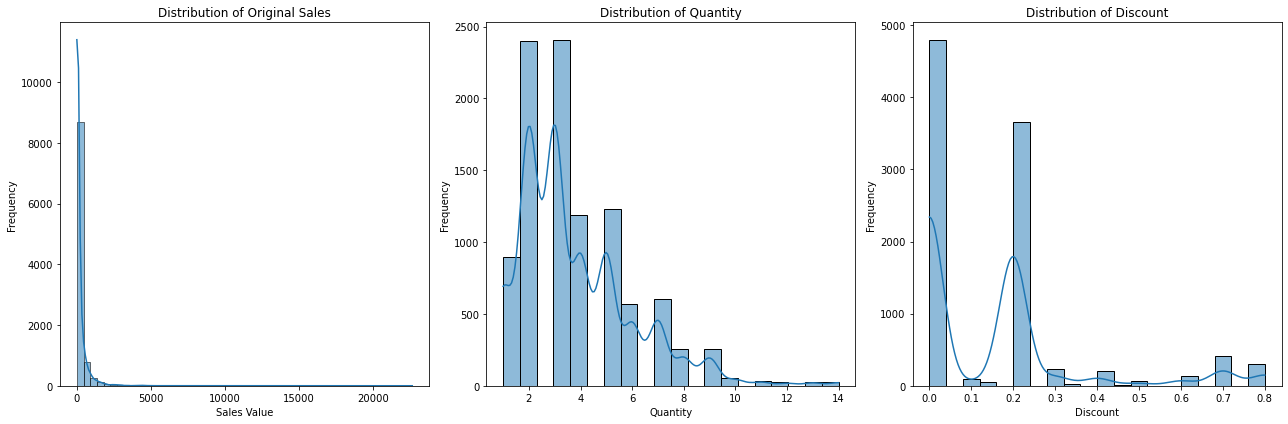

In [53]:
# Distribution of Key Features (Original Sales, Quantity, Discount)
print("\n--- Distribution of Key Features ---")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data['Sales'], bins=50, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Original Sales')
axes[0].set_xlabel('Sales Value')
axes[0].set_ylabel('Frequency')

sns.histplot(data['Quantity'], bins=20, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Quantity')
axes[1].set_xlabel('Quantity')
axes[1].set_ylabel('Frequency')

sns.histplot(data['Discount'], bins=20, ax=axes[2], kde=True)
axes[2].set_title('Distribution of Discount')
axes[2].set_xlabel('Discount')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Explanation & Inference:

These histograms show the distributions of the original Sales, Quantity, and Discount features. The Sales distribution is highly skewed to the right, indicating many small sales and a few very large ones. This skewness is why we applied a log transformation to the target variable. Quantity shows a distribution concentrated on smaller values. Discount has a distribution with peaks at 0 and various discount levels, suggesting discrete discount policies. Inference: Understanding these distributions is crucial for preprocessing steps like transformation and outlier handling.



--- Relationships Between Key Features ---


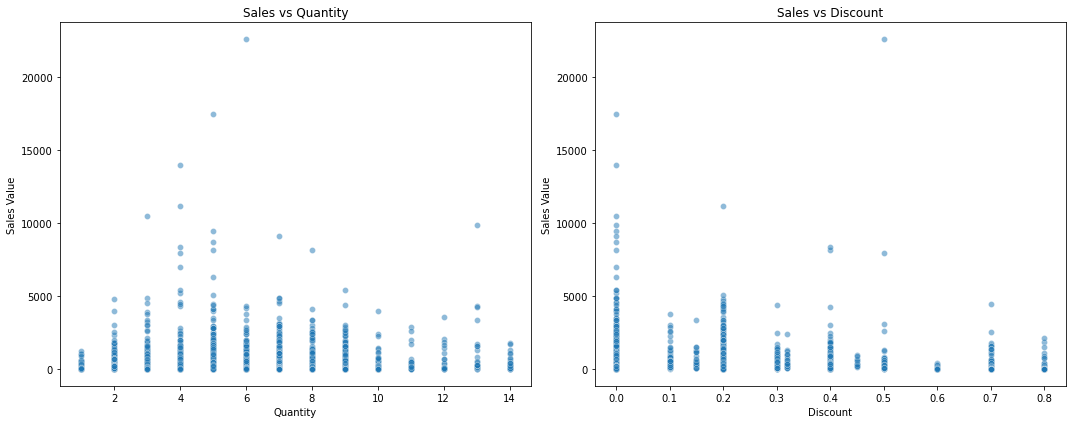

In [54]:
# Relationships Between Key Features (Sales vs Quantity, Sales vs Discount)
print("\n--- Relationships Between Key Features ---")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x='Quantity', y='Sales', data=data, alpha=0.5, ax=axes[0])
axes[0].set_title('Sales vs Quantity')
axes[0].set_xlabel('Quantity')
axes[0].set_ylabel('Sales Value')

sns.scatterplot(x='Discount', y='Sales', data=data, alpha=0.5, ax=axes[1])
axes[1].set_title('Sales vs Discount')
axes[1].set_xlabel('Discount')
axes[1].set_ylabel('Sales Value')

plt.tight_layout()
plt.show()

Explanation & Inference:

These scatter plots show the relationship between Sales and Quantity, and Sales and Discount. Sales generally tend to increase with Quantity, although there's considerable spread. The relationship between Sales and Discount appears more complex, with high sales values occurring across various discount levels, and some high discounts associated with lower sales (possibly due to loss-leading strategies or attempts to move unpopular items). Inference: These plots highlight the non-linear and potentially complex relationships between features and the target, which models like Linear Regression might struggle to capture fully.



--- Sales Trends Over Time (Monthly) ---


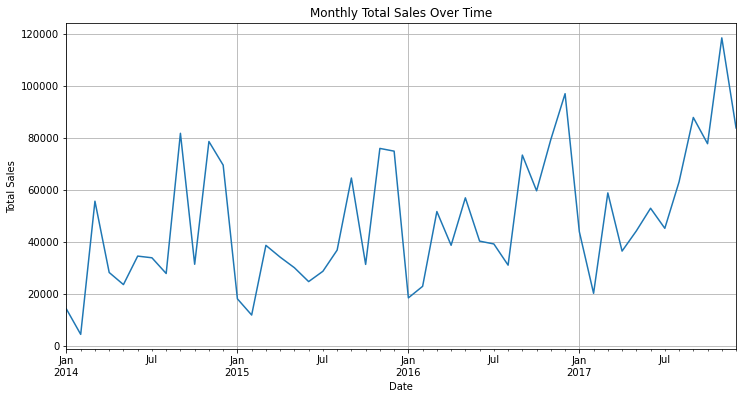

In [55]:
# Sales Trends Over Time (Monthly Sales)
print("\n--- Sales Trends Over Time (Monthly) ---")

data['Order Date'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y')
monthly_sales = data.set_index('Order Date')['Sales'].resample('M').sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot()
plt.title('Monthly Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


Explanation & Inference:

This line plot shows the total sales aggregated by month over the years in the dataset. We can observe potential trends and seasonality. There appear to be yearly cycles, with sales often peaking towards the end of the year. Inference: Time-based features and potentially time series models could be valuable for capturing these temporal patterns.





--- Sales by Other Categorical Features ---


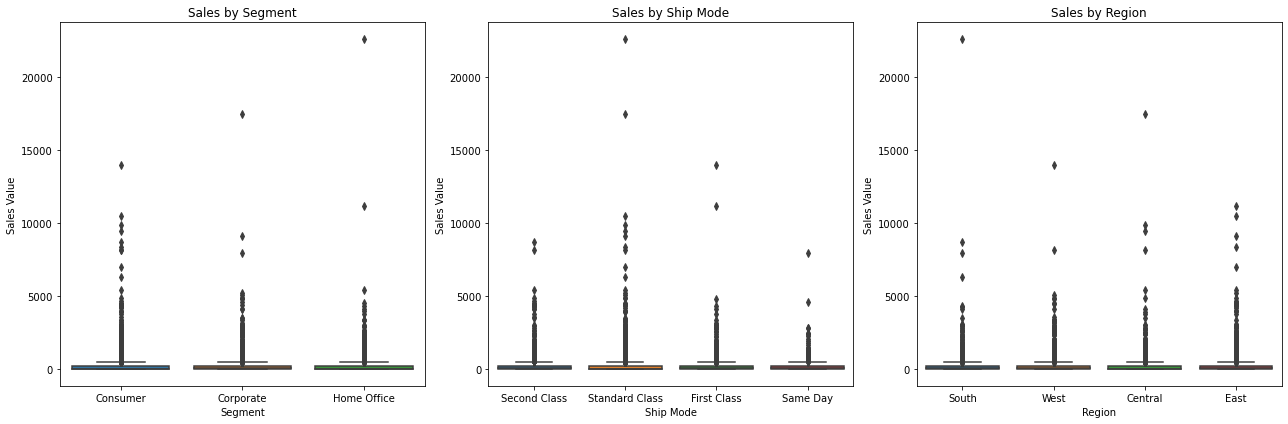

In [56]:
# Sales by Other Categorical Features (Segment, Ship Mode, Region)
print("\n--- Sales by Other Categorical Features ---")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='Segment', y='Sales', data=data, ax=axes[0])
axes[0].set_title('Sales by Segment')
axes[0].set_xlabel('Segment')
axes[0].set_ylabel('Sales Value')

sns.boxplot(x='Ship Mode', y='Sales', data=data, ax=axes[1])
axes[1].set_title('Sales by Ship Mode')
axes[1].set_xlabel('Ship Mode')
axes[1].set_ylabel('Sales Value')

sns.boxplot(x='Region', y='Sales', data=data, ax=axes[2])
axes[2].set_title('Sales by Region')
axes[2].set_xlabel('Region')
axes[2].set_ylabel('Sales Value')

plt.tight_layout()
plt.show()


Explanation & Inference:

These box plots show the distribution of sales values for different categories within Segment, Ship Mode, and Region. They help identify if certain categories within these features are associated with significantly different sales ranges or distributions. For example, one segment might have higher median sales or more outliers than another. Inference: These categorical features appear to have varying relationships with sales and are important to include in the model, as confirmed by feature importance.

### Random Forest


--- Residuals vs Product Popularity Plots for Random Forest (Without Profit) ---

Displaying rf_residuals_vs_popularity plots (Without Profit).


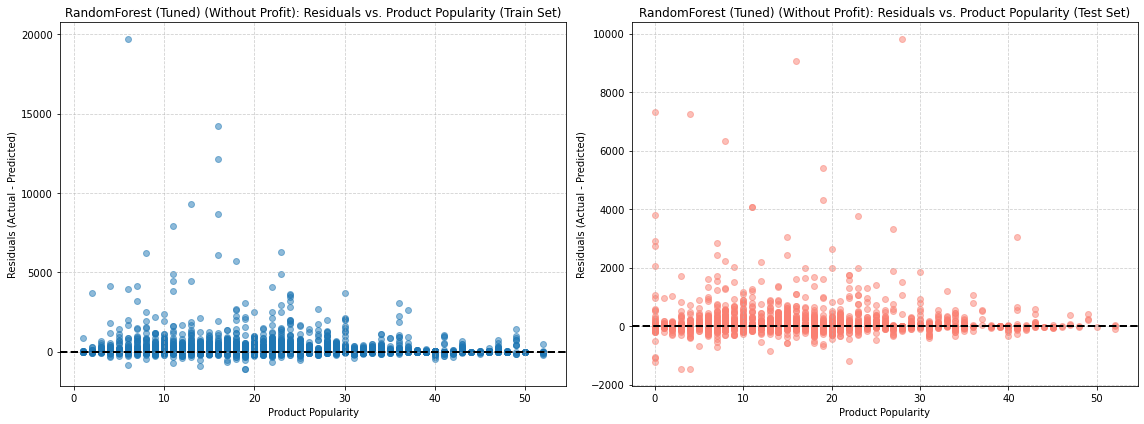


--- Learning Curve Plot for RandomForest (Tuned) (Without Profit) ---

Displaying rf_learning_curve plot (Without Profit).


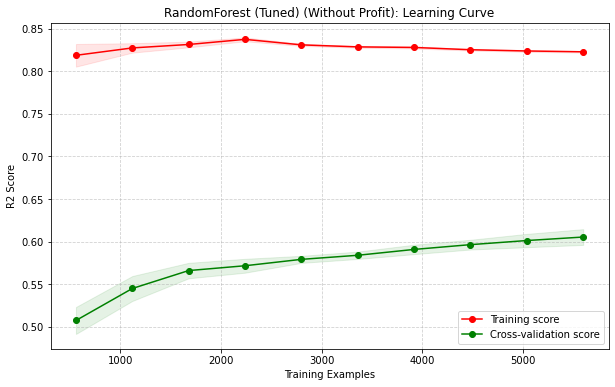

In [57]:
# Consolidating Residuals vs Product Popularity Plots for Random Forest Model (Without Profit)

print("\n--- Residuals vs Product Popularity Plots for Random Forest (Without Profit) ---")

try:
    name = "RandomForest (Tuned)"
    model = best_rf_model

    y_train_pred_log = model.predict(X_train_selected)
    y_train_pred = np.expm1(y_train_pred_log)
    y_train_true = np.expm1(y_train)

    train_residuals = y_train_true - y_train_pred

    y_test_pred_log = model.predict(X_test_selected)
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_true = np.expm1(y_test)

    test_residuals = y_test_true - y_test_pred

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    if 'Product_Popularity' in X_train_selected.columns:
        axes[0].scatter(X_train_selected['Product_Popularity'], train_residuals, alpha=0.5)
        axes[0].axhline(0, color='k', linestyle='--', lw=2)
        axes[0].set_title(f'{name} (Without Profit): Residuals vs. Product Popularity (Train Set)')
        axes[0].set_xlabel('Product Popularity')
        axes[0].set_ylabel('Residuals (Actual - Predicted)')
        axes[0].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[0].set_title(f'{name} (Without Profit): Product_Popularity not in selected features (Train Set)')


    if 'Product_Popularity' in X_test_selected.columns:
        axes[1].scatter(X_test_selected['Product_Popularity'], test_residuals, alpha=0.5, color='salmon')
        axes[1].axhline(0, color='k', linestyle='--', lw=2)
        axes[1].set_title(f'{name} (Without Profit): Residuals vs. Product Popularity (Test Set)')
        axes[1].set_xlabel('Product Popularity')
        axes[1].set_ylabel('Residuals (Actual - Predicted)')
        axes[1].grid(True, linestyle='--', alpha=0.6)
    else:
         axes[1].set_title(f'{name} (Without Profit): Product_Popularity not in selected features (Test Set)')

    plt.tight_layout()
    print("\nDisplaying rf_residuals_vs_popularity plots (Without Profit).")
    plt.show()

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'Without Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Random Forest visualization (Without Profit): {e}")


from sklearn.model_selection import learning_curve

try:
    name = "RandomForest (Tuned)"
    model = best_rf_model

    print(f"\n--- Learning Curve Plot for {name} (Without Profit) ---")

    estimator = model

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X_train_selected,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=50
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title(f'{name} (Without Profit): Learning Curve')
    plt.xlabel("Training Examples")
    plt.ylabel("R2 Score")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.6)
    print("\nDisplaying rf_learning_curve plot (Without Profit).")
    plt.show()

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'Without Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Random Forest Learning Curve plot (Without Profit): {e}")

Inference:

RandomForest (Tuned):

* The learning curve for the
RandomForest model shows a smaller gap between the training score and the cross-validation score compared to the XGBoost model. This suggests that the RandomForest model is overfitting less than the XGBoost model, although there is still some overfitting present.
* Both the training and cross-validation scores appear to be leveling off as the training set size increases, indicating that adding more data might not significantly improve the performance of the current RandomForest model configuration.
* The overall R2 scores on both the training and cross-validation sets are lower for the RandomForest model compared to the XGBoost model, which aligns with the final evaluation metrics and suggests that, with the current tuning, XGBoost performs better on this dataset.


--- Predicted vs. Actual by Category Plots for Random Forest (Without Profit) ---

Displaying rf_predicted_actual_by_category plots (Without Profit).


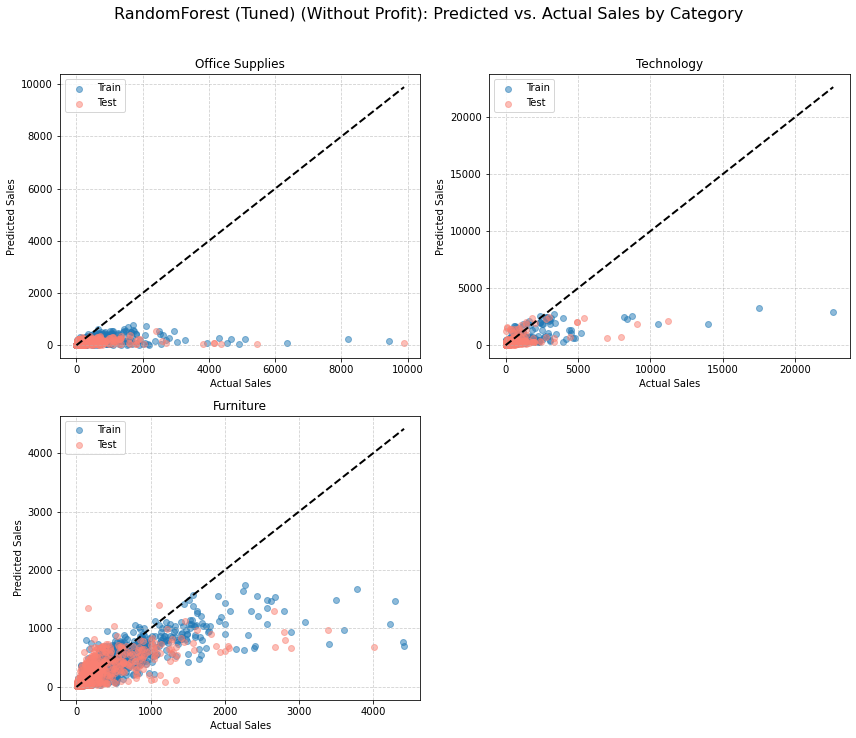

In [58]:
# Consolidating Predicted vs. Actual by Category Plots for Random Forest Model (Without Profit)

print(f"\n--- Predicted vs. Actual by Category Plots for Random Forest (Without Profit) ---")

try:
    name = "RandomForest (Tuned)"
    model = best_rf_model

    y_train_pred_log = model.predict(X_train_selected)
    y_train_pred = np.expm1(y_train_pred_log)
    y_train_true = np.expm1(y_train)

    y_test_pred_log = model.predict(X_test_selected)
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_true = np.expm1(y_test)

    X_train_selected_plot = X_train_selected.copy()
    X_train_selected_plot['Actual Sales'] = y_train_true
    X_train_selected_plot['Predicted Sales'] = y_train_pred

    X_test_selected_plot = X_test_selected.copy()
    X_test_selected_plot['Actual Sales'] = y_test_true
    X_test_selected_plot['Predicted Sales'] = y_test_pred


    if 'Category' in X_train_selected_plot.columns:
        categories = X_train_selected_plot['Category'].unique()
        n_categories = len(categories)

        n_cols = 2
        n_rows = (n_categories + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
        axes = axes.flatten()

        for i, category in enumerate(categories):
            ax = axes[i]

            train_cat_data = X_train_selected_plot[X_train_selected_plot['Category'] == category]
            test_cat_data = X_test_selected_plot[X_test_selected_plot['Category'] == category]

            ax.scatter(train_cat_data['Actual Sales'], train_cat_data['Predicted Sales'], alpha=0.5, label='Train')
            ax.scatter(test_cat_data['Actual Sales'], test_cat_data['Predicted Sales'], alpha=0.5, label='Test', color='salmon')

            max_sales = max(train_cat_data['Actual Sales'].max(), test_cat_data['Actual Sales'].max())
            ax.plot([0, max_sales], [0, max_sales], 'k--', lw=2)

            ax.set_title(f'{category}')
            ax.set_xlabel('Actual Sales')
            ax.set_ylabel('Predicted Sales')
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.6)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle(f'{name} (Without Profit): Predicted vs. Actual Sales by Category', y=1.02, fontsize=16)
        plt.tight_layout()
        print("\nDisplaying rf_predicted_actual_by_category plots (Without Profit).")
        plt.show()
    else:
        print("\n'Category' feature not found in selected features. Skipping this plot.")

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'Without Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Random Forest visualization (Without Profit): {e}")

Inference:

RandomForest (Tuned):

* The plots show the performance of the model on predicting sales within each product category.
* For categories with a wider range of sales values (e.g., Technology, Furniture), the spread of predicted values is larger, but the model still tends to under-predict the highest sales values, similar to the XGBoost model, but the overall fit appears less tight compared to XGBoost on the training data.
* For categories with generally lower sales values (e.g., Office Supplies), the predictions are more clustered, and the model appears to perform reasonably well, although some under-prediction of slightly higher values within these categories is also visible.
* The test set points generally follow a similar pattern to the training set within each category, but the spread around the diagonal line is wider, indicating the model is less accurate on unseen data for all categories.


--- Distribution of Predicted Sales Values Plots for Random Forest (Without Profit) ---

Displaying rf_predicted_sales_distribution plots (Without Profit).


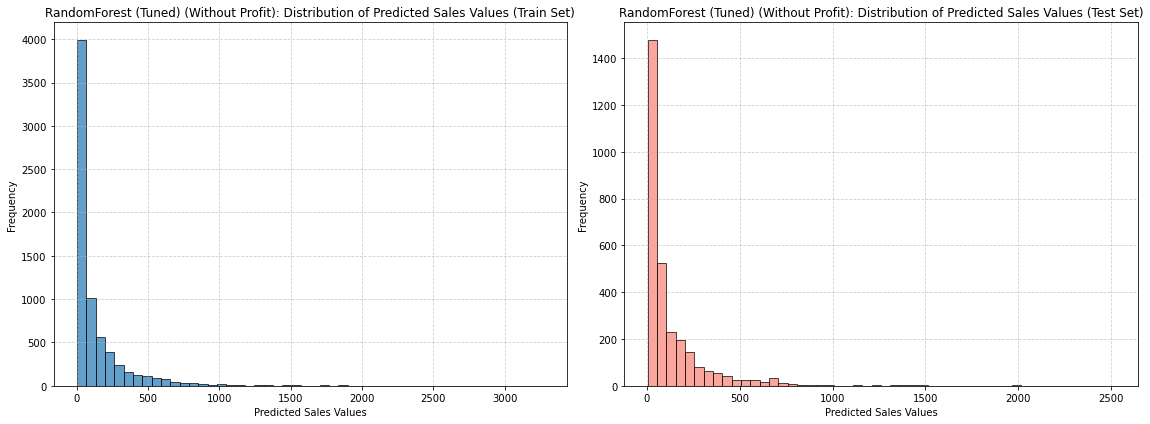

In [59]:
# Consolidating Distribution of Predicted Sales Values Plots for Random Forest Model (Without Profit)

print(f"\n--- Distribution of Predicted Sales Values Plots for Random Forest (Without Profit) ---")

try:
    name = "RandomForest (Tuned)"
    model = best_rf_model

    y_train_pred_log = model.predict(X_train_selected)
    y_train_pred = np.expm1(y_train_pred_log)

    y_test_pred_log = model.predict(X_test_selected)
    y_test_pred = np.expm1(y_test_pred_log)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].hist(y_train_pred, bins=50, edgecolor='k', alpha=0.7)
    axes[0].set_title(f'{name} (Without Profit): Distribution of Predicted Sales Values (Train Set)')
    axes[0].set_xlabel('Predicted Sales Values')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, linestyle='--', alpha=0.6)


    axes[1].hist(y_test_pred, bins=50, edgecolor='k', alpha=0.7, color='salmon')
    axes[1].set_title(f'{name} (Without Profit): Distribution of Predicted Sales Values (Test Set)')
    axes[1].set_xlabel('Predicted Sales Values')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    print("\nDisplaying rf_predicted_sales_distribution plots (Without Profit).")
    plt.show()

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'Without Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Random Forest visualization (Without Profit): {e}")

Inference:

RandomForest (Tuned):

* Training Set: The distribution of predicted sales values for the training set is heavily skewed to the right, with a strong peak at lower predicted values and a long tail. This reflects the skewness in the actual sales data but also suggests the model might be overly cautious in predicting higher values.
* Test Set: The distribution of predicted sales values for the test set is similar to the training set, also exhibiting significant right-skewness. The range of predicted values on the test set appears somewhat compressed compared to the training set, further indicating that the model is less confident in predicting high sales values on unseen data. The distributions for both train and test sets do not perfectly match the distribution of actual sales, suggesting the model might not be fully capturing the patterns of high sales values.


--- Residuals vs Predicted Values Plots for Random Forest (Without Profit) ---

Displaying rf_residuals_vs_predicted plots (Without Profit).


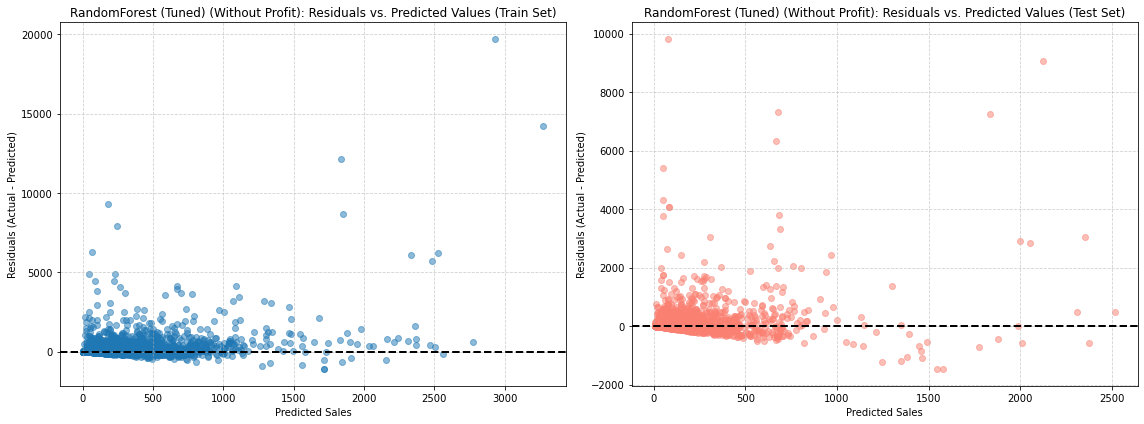

In [60]:
# Consolidating Residuals vs Predicted Values Plots for Random Forest Model (Without Profit)

print(f"\n--- Residuals vs Predicted Values Plots for Random Forest (Without Profit) ---")

try:
    name = "RandomForest (Tuned)"
    model = best_rf_model

    y_train_pred_log = model.predict(X_train_selected)
    y_train_pred = np.expm1(y_train_pred_log)
    y_train_true = np.expm1(y_train)

    train_residuals = y_train_true - y_train_pred

    y_test_pred_log = model.predict(X_test_selected)
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_true = np.expm1(y_test)

    test_residuals = y_test_true - y_test_pred

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].scatter(y_train_pred, train_residuals, alpha=0.5)
    axes[0].axhline(0, color='k', linestyle='--', lw=2)
    axes[0].set_title(f'{name} (Without Profit): Residuals vs. Predicted Values (Train Set)')
    axes[0].set_xlabel('Predicted Sales')
    axes[0].set_ylabel('Residuals (Actual - Predicted)')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].scatter(y_test_pred, test_residuals, alpha=0.5, color='salmon')
    axes[1].axhline(0, color='k', linestyle='--', lw=2)
    axes[1].set_title(f'{name} (Without Profit): Residuals vs. Predicted Values (Test Set)')
    axes[1].set_xlabel('Predicted Sales')
    axes[1].set_ylabel('Residuals (Actual - Predicted)')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    print("\nDisplaying rf_residuals_vs_predicted plots (Without Profit).")
    plt.show()

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'Without Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Random Forest visualization (Without Profit): {e}")

Inference:

RandomForest (Tuned):

* Training Set: The residuals plot for the training set shows a similar pattern to XGBoost, with residuals spreading out as predicted sales values increase, indicating heteroscedasticity. The points are somewhat centered around zero, but the spread is not uniform. There are also some noticeable clusters of residuals, suggesting potential issues with specific groups of data points.
* Test Set: The pattern of heteroscedasticity is also present in the test set residuals plot, with a wider spread of errors for higher predicted values compared to the training set. This reinforces the observation that the model struggles more with predicting higher sales values on unseen data. The overall scatter is larger than on the training set, consistent with the lower test R2 and higher test RMSE.


--- Residuals Plots for Random Forest (Without Profit) ---

Displaying rf_residuals_distribution plots (Without Profit).


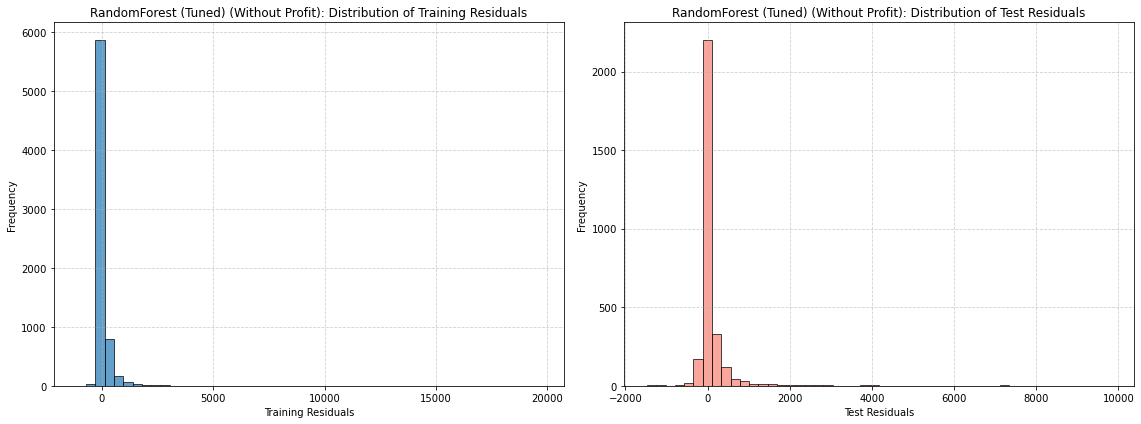

In [61]:
# Consolidating Distribution of Residuals Plots for Random Forest Model (Without Profit)

print(f"\n--- Residuals Plots for Random Forest (Without Profit) ---")

try:
    name = "RandomForest (Tuned)"
    model = best_rf_model

    y_train_pred_log = model.predict(X_train_selected)
    y_train_pred = np.expm1(y_train_pred_log)
    y_train_true = np.expm1(y_train)

    train_residuals = y_train_true - y_train_pred

    y_test_pred_log = model.predict(X_test_selected)
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_true = np.expm1(y_test)

    test_residuals = y_test_true - y_test_pred

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].hist(train_residuals, bins=50, edgecolor='k', alpha=0.7)
    axes[0].set_title(f'{name} (Without Profit): Distribution of Training Residuals')
    axes[0].set_xlabel('Training Residuals')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, linestyle='--', alpha=0.6)


    axes[1].hist(test_residuals, bins=50, edgecolor='k', alpha=0.7, color='salmon')
    axes[1].set_title(f'{name} (Without Profit): Distribution of Test Residuals')
    axes[1].set_xlabel('Test Residuals')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, linestyle='--', alpha=0.6)


    plt.tight_layout()
    print("\nDisplaying rf_residuals_distribution plots (Without Profit).")
    plt.show()

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'Without Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Random Forest visualization (Without Profit): {e}")

Inference:

RandomForest (Tuned):

* Training Set: The distribution of training residuals is skewed to the right, with a peak around zero and a long tail of positive residuals. This suggests that the model tends to under-predict sales values, particularly for higher sales amounts, resulting in large positive residuals.
* Test Set: The distribution of test residuals shows a similar right-skewness, but the spread appears wider and the tail of positive residuals is more pronounced compared to the training set. This indicates that the under-prediction of higher sales values is more significant on unseen data, contributing to the lower performance on the test set. The distribution is not centered at zero, suggesting a systematic under-prediction bias.


--- Predicted vs. Actual Sales Plots for Random Forest (Without Profit) ---

Displaying rf_predicted_actual_scatter plots (Without Profit).


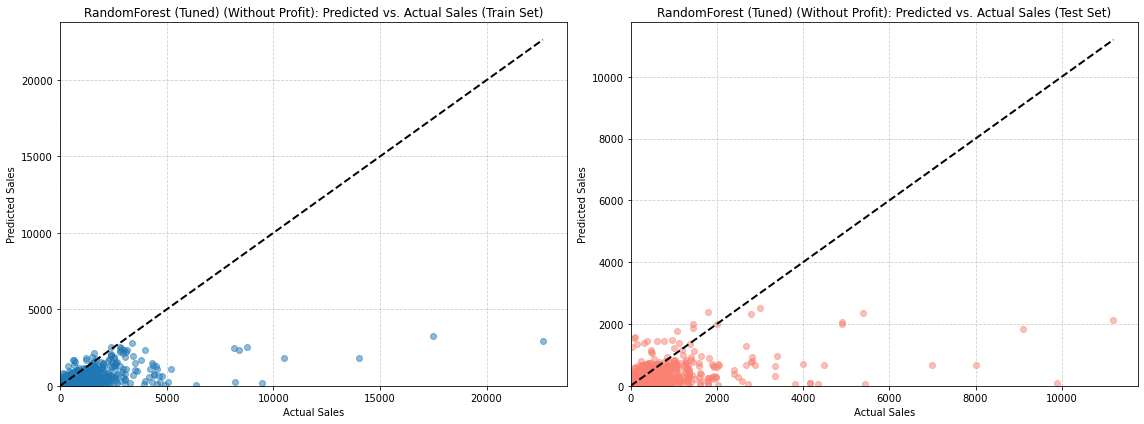

In [62]:
# Consolidating Predicted vs. Actual Sales Plots for Random Forest Model (Without Profit)

print(f"\n--- Predicted vs. Actual Sales Plots for Random Forest (Without Profit) ---")

try:
    name = "RandomForest (Tuned)"
    model = best_rf_model

    y_train_pred_log = model.predict(X_train_selected)
    y_train_pred = np.expm1(y_train_pred_log)
    y_train_true = np.expm1(y_train)

    y_test_pred_log = model.predict(X_test_selected)
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_true = np.expm1(y_test)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].scatter(y_train_true, y_train_pred, alpha=0.5)
    axes[0].plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'k--', lw=2)
    axes[0].set_title(f'{name} (Without Profit): Predicted vs. Actual Sales (Train Set)')
    axes[0].set_xlabel('Actual Sales')
    axes[0].set_ylabel('Predicted Sales')
    axes[0].set_xlim([0, y_train_true.max() * 1.05])
    axes[0].set_ylim([0, y_train_true.max() * 1.05])
    axes[0].grid(True, linestyle='--', alpha=0.6)


    axes[1].scatter(y_test_true, y_test_pred, alpha=0.5, color='salmon')
    axes[1].plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'k--', lw=2)
    axes[1].set_title(f'{name} (Without Profit): Predicted vs. Actual Sales (Test Set)')
    axes[1].set_xlabel('Actual Sales')
    axes[1].set_ylabel('Predicted Sales')
    axes[1].set_xlim([0, y_test_true.max() * 1.05])
    axes[1].set_ylim([0, y_test_true.max() * 1.05])
    axes[1].grid(True, linestyle='--', alpha=0.6)


    plt.tight_layout()
    print("\nDisplaying rf_predicted_actual_scatter plots (Without Profit).")
    plt.show()

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'Without Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Random Forest visualization (Without Profit): {e}")

Inference:

RandomForest (Tuned):

* Training Set: The scatter plot for the training set shows that the model's predictions generally follow the trend of actual sales but exhibit significant spread, especially at higher sales values. The model tends to under-predict high sales values, similar to the XGBoost model, but the overall fit appears less tight compared to XGBoost on the training data.
* Test Set: The plot for the test set shows a similar pattern of under-predicting high sales values and a wider scatter of points around the diagonal line compared to the training set. This indicates poorer performance and generalization on unseen data, consistent with the evaluation metrics. The under-prediction of high values is more pronounced on the test set.


--- Final Model Plots for Random Forest (Without Profit) ---

Displaying rf_model_evaluation_metrics plot (Without Profit).


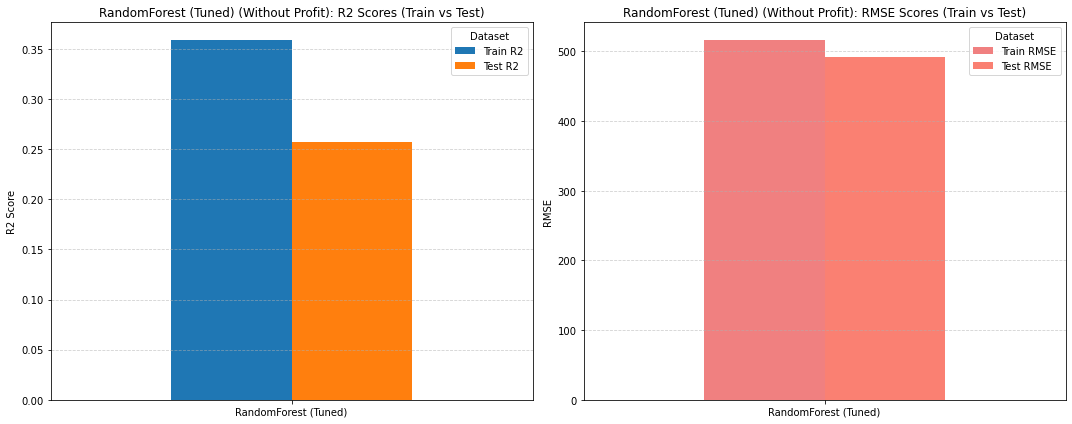

In [63]:
# Consolidating Model Evaluation Metrics Visualization for Random Forest (Without Profit)

print(f"\n--- Final Model Plots for Random Forest (Without Profit) ---")

try:
    name = "RandomForest (Tuned)"

    if name in final_results_df.index:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        final_results_df.loc[[name]][['Train R2', 'Test R2']].plot(kind='bar', ax=axes[0])
        axes[0].set_title(f'{name} (Without Profit): R2 Scores (Train vs Test)')
        axes[0].set_ylabel('R2 Score')
        axes[0].tick_params(axis='x', rotation=0)
        axes[0].legend(title='Dataset')
        axes[0].grid(axis='y', linestyle='--', alpha=0.6)


        final_results_df.loc[[name]][['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=axes[1], color=['lightcoral', 'salmon'])
        axes[1].set_title(f'{name} (Without Profit): RMSE Scores (Train vs Test)')
        axes[1].set_ylabel('RMSE')
        axes[1].tick_params(axis='x', rotation=0)
        axes[1].legend(title='Dataset')
        axes[1].grid(axis='y', linestyle='--', alpha=0.6)


        plt.tight_layout()
        print("\nDisplaying rf_model_evaluation_metrics plot (Without Profit).")
        plt.show()

    else:
        print(f"\nResults for '{name}' not found in 'final_results_df'. Skipping plots.")

except NameError as e:
    print(f"\nError: {e}. Please ensure the 'Without Profit' model training cells were run successfully before running this visualization cell.")
except Exception as e:
    print(f"\nAn unexpected error occurred during Random Forest evaluation plots (Without Profit): {e}")

Inference:

RandomForest (Tuned):

* The bar plots show the R2 and RMSE scores for the tuned RandomForest model on both the training and test sets.
* The training R2 score is significantly higher than the test R2 score, and the training RMSE is much lower than the test RMSE. This indicates a substantial performance drop on unseen data, suggesting that the RandomForest model is also overfitting the training data.
* Compared to the XGBoost model, the RandomForest model has lower R2 scores and higher RMSE values on both the training and test sets, suggesting that XGBoost performed better overall on this dataset with the current tuning.

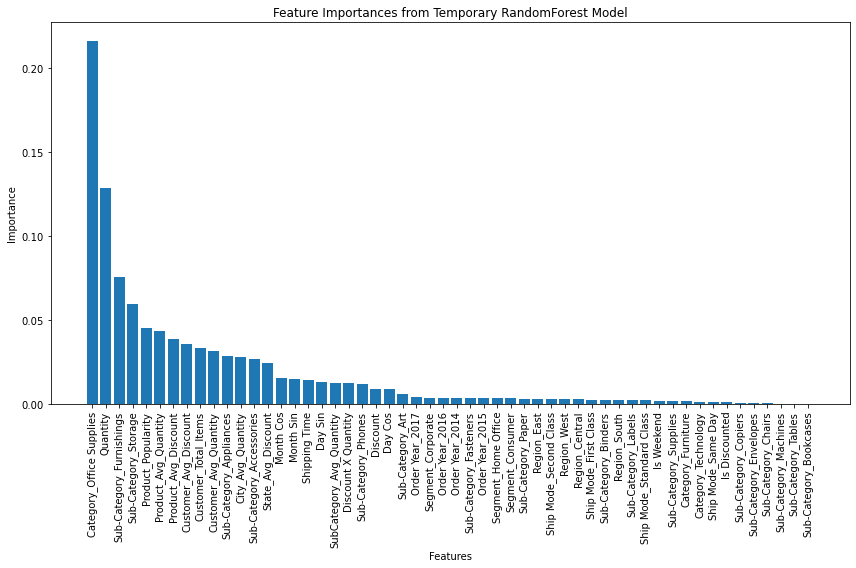

In [64]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importances from Temporary RandomForest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### XGBoost


--- Residuals vs Product Popularity Plots ---

--- XGBoost (Tuned) ---


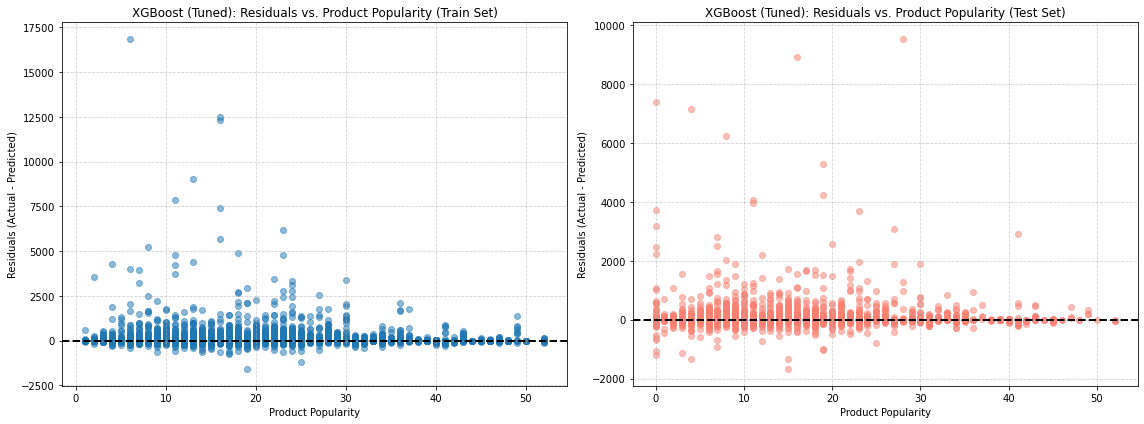

In [65]:
print("\n--- Residuals vs Product Popularity Plots ---")

models_to_evaluate_xgb = {"XGBoost (Tuned)": models_to_evaluate["XGBoost (Tuned)"]}

for name, model in models_to_evaluate_xgb.items():
    print(f"\n--- {name} ---")

    y_train_pred_log = model.predict(X_train_selected)
    y_train_pred = np.expm1(y_train_pred_log)
    y_train_true = np.expm1(y_train)

    train_residuals = y_train_true - y_train_pred

    y_test_pred_log = model.predict(X_test_selected)
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_true = np.expm1(y_test)

    test_residuals = y_test_true - y_test_pred

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    if 'Product_Popularity' in X_train_selected.columns:
        axes[0].scatter(X_train_selected['Product_Popularity'], train_residuals, alpha=0.5)
        axes[0].axhline(0, color='k', linestyle='--', lw=2)
        axes[0].set_title(f'{name}: Residuals vs. Product Popularity (Train Set)')
        axes[0].set_xlabel('Product Popularity')
        axes[0].set_ylabel('Residuals (Actual - Predicted)')
        axes[0].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[0].set_title(f'{name}: Product_Popularity not in selected features (Train Set)')


    if 'Product_Popularity' in X_test_selected.columns:
        axes[1].scatter(X_test_selected['Product_Popularity'], test_residuals, alpha=0.5, color='salmon')
        axes[1].axhline(0, color='k', linestyle='--', lw=2)
        axes[1].set_title(f'{name}: Residuals vs. Product Popularity (Test Set)')
        axes[1].set_xlabel('Product Popularity')
        axes[1].set_ylabel('Residuals (Actual - Predicted)')
        axes[1].grid(True, linestyle='--', alpha=0.6)
    else:
         axes[1].set_title(f'{name}: Product_Popularity not in selected features (Test Set)')


    plt.tight_layout()
    plt.show()

Inference:

XGBoost (Tuned):

* Similar to the RandomForest model, the residuals vs. Product Popularity plots for XGBoost also show a tendency for the spread of residuals to increase with higher product popularity. This indicates that XGBoost, too, has more difficulty accurately predicting sales for very popular products.
* The pattern of heteroscedasticity (increasing variance of residuals) is visible in both the training and test sets.
* While 'Product_Popularity' is a significant feature, the model doesn't perfectly capture its relationship with sales, leading to larger errors for high-popularity items.


--- Learning Curve Plot for XGBoost (Tuned) ---


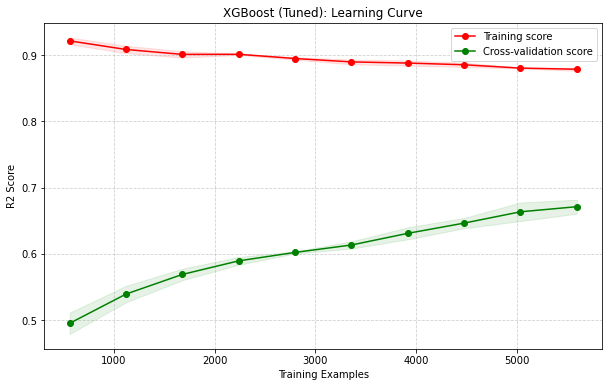

In [66]:
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

name = "XGBoost (Tuned)"
original_pipeline = models_to_evaluate[name]

print(f"\n--- Learning Curve Plot for {name} ---")

if isinstance(original_pipeline.named_steps['model'], TransformedTargetRegressor):
    base_xgb_regressor = original_pipeline.named_steps['model'].regressor
    xgb_params = base_xgb_regressor.get_params()
    if 'early_stopping_rounds' in xgb_params:
        del xgb_params['early_stopping_rounds']
    xgb_regressor_for_lc = XGBRegressor(**xgb_params)
    model_for_lc = TransformedTargetRegressor(
        regressor=xgb_regressor_for_lc,
        transformer=original_pipeline.named_steps['model'].transformer
    )
else:
    base_xgb_regressor = original_pipeline.named_steps['model']
    xgb_params = base_xgb_regressor.get_params()
    if 'early_stopping_rounds' in xgb_params:
        del xgb_params['early_stopping_rounds']
    model_for_lc = XGBRegressor(**xgb_params)


estimator = Pipeline(steps=[
    ('preprocessor', original_pipeline.named_steps['preprocessor']),
    ('model', model_for_lc)
])


train_sizes, train_scores, test_scores = learning_curve(
    estimator,
    X_train_selected, y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title(f'{name}: Learning Curve')
plt.xlabel("Training Examples")
plt.ylabel("R2 Score")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Inference:

XGBoost (Tuned):

* The learning curve shows how the model's performance (R2 score) changes as the size of the training data increases.
* The training score starts high with a small number of training examples and decreases as more data is added. This is typical, as the model finds it harder to perfectly fit a larger, more diverse dataset.
* The cross-validation score (performance on unseen data during cross-validation) starts low and increases as the training set size grows. This indicates that providing more data generally improves the model's ability to generalize.
* There is a significant gap between the training score and the cross-validation score, even with the full training dataset. This suggests that the model might be overfitting the training data. However, the cross-validation score appears to be leveling off, indicating that adding significantly more data might yield diminishing returns for performance improvement with the current model configuration. Further tuning or regularization might be needed to reduce the overfitting.


--- Predicted vs. Actual by Category Plots for XGBoost (Tuned) ---


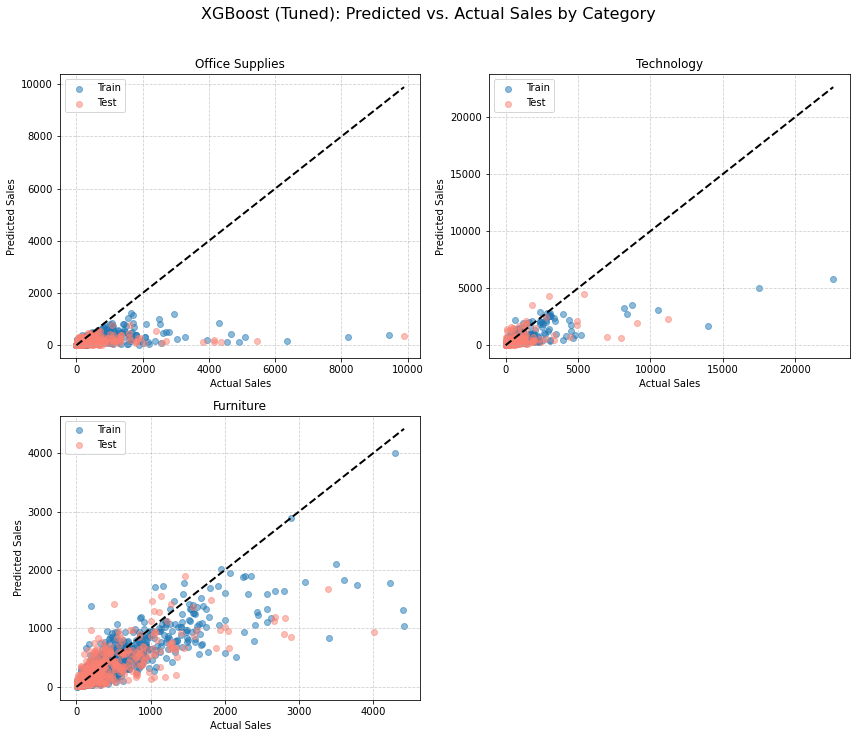

In [67]:
name = "XGBoost (Tuned)"
model = models_to_evaluate[name]

print(f"\n--- Predicted vs. Actual by Category Plots for {name} ---")

y_train_pred_log = model.predict(X_train_selected)
y_train_pred = np.expm1(y_train_pred_log)
y_train_true = np.expm1(y_train)

y_test_pred_log = model.predict(X_test_selected)
y_test_pred = np.expm1(y_test_pred_log)
y_test_true = np.expm1(y_test)

X_train_selected_plot = X_train_selected.copy()
X_train_selected_plot['Actual Sales'] = y_train_true
X_train_selected_plot['Predicted Sales'] = y_train_pred

X_test_selected_plot = X_test_selected.copy()
X_test_selected_plot['Actual Sales'] = y_test_true
X_test_selected_plot['Predicted Sales'] = y_test_pred


if 'Category' in X_train_selected_plot.columns:
    categories = X_train_selected_plot['Category'].unique()
    n_categories = len(categories)

    n_cols = 2
    n_rows = (n_categories + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
    axes = axes.flatten()
    for i, category in enumerate(categories):
        ax = axes[i]

        train_cat_data = X_train_selected_plot[X_train_selected_plot['Category'] == category]
        test_cat_data = X_test_selected_plot[X_test_selected_plot['Category'] == category]

        ax.scatter(train_cat_data['Actual Sales'], train_cat_data['Predicted Sales'], alpha=0.5, label='Train')
        ax.scatter(test_cat_data['Actual Sales'], test_cat_data['Predicted Sales'], alpha=0.5, label='Test', color='salmon')


        max_sales = max(train_cat_data['Actual Sales'].max(), test_cat_data['Actual Sales'].max())
        ax.plot([0, max_sales], [0, max_sales], 'k--', lw=2)

        ax.set_title(f'{category}')
        ax.set_xlabel('Actual Sales')
        ax.set_ylabel('Predicted Sales')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'{name}: Predicted vs. Actual Sales by Category', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print(" 'Category' feature not found in selected features. Skipping this plot.")

Inference:

XGBoost (Tuned):

* The plots show the performance of the model on predicting sales within each product category.
* For categories with a wider range of sales values (e.g., Technology, Furniture), the spread of predicted values is larger, but the model still tends to under-predict the highest sales values, consistent with the overall predicted vs. actual plot.
* For categories with generally lower sales values (e.g., Office Supplies), the predictions are more clustered, and the model appears to perform reasonably well, although some under-prediction of slightly higher values within these categories is also visible.
* The test set points generally follow a similar pattern to the training set within each category, but the spread around the diagonal line is wider, indicating the model is less accurate on unseen data for all categories.


--- Residuals vs Predicted Values Plots for XGBoost (Tuned) ---


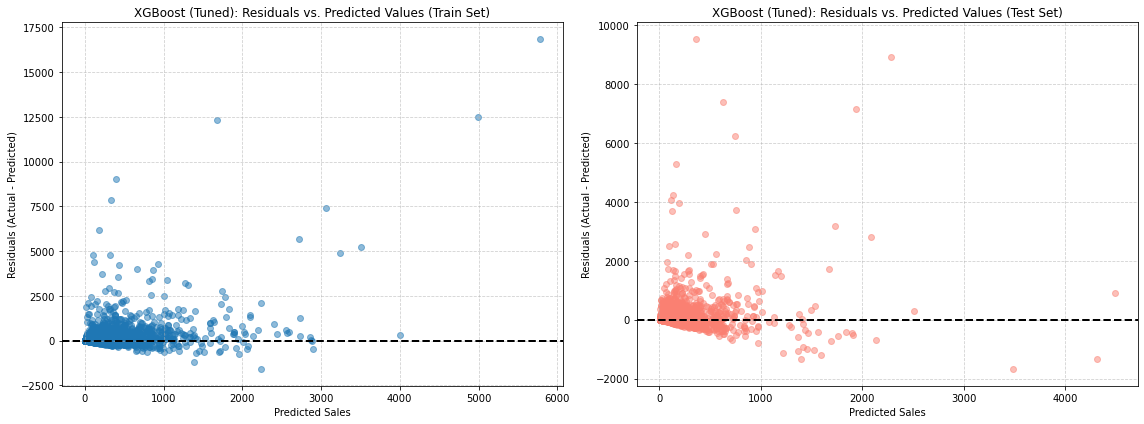

In [68]:
name = "XGBoost (Tuned)"
model = models_to_evaluate[name]

print(f"\n--- Residuals vs Predicted Values Plots for {name} ---")

y_train_pred_log = model.predict(X_train_selected)
y_train_pred = np.expm1(y_train_pred_log)
y_train_true = np.expm1(y_train)

train_residuals = y_train_true - y_train_pred

y_test_pred_log = model.predict(X_test_selected)
y_test_pred = np.expm1(y_test_pred_log)
y_test_true = np.expm1(y_test)

test_residuals = y_test_true - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_train_pred, train_residuals, alpha=0.5)
axes[0].axhline(0, color='k', linestyle='--', lw=2)
axes[0].set_title(f'{name}: Residuals vs. Predicted Values (Train Set)')
axes[0].set_xlabel('Predicted Sales')
axes[0].set_ylabel('Residuals (Actual - Predicted)')
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].scatter(y_test_pred, test_residuals, alpha=0.5, color='salmon')
axes[1].axhline(0, color='k', linestyle='--', lw=2)
axes[1].set_title(f'{name}: Residuals vs. Predicted Values (Test Set)')
axes[1].set_xlabel('Predicted Sales')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Inference:

XGBoost (Tuned):

* Training Set: The residuals plot shows a cone shape, widening as predicted sales increase. This indicates heteroscedasticity, meaning the model's errors are larger for higher predicted sales values. The points are somewhat centered around zero, suggesting the model is not consistently over or under-predicting across the entire range of predicted values, although the spread of errors is not uniform.
* Test Set: The pattern is similar to the training set, with residuals spreading out for higher predicted values. This confirms the heteroscedasticity issue on unseen data. The overall magnitude of residuals seems larger on the test set compared to the training set, which is consistent with the lower R2 and higher RMSE on the test set, indicating the model performs worse on new data.


--- Distribution of Predicted Sales Values Plots for XGBoost (Tuned) ---


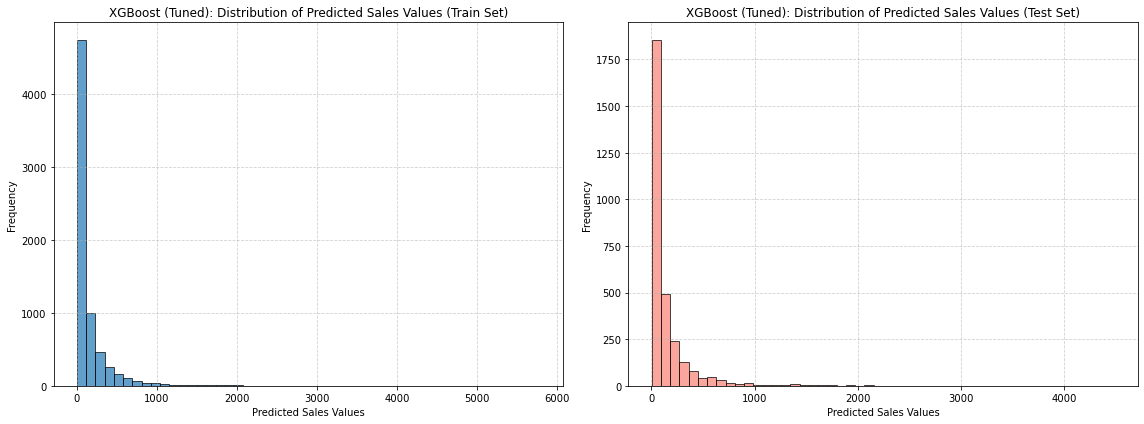

In [69]:
name = "XGBoost (Tuned)"
model = models_to_evaluate[name]

print(f"\n--- Distribution of Predicted Sales Values Plots for {name} ---")

y_train_pred_log = model.predict(X_train_selected)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = model.predict(X_test_selected)
y_test_pred = np.expm1(y_test_pred_log)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(y_train_pred, bins=50, edgecolor='k', alpha=0.7)
axes[0].set_title(f'{name}: Distribution of Predicted Sales Values (Train Set)')
axes[0].set_xlabel('Predicted Sales Values')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, linestyle='--', alpha=0.6)


axes[1].hist(y_test_pred, bins=50, edgecolor='k', alpha=0.7, color='salmon')
axes[1].set_title(f'{name}: Distribution of Predicted Sales Values (Test Set)')
axes[1].set_xlabel('Predicted Sales Values')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Inference:

XGBoost (Tuned):

* Training Set: The distribution of predicted sales values for the training set appears to be right-skewed, with a concentration of predictions at lower sales values and a long tail extending towards higher values. This mirrors the distribution of the actual sales data, which is expected.
* Test Set: The distribution of predicted sales values for the test set shows a similar right-skewed pattern. The range of predicted values on the test set might be slightly narrower or have fewer extreme high values compared to the training set, which could contribute to the performance drop on unseen data. The overall shape is consistent, which is a good sign that the model is learning the general distribution, even if the accuracy on individual high values is lower (as seen in the residuals plot).


--- Final Model Plots for XGBoost (Tuned) ---


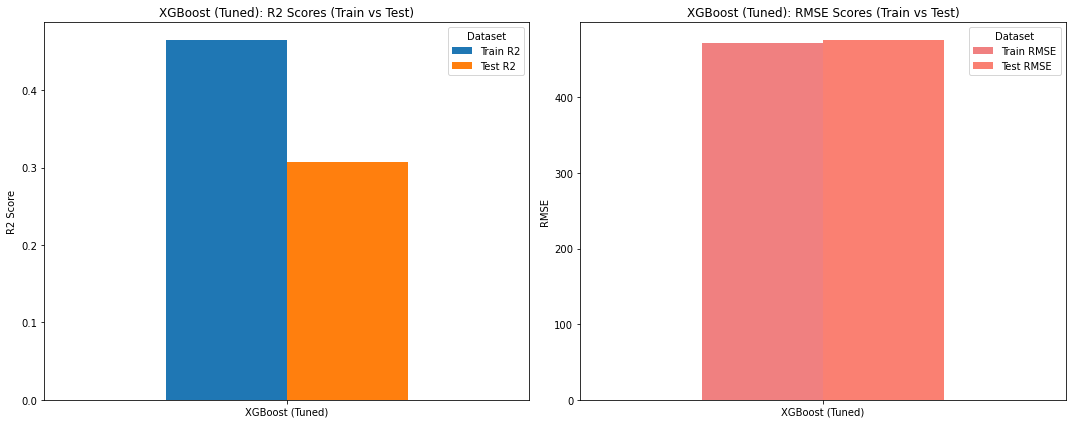

In [70]:
name = "XGBoost (Tuned)"

print(f"\n--- Final Model Plots for {name} ---")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

final_results_df.loc[[name]][['Train R2', 'Test R2']].plot(kind='bar', ax=axes[0])
axes[0].set_title(f'{name}: R2 Scores (Train vs Test)')
axes[0].set_ylabel('R2 Score')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Dataset')

final_results_df.loc[[name]][['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=axes[1], color=['lightcoral', 'salmon'])
axes[1].set_title(f'{name}: RMSE Scores (Train vs Test)')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Dataset')

plt.tight_layout()
plt.show()


--- Predicted vs. Actual Sales Plots for XGBoost (Tuned) ---


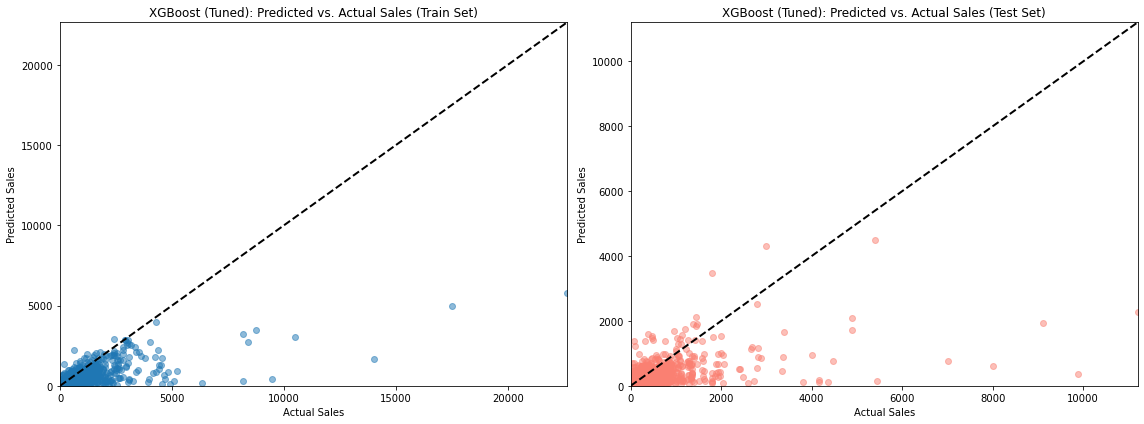

In [71]:
name = "XGBoost (Tuned)"
model = models_to_evaluate[name]

print(f"\n--- Predicted vs. Actual Sales Plots for {name} ---")

y_train_pred_log = model.predict(X_train_selected)
y_train_pred = np.expm1(y_train_pred_log)
y_train_true = np.expm1(y_train)

y_test_pred_log = model.predict(X_test_selected)
y_test_pred = np.expm1(y_test_pred_log)
y_test_true = np.expm1(y_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_train_true, y_train_pred, alpha=0.5)
axes[0].plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'k--', lw=2)
axes[0].set_title(f'{name}: Predicted vs. Actual Sales (Train Set)')
axes[0].set_xlabel('Actual Sales')
axes[0].set_ylabel('Predicted Sales')
axes[0].set_xlim([0, y_train_true.max()])
axes[0].set_ylim([0, y_train_true.max()])


axes[1].scatter(y_test_true, y_test_pred, alpha=0.5, color='salmon')
axes[1].plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'k--', lw=2)
axes[1].set_title(f'{name}: Predicted vs. Actual Sales (Test Set)')
axes[1].set_xlabel('Actual Sales')
axes[1].set_ylabel('Predicted Sales')
axes[1].set_xlim([0, y_test_true.max()])
axes[1].set_ylim([0, y_test_true.max()])


plt.tight_layout()
plt.show()


--- Residuals Plots for XGBoost (Tuned) ---


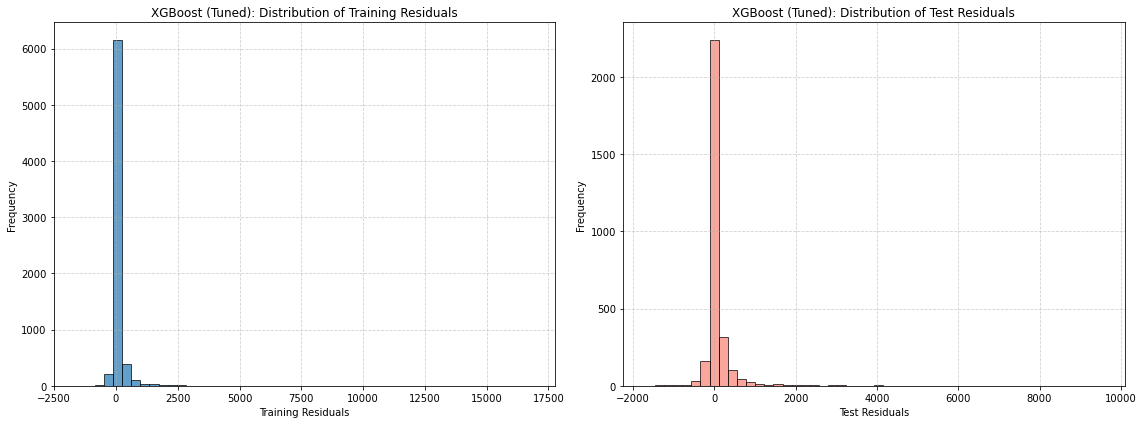

In [72]:
name = "XGBoost (Tuned)"
model = models_to_evaluate[name]

print(f"\n--- Residuals Plots for {name} ---")

y_train_pred_log = model.predict(X_train_selected)
y_train_pred = np.expm1(y_train_pred_log)
y_train_true = np.expm1(y_train)

train_residuals = y_train_true - y_train_pred

y_test_pred_log = model.predict(X_test_selected)
y_test_pred = np.expm1(y_test_pred_log)
y_test_true = np.expm1(y_test)

test_residuals = y_test_true - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(train_residuals, bins=50, edgecolor='k', alpha=0.7)
axes[0].set_title(f'{name}: Distribution of Training Residuals')
axes[0].set_xlabel('Training Residuals')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, linestyle='--', alpha=0.6)


axes[1].hist(test_residuals, bins=50, edgecolor='k', alpha=0.7, color='salmon')
axes[1].set_title(f'{name}: Distribution of Test Residuals')
axes[1].set_xlabel('Test Residuals')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()